## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## Compute the camera calibration using chessboard images, find the calibration matrix and distortion coefficients and perform undistortion on raw images

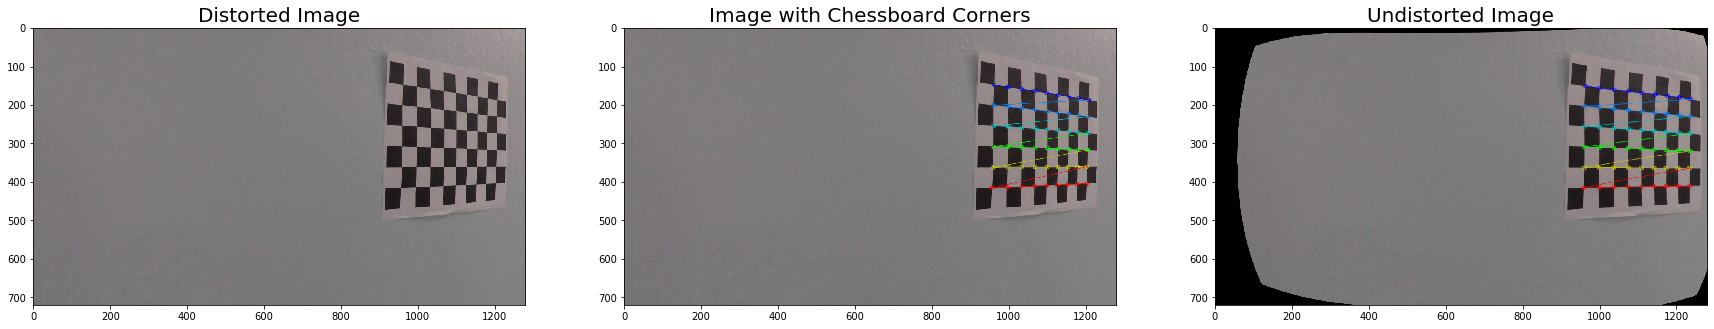

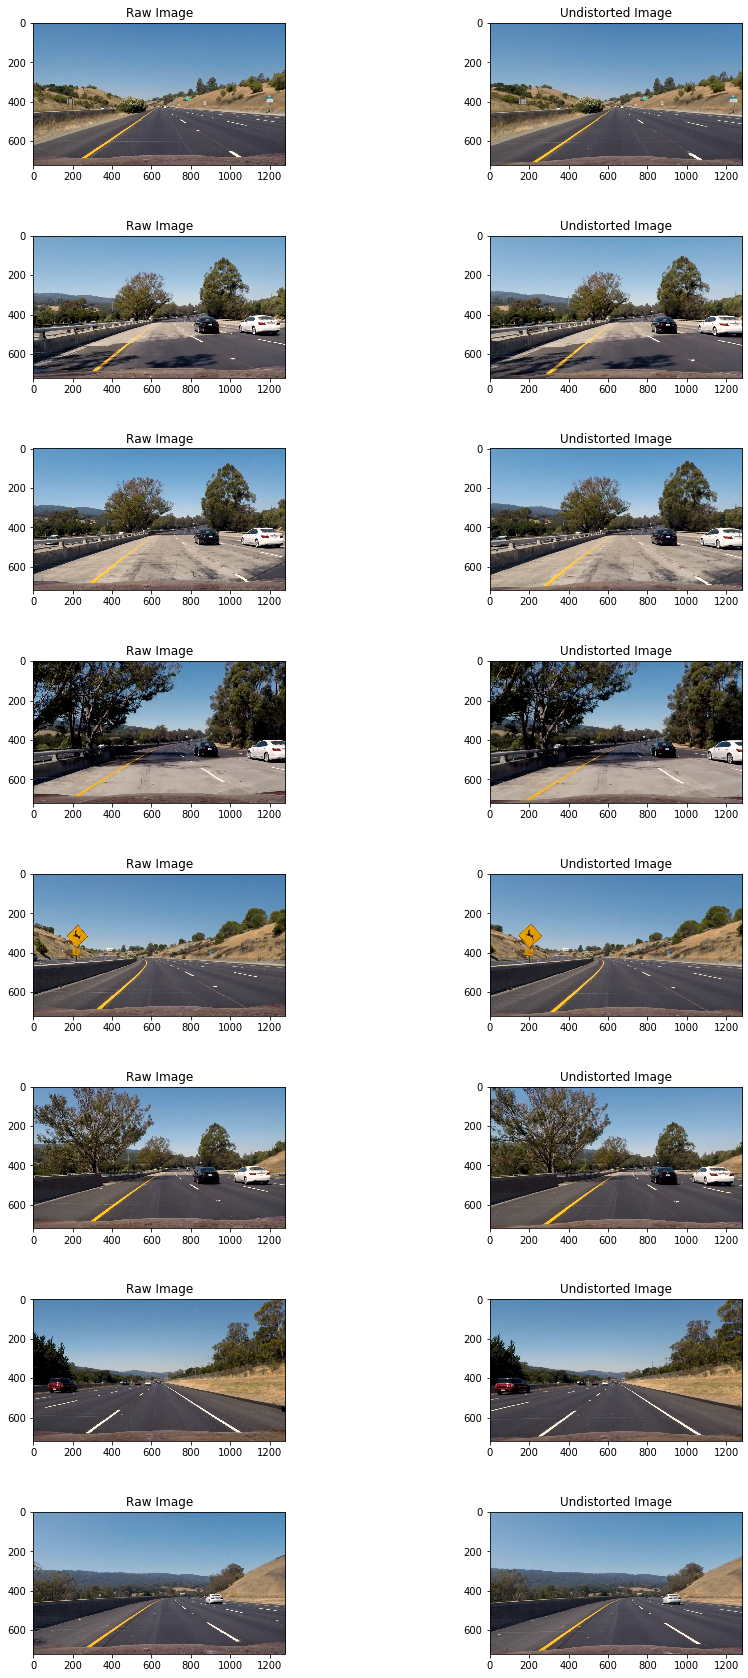

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import copy
import pickle

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')
f, axes= plt.subplots(1,3,figsize=(30,30))
# Step through the list and search for chessboard corners
for index, fname in enumerate(images):

    img = cv2.imread(fname)
    if index == 0:
        axes[0].set_title('Distorted Image', fontsize=20)
        axes[0].imshow(img)
        
    fname1 = fname.split('/')[-1]
    cv2.imwrite('../output_images/distorted_images/distorted_image_'+str(fname1),img)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        
        if index == 0:
            axes[1].set_title('Image with Chessboard Corners', fontsize=20)
            axes[1].imshow(img)
            
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
        undist = cv2.undistort(img, mtx, dist, None, mtx)
        
        if index == 0:
            axes[2].set_title('Undistorted Image', fontsize=20)
            axes[2].imshow(undist)
            
        fname2 = fname.split('/')[-1]
        cv2.imwrite('../output_images/undistorted_images/undistorted_image_'+str(fname2),undist)
        

f1, axes1= plt.subplots(8,2,figsize=(15,30))
f1.subplots_adjust(hspace=0.5)

images = glob.glob('../test_images/*.jpg')        
for index1,fname in enumerate(images):
    img = cv2.imread(fname)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    fname3 = fname.split('/')[-1]
    cv2.imwrite('../output_images/distorted_images_raw/distorted_image_'+str(fname3),img)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imwrite('../output_images/undistorted_images_raw/undistorted_image_'+str(fname3),undist)
    axes1[index1,0].set_title("Raw Image")
    axes1[index1,0].imshow(img)
    axes1[index1,1].set_title("Undistorted Image")
    axes1[index1,1].imshow(undist)
    

## Apply perspective transform to binary image by first calculating the perspective transform matrix on the raw undistorted image

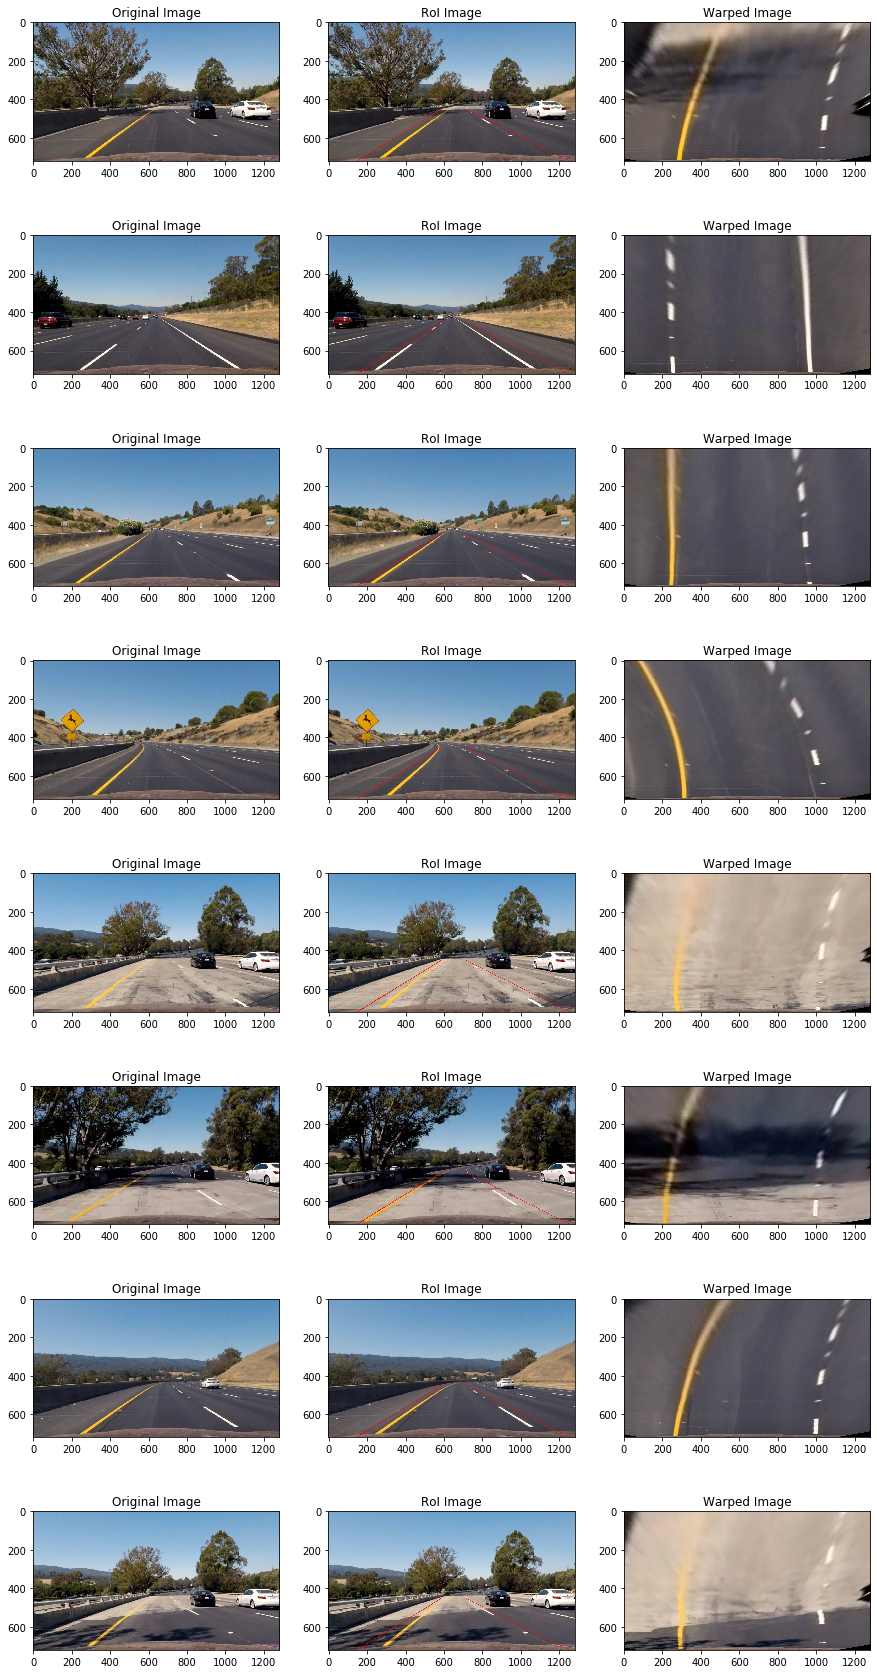

In [5]:
# image = '../output_images/undistorted_images_raw/undistorted_image_straight_lines1.jpg'
images1 = glob.glob('../output_images/undistorted_images_raw/*.jpg')
f, axes= plt.subplots(8,3,figsize=(15,30))
f.subplots_adjust(hspace=0.5)

for index, fname in enumerate(images1):

    # fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    img = cv2.imread(fname)
    axes[index,0].set_title("Original Image")
    axes[index,0].imshow(img)
    
    img_raw = img.copy()
    # img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    bottomY = 720
    topY = 450

    left1_x, left1_y = (150, bottomY)
    left2_x, left2_y = (590, topY)
    right1_x, right1_y = (710, topY)
    right2_x, right2_y = (1250, bottomY)

    cv2.line(img_raw, (left1_x, left1_y), (left2_x, left2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (left2_x, left2_y), (right1_x, right1_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right1_x, right1_y), (right2_x, right2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right2_x, right2_y), (left1_x, left1_y), [255, 0, 0], 2)
    axes[index,1].set_title("RoI Image")
    axes[index,1].imshow(img_raw)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    src = np.float32([[left2_x, left2_y], [right1_x, right1_y], [right2_x, right2_y], [left1_x, left1_y]])
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    offset = 200
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    MInverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    axes[index,2].set_title("Warped Image")
    axes[index,2].imshow(warped)
    pickle.dump({'M': M, 'MInverse': MInverse}, open('../output_images/perspective_transform.p', 'wb'))
    
    fname5 = fname.split('/')[-1]
    cv2.imwrite('../output_images/warped_binary/warped_binary_'+str(fname5), warped)
    

In [3]:
# M_MInverse_Matrix = pickle.load( open('../output_images/perspective_transform.p', 'rb' ) )
# M_, MInverse = map(M_MInverse_Matrix.get, ('M','MInverse'))
# images2 = sorted(glob.glob('../output_images/threshold_binary/*.jpg'))

# for index, fname in enumerate(images2):
#     print(fname)
#     img = cv2.imread(fname)
#     img_size = (img.shape[1], img.shape[0])
#     warped = cv2.warpPerspective(img, M_, img_size)
#     plt.imshow(warped)
#     plt.show()
#     fname5 = fname.split('/')[-1]
#     cv2.imwrite('../output_images/warped_binary/warped_binary_'+str(fname5), warped)

## Compute thresholded binary image using a combination of color threshold and gradients for S channel in HLS color space and Sobel X gradient derivative 

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test1.jpg


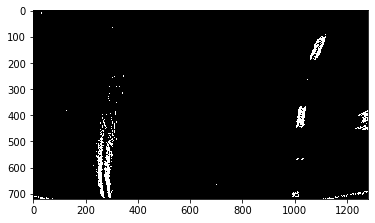

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test3.jpg


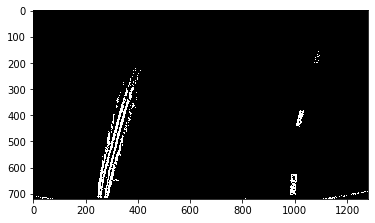

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_straight_lines2.jpg


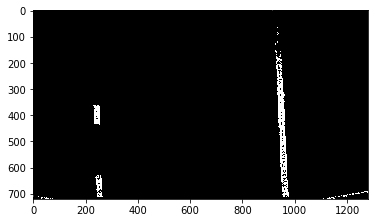

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test4.jpg


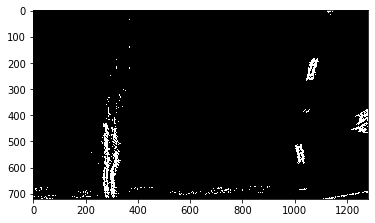

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test6.jpg


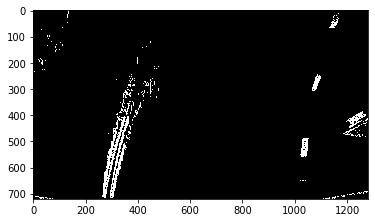

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test2.jpg


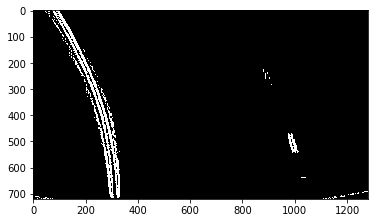

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_straight_lines1.jpg


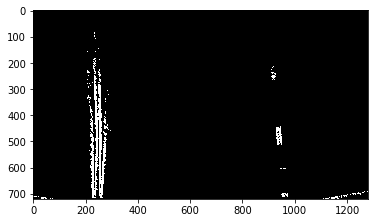

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test5.jpg


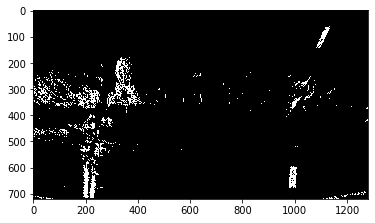

In [10]:
# Convert to HLS color space and separate the S channel
# Note: img is the undistorted image

images = glob.glob('../output_images/warped_binary/*.jpg')        
for fname in images:
    img = cv2.imread(fname)
    hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    yuv = cv2.cvtColor(img, cv2.COLOR_BGR2YUV)
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    s_channel = hls[:,:,2]
    s_thresh = (100, 255)
    l_channel = hls[:,:,1]
    l_thresh = (100, 255)
    y_channel = yuv[:,:,0]
    y_thresh = (100, 255)
    
    sx_thresh=(10, 160) 
    
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold Y channel
    y_binary = np.zeros_like(y_channel)
    y_binary[(y_channel >= y_thresh[0]) & (y_channel <= y_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.zeros_like(s_channel)
    color_binary[(sxbinary == 1) | (((s_channel == 1) & (l_channel==1)) & (y_channel==1)) ] = 1
    
    
    fname4 = fname.split('/')[-1]
    cv2.imwrite('../output_images/threshold_binary/threshold_binary_'+str(fname4), color_binary*255)
    print('../output_images/threshold_binary/threshold_binary_'+str(fname4))
    plt.imshow(color_binary,cmap='gray')
    plt.show()
    

## Fit lane lines using sliding window and determine lane curvature

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_straight_lines1.jpg
(720, 1280, 3)
2242.6344726494603 m 102418.76073477854 m
2.2426344726494603 km 102.41876073477854 km


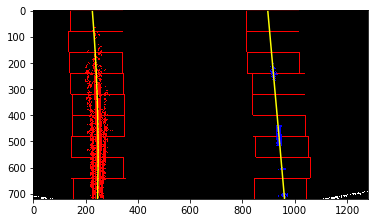

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_straight_lines2.jpg
(720, 1280, 3)
2188.0769678867214 m 9755.949351200008 m
2.1880769678867216 km 9.755949351200009 km


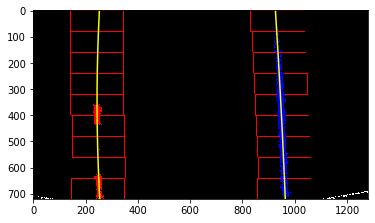

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test1.jpg
(720, 1280, 3)
2478.7292408674366 m 458.3195889546102 m
2.4787292408674366 km 0.4583195889546102 km


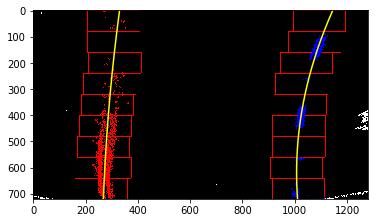

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test2.jpg
(720, 1280, 3)
339.6817365260981 m 881.8178807944531 m
0.3396817365260981 km 0.8818178807944531 km


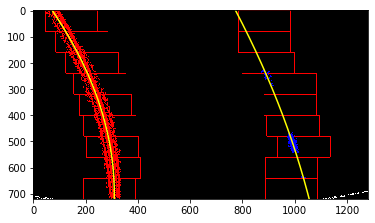

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test3.jpg
(720, 1280, 3)
1413.2790487118073 m 438.24775752872836 m
1.4132790487118072 km 0.43824775752872835 km


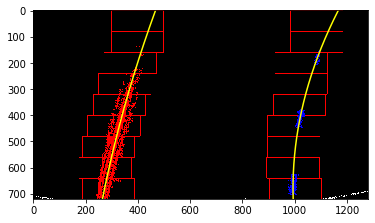

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test4.jpg
(720, 1280, 3)
6498.202850329699 m 407.10585118626574 m
6.498202850329699 km 0.40710585118626574 km


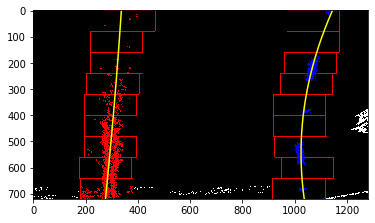

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test5.jpg
(720, 1280, 3)
943.0676715463645 m 236.53571665130394 m
0.9430676715463645 km 0.23653571665130393 km


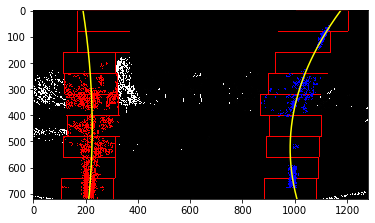

../output_images/threshold_binary/threshold_binary_warped_binary_undistorted_image_test6.jpg
(720, 1280, 3)
1570.0150036269827 m 288.3389369675053 m
1.5700150036269827 km 0.2883389369675053 km


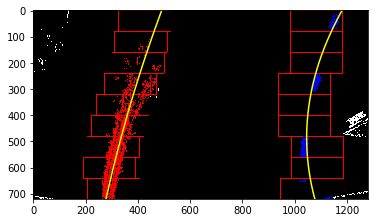

In [11]:
def find_lane_pixels(binary_warped):
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    
   
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero (i.e. activated) pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
     # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(255,0,0), 2)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(255,0,0), 2)
        
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass
   
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    

    return leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds

def fit_polynomial(binary_warped):
    global leftx_arr, rightx_arr, laneIndexCounter
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img, nonzerox, nonzeroy, left_lane_inds, right_lane_inds = find_lane_pixels(binary_warped)
    
    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    print(out_img.shape)
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')

    return out_img, left_fit_cr, right_fit_cr, left_fit, right_fit

def measure_curvature_real(left_fit_cr, right_fit_cr):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
    
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

images3 = sorted(glob.glob('../output_images/threshold_binary/*.jpg'))
left_fit_arr, right_fit_arr, left_curverad_arr, right_curverad_arr, left_fitcr_arr, right_fitcr_arr = [], [], [], [], [], []
for index, fname in enumerate(images3):
    print(fname)
    binary_warped = cv2.imread(fname)
    binary_warped = cv2.cvtColor(binary_warped, cv2.COLOR_BGR2GRAY)
    out_img, left_fit_cr, right_fit_cr, left_fit, right_fit = fit_polynomial(binary_warped)
    left_fit_arr.append(left_fit)
    right_fit_arr.append(right_fit)
    left_fitcr_arr.append(left_fit_cr)
    right_fitcr_arr.append(right_fit_cr)
    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
    print(left_curverad/1000, 'km', right_curverad/1000, 'km')
    left_curverad_arr.append(left_curverad)
    right_curverad_arr.append(right_curverad)
    fname6 = fname.split('/')[-1]
    cv2.imwrite('../output_images/fit_lane_lines/fit_lane_line_'+str(fname6), out_img)
    plt.imshow(out_img)
    plt.show()
    
    

## Merge final curve to the original image

../output_images/undistorted_images_raw/undistorted_image_straight_lines1.jpg


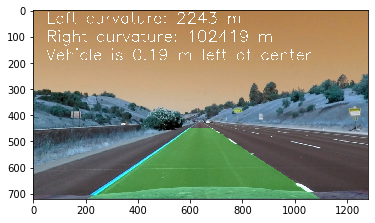

../output_images/undistorted_images_raw/undistorted_image_straight_lines2.jpg


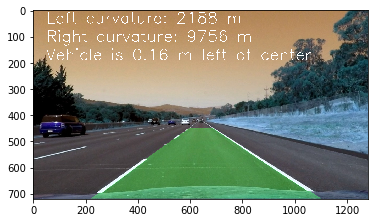

../output_images/undistorted_images_raw/undistorted_image_test1.jpg


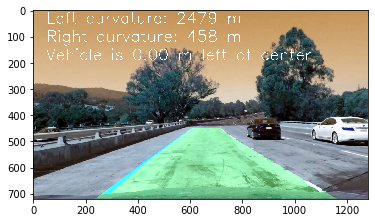

../output_images/undistorted_images_raw/undistorted_image_test2.jpg


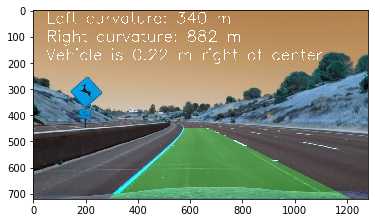

../output_images/undistorted_images_raw/undistorted_image_test3.jpg


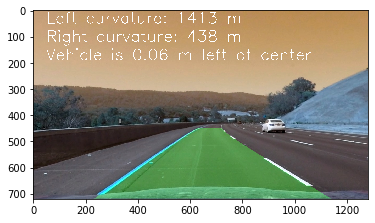

../output_images/undistorted_images_raw/undistorted_image_test4.jpg


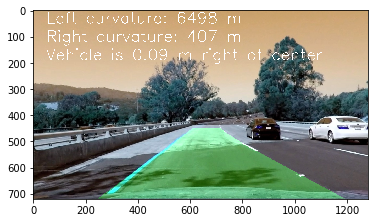

../output_images/undistorted_images_raw/undistorted_image_test5.jpg


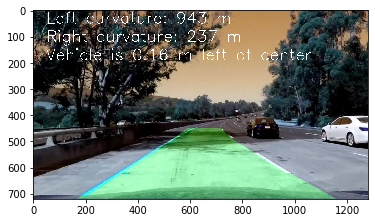

../output_images/undistorted_images_raw/undistorted_image_test6.jpg


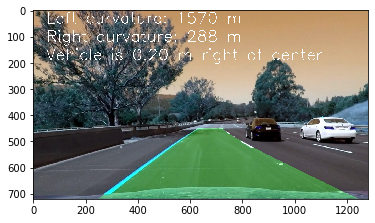

In [14]:
ploty = np.linspace(0, 719, num=720)# to cover same y-range as image
images6 = sorted(glob.glob('../output_images/undistorted_images_raw/*.jpg'))
M_MInverse_Matrix = pickle.load( open('../output_images/perspective_transform.p', 'rb' ) )
M_, MInverse = map(M_MInverse_Matrix.get, ('M','MInverse'))
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
for index, fname in enumerate(images6):
    print(fname)
    undist_raw = cv2.imread(fname)
    undist_raw = cv2.cvtColor(undist_raw, cv2.COLOR_BGR2RGB)
    color_warp = np.zeros_like(undist_raw).astype(np.uint8)
    
    left_fitx = left_fit_arr[index][0]*ploty**2 + left_fit_arr[index][1]*ploty + left_fit_arr[index][2]
    right_fitx = right_fit_arr[index][0]*ploty**2 + right_fit_arr[index][1]*ploty + right_fit_arr[index][2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInverse, (undist_raw.shape[1], undist_raw.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist_raw, 1, newwarp, 0.3, 0)
    
    
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad_arr[index]), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad_arr[index]), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    # Calculate vehicle center and deviation from center 
    # Calculate vehicle center
    xMax = undist_raw.shape[1]*xm_per_pix
    yMax = undist_raw.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    leftLane = left_fitcr_arr[index][0]*yMax**2 + left_fitcr_arr[index][1]*yMax + left_fitcr_arr[index][2]
    rightLane = right_fitcr_arr[index][0]*yMax**2 + right_fitcr_arr[index][1]*yMax + right_fitcr_arr[index][2]
    middleLane = leftLane + (rightLane - leftLane)/2
    diffFromVehicle = middleLane - vehicleCenter
    laneDistance = rightLane - leftLane
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
        
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    fname7 = fname.split('/')[-1]
    plt.imshow(result)
    plt.show()
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
    cv2.imwrite('../output_images/final_outputs/final_output_'+str(fname7), result)
    


## Run test on video

In [45]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
counter = 0.0
laneCounter = 0
pts_left_arr, pts_right_arr = [], []


def process_image(img):
    global laneCounter
    global counter
    
    
    
    # 1. Undistortion
    img = cv2.undistort(img, mtx, dist, None, mtx)
    
    # 2. Apply Perspective Transform
    img_raw = img.copy()
    # img_raw = cv2.cvtColor(img_raw, cv2.COLOR_BGR2RGB)
    bottomY = 720
    topY = 450

    left1_x, left1_y = (150, bottomY)
    left2_x, left2_y = (590, topY)
    right1_x, right1_y = (710, topY)
    right2_x, right2_y = (1250, bottomY)

    cv2.line(img_raw, (left1_x, left1_y), (left2_x, left2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (left2_x, left2_y), (right1_x, right1_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right1_x, right1_y), (right2_x, right2_y), [255, 0, 0], 2)
    cv2.line(img_raw, (right2_x, right2_y), (left1_x, left1_y), [255, 0, 0], 2)
    gray = cv2.cvtColor(img_raw, cv2.COLOR_RGB2GRAY)
    src = np.float32([[left2_x, left2_y], [right1_x, right1_y], [right2_x, right2_y], [left1_x, left1_y]])
    nX = gray.shape[1]
    nY = gray.shape[0]
    img_size = (nX, nY)
    offset = 200
    dst = np.float32([[offset, 0], [img_size[0]-offset, 0], [img_size[0]-offset, img_size[1]], [offset, img_size[1]]])
    img_size = (img.shape[1], img.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    MInverse = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size)
    
    
    # 3. Combine Color and Gradient Threshold
    hls = cv2.cvtColor(warped, cv2.COLOR_BGR2HLS)
    yuv = cv2.cvtColor(warped, cv2.COLOR_BGR2YUV)
    lab = cv2.cvtColor(warped, cv2.COLOR_BGR2LAB)
    gray = cv2.cvtColor(warped, cv2.COLOR_RGB2GRAY)
    
    s_channel = hls[:,:,2]
    s_thresh = (100, 255)
    l_channel = hls[:,:,1]
    l_thresh = (100, 255)
    y_channel = yuv[:,:,0]
    y_thresh = (100, 255)
    
    sx_thresh=(10, 160) 
    
    # Sobel x
    sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobelx = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobelx)
    sxbinary[(scaled_sobelx >= sx_thresh[0]) & (scaled_sobelx <= sx_thresh[1])] = 1
    
    # Threshold S channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold L channel
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh[0]) & (l_channel <= l_thresh[1])] = 1
    
    # Threshold Y channel
    y_binary = np.zeros_like(y_channel)
    y_binary[(y_channel >= y_thresh[0]) & (y_channel <= y_thresh[1])] = 1
    
    
    # Stack each channel
    color_binary = np.zeros_like(s_channel)*255
    color_binary[(sxbinary == 1) | (((s_channel == 1) & (l_channel==1)) & (y_channel==1)) ] = 1
  

    
    # 4. Fit lane lines to polynomial
    out_img, left_fit_cr, right_fit_cr, left_fit, right_fit = fit_polynomial(color_binary)
    left_curverad, right_curverad = measure_curvature_real(left_fit_cr, right_fit_cr)
    print(left_curverad, 'm', right_curverad, 'm')
    print(left_curverad/1000, 'km', right_curverad/1000, 'km')
    # plt.imshow(out_img)
    # plt.show()
    
    # 5. Merge final lane lines to original image 
    color_warp = np.zeros_like(img).astype(np.uint8)
    
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    # pts = np.hstack((pts_left, pts_right))
    
    # Lane Sanity Check 
    pts_left_arr.append(pts_left)
    pts_right_arr.append(pts_right)
    laneCounter += 1
    
    if np.all(pts_right.squeeze(0)[:,0] > pts_left.squeeze(0)[:,0]):
        print("Lane Correct")
        # print(pts_left)
        # print(pts_right)
        pts = np.hstack((pts_left, pts_right))
        if len(pts_left_arr) > 3:
            pts_left_smooth = (pts_left_arr[laneCounter - 1] + pts_left_arr[laneCounter - 2] + pts_left_arr[laneCounter - 3]) / 3
            pts_right_smooth = (pts_right_arr[laneCounter - 1] + pts_right_arr[laneCounter - 2] + pts_right_arr[laneCounter - 3]) / 3
            pts = np.hstack((pts_left_smooth, pts_right_smooth))
    else:
        print("Lane Incorrect !!! Using prev lane coordinates ...")
        pts_left_temp = pts_left_arr[laneCounter - 2]
        pts_right_temp = pts_right_arr[laneCounter - 2]
        pts_left_arr.append(pts_left_temp)
        pts_right_arr.append(pts_right_temp)
        # print(pts_left_temp)
        # print(pts_right_temp)
        pts = np.hstack((pts_left_temp, pts_right_temp))
        laneCounter += 1
    
    
        
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, MInverse, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    counter +=1.0
    print(counter)
    # cv2.putText(result, 'Frame no: {:f} m'.format(counter), (50, 40), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    cv2.putText(result, 'Left curvature: {:.0f} m'.format(left_curverad), (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    cv2.putText(result, 'Right curvature: {:.0f} m'.format(right_curverad), (50, 120), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    # Calculate vehicle center and deviation from center 
    # Calculate vehicle center
    xMax = img.shape[1]*xm_per_pix
    yMax = img.shape[0]*ym_per_pix
    vehicleCenter = xMax / 2
    leftLane = left_fit_cr[0]*yMax**2 + left_fit_cr[1]*yMax + left_fit_cr[2]
    rightLane = right_fit_cr[0]*yMax**2 + right_fit_cr[1]*yMax + right_fit_cr[2]
    middleLane = leftLane + (rightLane - leftLane)/2
    diffFromVehicle = middleLane - vehicleCenter
    
    if diffFromVehicle > 0:
        message = '{:.2f} m right'.format(diffFromVehicle)
    else:
        message = '{:.2f} m left'.format(-diffFromVehicle)
        
    cv2.putText(result, 'Vehicle is {} of center'.format(message), (50, 190), cv2.FONT_HERSHEY_SIMPLEX, 2, (255, 255, 255), 2)
    
    return result



## Test on project video


                                                              
t:   2%|▏         | 30/1260 [20:29<04:48,  4.26it/s, now=None][A
                                                              
t:   2%|▏         | 30/1260 [20:29<04:48,  4.26it/s, now=None][A

t:   0%|          | 0/1260 [00:00<?, ?it/s, now=None]

(720, 1280, 3)
361.71501624893693 m 714.2922967307192 m
0.3617150162489369 km 0.7142922967307191 km
Lane Correct
27.0
Moviepy - Building video ../project_video_output.mp4.
Moviepy - Writing video ../project_video_output.mp4

(720, 1280, 3)
361.71501624893693 m 714.2922967307192 m
0.3617150162489369 km 0.7142922967307191 km
Lane Correct
28.0




t:   0%|          | 3/1260 [00:00<01:13, 17.18it/s, now=None]

t:   0%|          | 5/1260 [00:00<01:15, 16.72it/s, now=None]

(720, 1280, 3)
372.4051490745674 m 508.5493415849418 m
0.3724051490745674 km 0.5085493415849418 km
Lane Correct
29.0
(720, 1280, 3)
375.5609985625503 m 441.5868992426591 m
0.3755609985625503 km 0.4415868992426591 km
Lane Correct
30.0
(720, 1280, 3)
386.52625066058835 m 404.3908393045522 m
0.3865262506605883 km 0.40439083930455216 km
Lane Correct
31.0
(720, 1280, 3)
389.8720382130559 m 421.94401078569143 m
0.3898720382130559 km 0.42194401078569144 km
Lane Correct
32.0




t:   1%|          | 7/1260 [00:00<01:13, 17.07it/s, now=None]

t:   1%|          | 9/1260 [00:00<01:12, 17.34it/s, now=None]

(720, 1280, 3)
396.9966506626766 m 402.57076295946894 m
0.3969966506626766 km 0.4025707629594689 km
Lane Correct
33.0
(720, 1280, 3)
407.4474220593566 m 409.36312443196323 m
0.4074474220593566 km 0.4093631244319632 km
Lane Correct
34.0
(720, 1280, 3)
406.503265706221 m 436.5833889890252 m
0.406503265706221 km 0.4365833889890252 km
Lane Correct
35.0
(720, 1280, 3)
410.0579859353001 m 542.6194161171207 m
0.41005798593530013 km 0.5426194161171207 km
Lane Correct
36.0




t:   1%|          | 11/1260 [00:00<01:11, 17.38it/s, now=None]

t:   1%|          | 13/1260 [00:00<01:10, 17.61it/s, now=None]

(720, 1280, 3)
430.6395263298671 m 590.2019967464607 m
0.43063952632986713 km 0.5902019967464608 km
Lane Correct
37.0
(720, 1280, 3)
427.3083388403954 m 550.7705739862563 m
0.4273083388403954 km 0.5507705739862563 km
Lane Correct
38.0
(720, 1280, 3)
484.53452317724066 m 493.89869710410505 m
0.48453452317724066 km 0.49389869710410506 km
Lane Correct
39.0
(720, 1280, 3)
473.1727380949088 m 485.08174891230897 m
0.47317273809490884 km 0.485081748912309 km
Lane Correct
40.0




t:   1%|          | 15/1260 [00:00<01:09, 17.81it/s, now=None]

t:   1%|▏         | 17/1260 [00:00<01:08, 18.08it/s, now=None]

(720, 1280, 3)
484.39877705495735 m 1761.3594899989955 m
0.4843987770549574 km 1.7613594899989955 km
Lane Correct
41.0
(720, 1280, 3)
442.66915110127434 m 1994.4963682620341 m
0.44266915110127436 km 1.9944963682620342 km
Lane Correct
42.0
(720, 1280, 3)
428.7706021915172 m 2220.4776749107414 m
0.4287706021915172 km 2.2204776749107413 km
Lane Correct
43.0
(720, 1280, 3)
401.0888006406658 m 937.1479525868072 m
0.4010888006406658 km 0.9371479525868072 km
Lane Correct
44.0




t:   2%|▏         | 19/1260 [00:01<01:10, 17.72it/s, now=None]

t:   2%|▏         | 21/1260 [00:01<01:08, 17.97it/s, now=None]

(720, 1280, 3)
387.8461238172429 m 840.8873452600284 m
0.3878461238172429 km 0.8408873452600284 km
Lane Correct
45.0
(720, 1280, 3)
402.7311862435598 m 943.1631321630273 m
0.4027311862435598 km 0.9431631321630273 km
Lane Correct
46.0
(720, 1280, 3)
439.7925026724929 m 823.2478733266283 m
0.4397925026724929 km 0.8232478733266283 km
Lane Correct
47.0
(720, 1280, 3)
424.10009255934443 m 491.27294598185443 m
0.42410009255934444 km 0.49127294598185445 km
Lane Correct
48.0




t:   2%|▏         | 23/1260 [00:01<01:09, 17.89it/s, now=None]

t:   2%|▏         | 25/1260 [00:01<01:08, 17.99it/s, now=None]

(720, 1280, 3)
440.7755788454331 m 637.4312352904525 m
0.44077557884543306 km 0.6374312352904525 km
Lane Correct
49.0
(720, 1280, 3)
442.65534535135475 m 562.6853775758303 m
0.44265534535135476 km 0.5626853775758304 km
Lane Correct
50.0
(720, 1280, 3)
422.6979585890805 m 568.1537333972389 m
0.4226979585890805 km 0.5681537333972388 km
Lane Correct
51.0
(720, 1280, 3)
398.1120085912122 m 501.87684558813214 m
0.3981120085912122 km 0.5018768455881322 km
Lane Correct
52.0




t:   2%|▏         | 27/1260 [00:01<01:08, 17.89it/s, now=None]

t:   2%|▏         | 29/1260 [00:01<01:08, 17.98it/s, now=None]

(720, 1280, 3)
404.41717485171927 m 341.1460292475379 m
0.40441717485171924 km 0.3411460292475379 km
Lane Correct
53.0
(720, 1280, 3)
382.8673811131536 m 359.5366950027853 m
0.3828673811131536 km 0.3595366950027853 km
Lane Correct
54.0
(720, 1280, 3)
382.4879373860639 m 39390.52626391137 m
0.3824879373860639 km 39.39052626391137 km
Lane Correct
55.0
(720, 1280, 3)
348.2745846481481 m 848.9981783344742 m
0.3482745846481481 km 0.8489981783344742 km
Lane Correct
56.0




t:   2%|▏         | 31/1260 [00:01<01:08, 18.05it/s, now=None]

t:   3%|▎         | 33/1260 [00:01<01:07, 18.10it/s, now=None]

(720, 1280, 3)
319.5787399164169 m 998.7262539226904 m
0.3195787399164169 km 0.9987262539226903 km
Lane Correct
57.0
(720, 1280, 3)
301.94350627403225 m 376.6224813080113 m
0.30194350627403227 km 0.3766224813080113 km
Lane Correct
58.0
(720, 1280, 3)
282.35451307429946 m 435.5271052341317 m
0.2823545130742995 km 0.4355271052341317 km
Lane Correct
59.0
(720, 1280, 3)
296.16547916159203 m 414.987246821865 m
0.296165479161592 km 0.41498724682186505 km
Lane Correct
60.0




t:   3%|▎         | 35/1260 [00:01<01:08, 17.85it/s, now=None]

t:   3%|▎         | 37/1260 [00:02<01:07, 18.06it/s, now=None]

(720, 1280, 3)
288.25084060004497 m 492.2852160219207 m
0.28825084060004497 km 0.4922852160219207 km
Lane Correct
61.0
(720, 1280, 3)
286.4850340836325 m 643.6733410201806 m
0.2864850340836325 km 0.6436733410201806 km
Lane Correct
62.0
(720, 1280, 3)
290.6842813085714 m 569.9665540493389 m
0.29068428130857143 km 0.5699665540493389 km
Lane Correct
63.0
(720, 1280, 3)
286.207159692781 m 474.2326830563314 m
0.286207159692781 km 0.47423268305633137 km
Lane Correct
64.0




t:   3%|▎         | 39/1260 [00:02<01:07, 18.04it/s, now=None]

t:   3%|▎         | 41/1260 [00:02<01:07, 18.01it/s, now=None]

(720, 1280, 3)
266.4287492095398 m 420.81112183490245 m
0.2664287492095398 km 0.42081112183490244 km
Lane Correct
65.0
(720, 1280, 3)
253.81141169850454 m 567.4731485820332 m
0.2538114116985045 km 0.5674731485820332 km
Lane Correct
66.0
(720, 1280, 3)
255.6635458714977 m 416.02672774521494 m
0.2556635458714977 km 0.41602672774521493 km
Lane Correct
67.0
(720, 1280, 3)
262.36330855046594 m 413.67570496787044 m
0.26236330855046597 km 0.41367570496787043 km
Lane Correct
68.0




t:   3%|▎         | 43/1260 [00:02<01:07, 18.04it/s, now=None]

t:   4%|▎         | 45/1260 [00:02<01:11, 16.96it/s, now=None]

(720, 1280, 3)
267.6550549896961 m 750.1911648277173 m
0.2676550549896961 km 0.7501911648277173 km
Lane Correct
69.0
(720, 1280, 3)
275.14931419101475 m 485.0988519745948 m
0.27514931419101474 km 0.48509885197459485 km
Lane Correct
70.0
(720, 1280, 3)
314.1844986345185 m 345.0492465198957 m
0.31418449863451847 km 0.3450492465198957 km
Lane Correct
71.0
(720, 1280, 3)
333.57583661531174 m 368.4613803187941 m
0.33357583661531176 km 0.3684613803187941 km
Lane Correct
72.0




t:   4%|▎         | 47/1260 [00:02<01:09, 17.33it/s, now=None]

t:   4%|▍         | 49/1260 [00:02<01:10, 17.30it/s, now=None]

(720, 1280, 3)
337.98636028165294 m 658.7300011061097 m
0.3379863602816529 km 0.6587300011061097 km
Lane Correct
73.0
(720, 1280, 3)
360.66707508785663 m 493.33709389002945 m
0.3606670750878566 km 0.49333709389002944 km
Lane Correct
74.0
(720, 1280, 3)
368.52396242461714 m 549.314624613835 m
0.36852396242461716 km 0.549314624613835 km
Lane Correct
75.0
(720, 1280, 3)
399.20722568899964 m 488.3300139354311 m
0.39920722568899963 km 0.48833001393543113 km
Lane Correct
76.0




t:   4%|▍         | 51/1260 [00:02<01:14, 16.22it/s, now=None]

t:   4%|▍         | 53/1260 [00:03<01:15, 16.04it/s, now=None]

(720, 1280, 3)
414.66194101902136 m 500.1329790325552 m
0.4146619410190214 km 0.5001329790325553 km
Lane Correct
77.0
(720, 1280, 3)
421.2237739312096 m 363.3332891913823 m
0.42122377393120963 km 0.3633332891913823 km
Lane Correct
78.0
(720, 1280, 3)
415.81011880826946 m 434.8257953902314 m
0.41581011880826946 km 0.4348257953902314 km
Lane Correct
79.0
(720, 1280, 3)
415.93434526412557 m 475.00901855248196 m
0.4159343452641256 km 0.47500901855248195 km
Lane Correct




t:   4%|▍         | 55/1260 [00:03<01:15, 15.92it/s, now=None]

80.0
(720, 1280, 3)
420.21893371935283 m 496.9796651028851 m
0.4202189337193528 km 0.4969796651028851 km
Lane Correct
81.0
(720, 1280, 3)
456.2164899053099 m 646.1466328881552 m
0.45621648990530994 km 0.6461466328881552 km
Lane Correct
82.0
(720, 1280, 3)
460.3730861934143 m 418.9137224250523 m
0.46037308619341427 km 0.4189137224250523 km
Lane Correct
83.0




t:   5%|▍         | 57/1260 [00:03<01:18, 15.39it/s, now=None]

t:   5%|▍         | 59/1260 [00:03<01:14, 16.15it/s, now=None]

t:   5%|▍         | 61/1260 [00:03<01:13, 16.41it/s, now=None]

(720, 1280, 3)
462.8420124458039 m 332.51422560428296 m
0.4628420124458039 km 0.33251422560428295 km
Lane Correct
84.0
(720, 1280, 3)
457.424199414591 m 319.1913377543099 m
0.457424199414591 km 0.3191913377543099 km
Lane Correct
85.0
(720, 1280, 3)
439.4969759069413 m 571.1811425012422 m
0.4394969759069413 km 0.5711811425012422 km
Lane Correct
86.0
(720, 1280, 3)
425.6684491055062 m 690.8400975561317 m
0.4256684491055062 km 0.6908400975561317 km
Lane Correct
87.0




t:   5%|▌         | 63/1260 [00:03<01:13, 16.31it/s, now=None]

(720, 1280, 3)
421.7549831506524 m 465.37207471283097 m
0.42175498315065235 km 0.465372074712831 km
Lane Correct
88.0
(720, 1280, 3)
398.3286073137766 m 496.7439625266007 m
0.3983286073137766 km 0.4967439625266007 km
Lane Correct
89.0
(720, 1280, 3)
403.4021313328405 m 763.5348177299944 m
0.4034021313328405 km 0.7635348177299944 km
Lane Correct
90.0
(720, 1280, 3)
387.7294895579013 m 707.3648178467018 m
0.38772948955790126 km 0.7073648178467018 km




t:   5%|▌         | 65/1260 [00:03<01:15, 15.86it/s, now=None]

t:   5%|▌         | 67/1260 [00:03<01:13, 16.32it/s, now=None]

Lane Correct
91.0
(720, 1280, 3)
384.79046166272843 m 477.76762655493116 m
0.38479046166272846 km 0.47776762655493116 km
Lane Correct
92.0
(720, 1280, 3)
392.88390197560574 m 459.7938242362723 m
0.39288390197560574 km 0.4597938242362723 km
Lane Correct
93.0
(720, 1280, 3)
398.13999590542136 m 570.7068487798817 m
0.3981399959054214 km 0.5707068487798818 km
Lane Correct
94.0




t:   5%|▌         | 69/1260 [00:04<01:12, 16.41it/s, now=None]

t:   6%|▌         | 71/1260 [00:04<01:12, 16.50it/s, now=None]

(720, 1280, 3)
393.836928135723 m 1134.0169843972321 m
0.39383692813572296 km 1.134016984397232 km
Lane Correct
95.0
(720, 1280, 3)
384.3387685126504 m 921.3530989853652 m
0.3843387685126504 km 0.9213530989853652 km
Lane Correct
96.0
(720, 1280, 3)
408.0684623571879 m 587.4015824339632 m
0.4080684623571879 km 0.5874015824339632 km
Lane Correct
97.0
(720, 1280, 3)
406.9106411226423 m 400.68317595361935 m
0.4069106411226423 km 0.40068317595361935 km
Lane Correct
98.0




t:   6%|▌         | 73/1260 [00:04<01:12, 16.43it/s, now=None]

t:   6%|▌         | 75/1260 [00:04<01:11, 16.60it/s, now=None]

(720, 1280, 3)
421.38502151612755 m 950.2156356262335 m
0.42138502151612756 km 0.9502156356262335 km
Lane Correct
99.0
(720, 1280, 3)
449.15583232000864 m 1089.091099711186 m
0.44915583232000866 km 1.089091099711186 km
Lane Correct
100.0
(720, 1280, 3)
456.7000995567995 m 830.3829812202996 m
0.4567000995567995 km 0.8303829812202996 km
Lane Correct
101.0
(720, 1280, 3)
484.9329081235905 m 1017.9806444217213 m
0.48493290812359047 km 1.0179806444217212 km
Lane Correct
102.0




t:   6%|▌         | 77/1260 [00:04<01:12, 16.43it/s, now=None]

t:   6%|▋         | 79/1260 [00:04<01:16, 15.43it/s, now=None]

(720, 1280, 3)
504.93270231744754 m 679.843200583576 m
0.5049327023174476 km 0.6798432005835761 km
Lane Correct
103.0
(720, 1280, 3)
585.8674354489115 m 555.094847470535 m
0.5858674354489115 km 0.555094847470535 km
Lane Correct
104.0
(720, 1280, 3)
608.96497317 m 584.0973511345765 m
0.60896497317 km 0.5840973511345765 km
Lane Correct
105.0




t:   6%|▋         | 81/1260 [00:04<01:13, 16.06it/s, now=None]

t:   7%|▋         | 83/1260 [00:04<01:11, 16.56it/s, now=None]

(720, 1280, 3)
608.6146015280251 m 590.9743703363366 m
0.6086146015280252 km 0.5909743703363366 km
Lane Correct
106.0
(720, 1280, 3)
619.6115536620496 m 484.1296317081774 m
0.6196115536620496 km 0.4841296317081774 km
Lane Correct
107.0
(720, 1280, 3)
569.8370235814604 m 459.5030516307212 m
0.5698370235814604 km 0.4595030516307212 km
Lane Correct
108.0
(720, 1280, 3)
554.345606870661 m 552.4481074503042 m
0.5543456068706609 km 0.5524481074503041 km
Lane Correct
109.0




t:   7%|▋         | 85/1260 [00:05<01:13, 16.05it/s, now=None]

t:   7%|▋         | 87/1260 [00:05<01:12, 16.25it/s, now=None]

(720, 1280, 3)
523.1205755295723 m 434.76649241640433 m
0.5231205755295723 km 0.43476649241640436 km
Lane Correct
110.0
(720, 1280, 3)
532.439433505069 m 463.5556466842491 m
0.5324394335050691 km 0.4635556466842491 km
Lane Correct
111.0
(720, 1280, 3)
519.9071528077407 m 459.959005128789 m
0.5199071528077407 km 0.459959005128789 km
Lane Correct
112.0
(720, 1280, 3)
473.80370247650933 m 577.5458240844401 m
0.4738037024765093 km 0.5775458240844401 km
Lane Correct
113.0




t:   7%|▋         | 89/1260 [00:05<01:12, 16.07it/s, now=None]



(720, 1280, 3)
430.27087738122935 m 489.9338964268799 m
0.4302708773812294 km 0.4899338964268799 km
Lane Correct
114.0
(720, 1280, 3)
388.1002394966976 m 394.8624794774482 m
0.3881002394966976 km 0.3948624794774482 km
Lane Correct
115.0
(720, 1280, 3)
358.8126068160677 m 462.53843239406126 m
0.35881260681606775 km 0.4625384323940613 km
Lane Correct
116.0
(720, 1280, 3)
329.55154820288465 m 418.99755336907856 m
0.3295515482028846 km 0.41899755336907857 km
Lane Correct
117.0


t:   7%|▋         | 91/1260 [00:05<01:12, 16.10it/s, now=None]

t:   7%|▋         | 93/1260 [00:05<01:14, 15.77it/s, now=None]



(720, 1280, 3)
319.4071740346088 m 494.2915382113321 m
0.3194071740346088 km 0.49429153821133215 km
Lane Correct
118.0
(720, 1280, 3)
322.96768523087627 m 529.4672226823818 m
0.32296768523087627 km 0.5294672226823818 km
Lane Correct
119.0
(720, 1280, 3)
306.89675490957785 m 566.4544566264742 m
0.30689675490957785 km 0.5664544566264742 km
Lane Correct
120.0
(720, 1280, 3)
306.4923707233403 m 555.7597222130179 m
0.3064923707233403 km 0.5557597222130178 km
Lane Correct
121.0


t:   8%|▊         | 95/1260 [00:05<01:12, 15.96it/s, now=None]

t:   8%|▊         | 97/1260 [00:05<01:12, 16.04it/s, now=None]

t:   8%|▊         | 99/1260 [00:05<01:12, 15.98it/s, now=None]

(720, 1280, 3)
321.35431421133967 m 483.1082865336374 m
0.32135431421133964 km 0.4831082865336374 km
Lane Correct
122.0
(720, 1280, 3)
332.71260193402895 m 489.6476184517614 m
0.33271260193402896 km 0.4896476184517614 km
Lane Correct
123.0
(720, 1280, 3)
344.93946765815963 m 557.9321546515513 m
0.34493946765815964 km 0.5579321546515513 km
Lane Correct
124.0
(720, 1280, 3)
360.724887296519 m 634.4613843335719 m
0.360724887296519 km 0.6344613843335719 km
Lane Correct
125.0




t:   8%|▊         | 101/1260 [00:06<01:12, 15.92it/s, now=None]

t:   8%|▊         | 103/1260 [00:06<01:11, 16.21it/s, now=None]

(720, 1280, 3)
347.0991066997517 m 501.01036345817766 m
0.3470991066997517 km 0.5010103634581776 km
Lane Correct
126.0
(720, 1280, 3)
352.8060571240041 m 480.7560077966872 m
0.3528060571240041 km 0.4807560077966872 km
Lane Correct
127.0
(720, 1280, 3)
335.7580840481152 m 305.28878961806237 m
0.33575808404811525 km 0.3052887896180624 km
Lane Correct
128.0
(720, 1280, 3)
329.9710129428659 m 344.4723961765698 m
0.3299710129428659 km 0.34447239617656983 km
Lane Correct
129.0




t:   8%|▊         | 105/1260 [00:06<01:17, 14.91it/s, now=None]

(720, 1280, 3)
333.938632897845 m 335.04628940130584 m
0.33393863289784503 km 0.3350462894013058 km
Lane Correct
130.0
(720, 1280, 3)
324.71448313635574 m 332.0142114572042 m
0.32471448313635576 km 0.3320142114572042 km
Lane Correct
131.0
(720, 1280, 3)
340.83352112094707 m 347.35402485816064 m
0.34083352112094706 km 0.34735402485816064 km
Lane Correct
132.0
(720, 1280, 3)




t:   8%|▊         | 107/1260 [00:06<01:15, 15.26it/s, now=None]

t:   9%|▊         | 109/1260 [00:06<01:13, 15.59it/s, now=None]

335.6213910767169 m 343.28179143515786 m
0.3356213910767169 km 0.34328179143515786 km
Lane Correct
133.0
(720, 1280, 3)
336.7992919269726 m 448.17889228205496 m
0.3367992919269726 km 0.448178892282055 km
Lane Correct
134.0
(720, 1280, 3)
316.55766096095397 m 421.21905414460025 m
0.31655766096095395 km 0.42121905414460026 km
Lane Correct
135.0
(720, 1280, 3)
319.82697633577635 m 591.7153519781198 m
0.31982697633577634 km 0.5917153519781198 km
Lane Correct
136.0




t:   9%|▉         | 111/1260 [00:06<01:13, 15.53it/s, now=None]

t:   9%|▉         | 113/1260 [00:06<01:12, 15.93it/s, now=None]

(720, 1280, 3)
315.10302471212003 m 615.6157967336743 m
0.31510302471212004 km 0.6156157967336743 km
Lane Correct
137.0
(720, 1280, 3)
315.7687337545091 m 607.9012400823742 m
0.31576873375450915 km 0.6079012400823742 km
Lane Correct
138.0
(720, 1280, 3)
346.4347925879293 m 590.9604749944043 m
0.3464347925879293 km 0.5909604749944043 km
Lane Correct
139.0
(720, 1280, 3)
316.0274633560696 m 512.7323143249458 m
0.31602746335606957 km 0.5127323143249458 km
Lane Correct
140.0




t:   9%|▉         | 115/1260 [00:06<01:11, 16.08it/s, now=None]

t:   9%|▉         | 117/1260 [00:07<01:09, 16.36it/s, now=None]

(720, 1280, 3)
314.4773303798903 m 584.4665949811238 m
0.3144773303798903 km 0.5844665949811237 km
Lane Correct
141.0
(720, 1280, 3)
300.0747647072759 m 614.8971713547245 m
0.3000747647072759 km 0.6148971713547244 km
Lane Correct
142.0
(720, 1280, 3)
296.8815787997837 m 570.2892321034179 m
0.2968815787997837 km 0.570289232103418 km
Lane Correct
143.0
(720, 1280, 3)
302.26057805093785 m 548.9103551365686 m
0.30226057805093787 km 0.5489103551365686 km
Lane Correct
144.0




t:   9%|▉         | 119/1260 [00:07<01:09, 16.51it/s, now=None]

t:  10%|▉         | 121/1260 [00:07<01:10, 16.07it/s, now=None]

(720, 1280, 3)
297.45168220780545 m 436.2813495443291 m
0.29745168220780543 km 0.43628134954432907 km
Lane Correct
145.0
(720, 1280, 3)
298.6396053310773 m 390.21887541827675 m
0.2986396053310773 km 0.39021887541827677 km
Lane Correct
146.0
(720, 1280, 3)
293.6125987109918 m 358.3331608136016 m
0.29361259871099177 km 0.35833316081360156 km
Lane Correct
147.0




t:  10%|▉         | 123/1260 [00:07<01:11, 15.93it/s, now=None]

t:  10%|▉         | 125/1260 [00:07<01:10, 16.16it/s, now=None]

(720, 1280, 3)
290.5376563217405 m 324.9832982524958 m
0.2905376563217405 km 0.3249832982524958 km
Lane Correct
148.0
(720, 1280, 3)
295.2568123564751 m 340.33602173342524 m
0.2952568123564751 km 0.34033602173342525 km
Lane Correct
149.0
(720, 1280, 3)
295.72639352269067 m 360.14190099005066 m
0.29572639352269064 km 0.36014190099005067 km
Lane Correct
150.0
(720, 1280, 3)
299.5977278979761 m 346.3964843634819 m
0.29959772789797606 km 0.34639648436348186 km
Lane Correct
151.0




t:  10%|█         | 127/1260 [00:07<01:08, 16.46it/s, now=None]

t:  10%|█         | 129/1260 [00:07<01:08, 16.62it/s, now=None]

(720, 1280, 3)
297.637605850896 m 340.87441007736265 m
0.29763760585089605 km 0.34087441007736263 km
Lane Correct
152.0
(720, 1280, 3)
316.54456175889635 m 289.58457500871003 m
0.31654456175889634 km 0.28958457500871004 km
Lane Correct
153.0
(720, 1280, 3)
322.3813179694081 m 316.83250786816467 m
0.3223813179694081 km 0.3168325078681647 km
Lane Correct
154.0
(720, 1280, 3)
322.09105194457004 m 276.2065677237794 m
0.32209105194457005 km 0.27620656772377944 km
Lane Correct
155.0




t:  10%|█         | 131/1260 [00:07<01:08, 16.56it/s, now=None]

t:  11%|█         | 133/1260 [00:08<01:08, 16.51it/s, now=None]

(720, 1280, 3)
303.43017735603576 m 295.92868395995464 m
0.3034301773560358 km 0.29592868395995464 km
Lane Correct
156.0
(720, 1280, 3)
326.1879813192464 m 381.6194902972911 m
0.32618798131924637 km 0.38161949029729114 km
Lane Correct
157.0
(720, 1280, 3)
334.6923033078927 m 276.5064001885469 m
0.3346923033078927 km 0.2765064001885469 km
Lane Correct
158.0
(720, 1280, 3)
333.20329007319435 m 290.45506295037166 m
0.3332032900731944 km 0.29045506295037166 km
Lane Correct
159.0




t:  11%|█         | 135/1260 [00:08<01:07, 16.71it/s, now=None]

(720, 1280, 3)
353.21097238516467 m 313.2980217569794 m
0.3532109723851647 km 0.3132980217569794 km
Lane Correct
160.0
(720, 1280, 3)
344.86155546891024 m 158.48387138364208 m
0.34486155546891023 km 0.1584838713836421 km
Lane Correct
161.0
(720, 1280, 3)
374.88932314871977 m 490.357553706281 m
0.37488932314871976 km 0.49035755370628104 km
Lane Correct
162.0
(720, 1280, 3)
382.60201432730395 m 412.84946099825635 m
0.38260201432730395 km 0.41284946099825637 km
Lane Correct




t:  11%|█         | 137/1260 [00:08<01:10, 16.00it/s, now=None]

t:  11%|█         | 139/1260 [00:08<01:09, 16.08it/s, now=None]

163.0
(720, 1280, 3)
395.2269774371791 m 384.9198666821725 m
0.39522697743717905 km 0.3849198666821725 km
Lane Correct
164.0
(720, 1280, 3)
423.06313882341 m 387.5082362502607 m
0.42306313882341 km 0.3875082362502607 km
Lane Correct
165.0
(720, 1280, 3)
444.1642980350691 m 455.31576214694155 m
0.4441642980350691 km 0.4553157621469415 km
Lane Correct
166.0




t:  11%|█         | 141/1260 [00:08<01:09, 16.14it/s, now=None]

t:  11%|█▏        | 143/1260 [00:08<01:08, 16.22it/s, now=None]

(720, 1280, 3)
455.9361975702662 m 1117.8378995311118 m
0.4559361975702662 km 1.1178378995311118 km
Lane Correct
167.0
(720, 1280, 3)
457.21383374920055 m 562.6181804927232 m
0.45721383374920055 km 0.5626181804927233 km
Lane Correct
168.0
(720, 1280, 3)
459.158887279929 m 918.4840032126733 m
0.459158887279929 km 0.9184840032126733 km
Lane Correct
169.0
(720, 1280, 3)
421.02239424375966 m 329.7522731568092 m
0.42102239424375965 km 0.3297522731568092 km
Lane Correct
170.0




t:  12%|█▏        | 145/1260 [00:08<01:09, 16.01it/s, now=None]

t:  12%|█▏        | 147/1260 [00:08<01:07, 16.40it/s, now=None]

(720, 1280, 3)
408.3275408894707 m 363.3438756267586 m
0.4083275408894707 km 0.3633438756267586 km
Lane Correct
171.0
(720, 1280, 3)
415.023912966366 m 419.41387895420644 m
0.41502391296636604 km 0.41941387895420645 km
Lane Correct
172.0
(720, 1280, 3)
395.51157032164707 m 406.6839175217637 m
0.3955115703216471 km 0.4066839175217637 km
Lane Correct
173.0
(720, 1280, 3)
411.10625429455655 m 931.6185690755648 m
0.41110625429455655 km 0.9316185690755647 km
Lane Correct
174.0




t:  12%|█▏        | 149/1260 [00:08<01:07, 16.39it/s, now=None]

t:  12%|█▏        | 151/1260 [00:09<01:07, 16.32it/s, now=None]

(720, 1280, 3)
344.23414485282456 m 1323.3638291579284 m
0.34423414485282455 km 1.3233638291579284 km
Lane Correct
175.0
(720, 1280, 3)
338.37611215850643 m 1091.6632921650078 m
0.33837611215850644 km 1.0916632921650078 km
Lane Correct
176.0
(720, 1280, 3)
366.3994445094496 m 903.658279016734 m
0.3663994445094496 km 0.903658279016734 km
Lane Correct
177.0
(720, 1280, 3)




t:  12%|█▏        | 153/1260 [00:09<01:11, 15.53it/s, now=None]

t:  12%|█▏        | 155/1260 [00:09<01:08, 16.16it/s, now=None]

382.09706675582044 m 557.8529457256227 m
0.38209706675582045 km 0.5578529457256227 km
Lane Correct
178.0
(720, 1280, 3)
388.27238069586855 m 771.4113040006579 m
0.38827238069586856 km 0.7714113040006578 km
Lane Correct
179.0
(720, 1280, 3)
383.1365481870407 m 804.632580532664 m
0.38313654818704074 km 0.804632580532664 km
Lane Correct
180.0
(720, 1280, 3)
411.33432102557254 m 614.2657129792398 m
0.41133432102557255 km 0.6142657129792398 km
Lane Correct
181.0




t:  12%|█▏        | 157/1260 [00:09<01:08, 16.12it/s, now=None]

(720, 1280, 3)
416.53219516762414 m 1498.427087604912 m
0.41653219516762413 km 1.498427087604912 km
Lane Correct
182.0
(720, 1280, 3)
390.00824954782115 m 455.91079185420557 m
0.39000824954782115 km 0.4559107918542056 km
Lane Correct
183.0
(720, 1280, 3)
372.59355110590633 m 352.35256583615393 m
0.3725935511059063 km 0.35235256583615393 km
Lane Correct
184.0
(720, 1280, 3)
366.55758146076533 m 338.97250929356784 m
0.36655758146076534 km 0.3389725092935678 km
Lane Correct




t:  13%|█▎        | 159/1260 [00:09<01:09, 15.87it/s, now=None]

t:  13%|█▎        | 161/1260 [00:09<01:10, 15.67it/s, now=None]

185.0
(720, 1280, 3)
372.6640728683074 m 704.7765065781683 m
0.37266407286830744 km 0.7047765065781684 km
Lane Correct
186.0
(720, 1280, 3)
358.31877996034814 m 564.8081806125178 m
0.3583187799603481 km 0.5648081806125178 km
Lane Correct
187.0
(720, 1280, 3)
372.9265022370563 m 472.27653092154657 m
0.3729265022370563 km 0.4722765309215466 km
Lane Correct
188.0




t:  13%|█▎        | 163/1260 [00:09<01:08, 15.98it/s, now=None]

t:  13%|█▎        | 165/1260 [00:10<01:09, 15.77it/s, now=None]

(720, 1280, 3)
364.2376045022677 m 422.370187861534 m
0.36423760450226766 km 0.422370187861534 km
Lane Correct
189.0
(720, 1280, 3)
375.99531463252026 m 453.2186108656489 m
0.3759953146325203 km 0.4532186108656489 km
Lane Correct
190.0
(720, 1280, 3)
370.03482846198983 m 610.27558134154 m
0.3700348284619898 km 0.61027558134154 km
Lane Correct
191.0
(720, 1280, 3)
350.97325467685556 m 459.1800316268541 m
0.3509732546768556 km 0.4591800316268541 km
Lane Correct
192.0




t:  13%|█▎        | 167/1260 [00:10<01:08, 15.91it/s, now=None]

t:  13%|█▎        | 169/1260 [00:10<01:08, 16.02it/s, now=None]

(720, 1280, 3)
343.3101052017091 m 538.3713911302971 m
0.3433101052017091 km 0.5383713911302971 km
Lane Correct
193.0
(720, 1280, 3)
333.6932301392127 m 556.020871621203 m
0.3336932301392127 km 0.5560208716212031 km
Lane Correct
194.0
(720, 1280, 3)
361.0962658073818 m 990.7889940468452 m
0.3610962658073818 km 0.9907889940468453 km
Lane Correct
195.0
(720, 1280, 3)
348.9004978205524 m 843.1817227973172 m
0.3489004978205524 km 0.8431817227973172 km
Lane Correct
196.0




t:  14%|█▎        | 171/1260 [00:10<01:06, 16.31it/s, now=None]

t:  14%|█▎        | 173/1260 [00:10<01:07, 16.22it/s, now=None]

(720, 1280, 3)
384.7203006815843 m 994.9500311220625 m
0.3847203006815843 km 0.9949500311220625 km
Lane Correct
197.0
(720, 1280, 3)
366.39766538220994 m 659.0313483869513 m
0.3663976653822099 km 0.6590313483869513 km
Lane Correct
198.0
(720, 1280, 3)
363.83276832860736 m 406.463074551592 m
0.36383276832860734 km 0.406463074551592 km
Lane Correct
199.0
(720, 1280, 3)
371.6887960450139 m 621.8789279407945 m
0.37168879604501387 km 0.6218789279407945 km
Lane Correct
200.0




t:  14%|█▍        | 175/1260 [00:10<01:07, 16.17it/s, now=None]

t:  14%|█▍        | 177/1260 [00:10<01:06, 16.21it/s, now=None]

(720, 1280, 3)
328.55598788246584 m 827.674673977361 m
0.3285559878824658 km 0.8276746739773609 km
Lane Correct
201.0
(720, 1280, 3)
306.42535647980185 m 487.7811246861216 m
0.30642535647980185 km 0.48778112468612156 km
Lane Correct
202.0
(720, 1280, 3)
300.9458959809336 m 333.91047666558416 m
0.3009458959809336 km 0.33391047666558415 km
Lane Correct
203.0
(720, 1280, 3)




t:  14%|█▍        | 179/1260 [00:10<01:07, 15.95it/s, now=None]

331.7361712495851 m 380.58226654886204 m
0.3317361712495851 km 0.380582266548862 km
Lane Correct
204.0
(720, 1280, 3)
330.2258922202146 m 309.9632424161451 m
0.3302258922202146 km 0.3099632424161451 km
Lane Correct
205.0
(720, 1280, 3)
330.2575488334857 m 313.7896221994049 m
0.33025754883348574 km 0.3137896221994049 km
Lane Correct
206.0
(720, 1280, 3)
318.4990558684003 m 337.9316603996713 m
0.3184990558684003 km 0.33793166039967126 km
Lane Correct
207.0




t:  14%|█▍        | 181/1260 [00:11<01:09, 15.42it/s, now=None]

t:  15%|█▍        | 183/1260 [00:11<01:08, 15.72it/s, now=None]

t:  15%|█▍        | 185/1260 [00:11<01:07, 15.90it/s, now=None]

(720, 1280, 3)
282.6194143517457 m 226.96771575588772 m
0.2826194143517457 km 0.22696771575588773 km
Lane Correct
208.0
(720, 1280, 3)
289.53813052647365 m 218.7440521132122 m
0.28953813052647365 km 0.2187440521132122 km
Lane Correct
209.0
(720, 1280, 3)
281.72307818316204 m 219.2034373178061 m
0.28172307818316206 km 0.21920343731780612 km
Lane Correct
210.0
(720, 1280, 3)
266.3481100251793 m 310.8526282384184 m
0.26634811002517933 km 0.3108526282384184 km
Lane Correct
211.0




t:  15%|█▍        | 187/1260 [00:11<01:10, 15.14it/s, now=None]

t:  15%|█▌        | 189/1260 [00:11<01:08, 15.72it/s, now=None]

(720, 1280, 3)
252.06632259727115 m 348.99079887785155 m
0.25206632259727113 km 0.34899079887785156 km
Lane Correct
212.0
(720, 1280, 3)
235.96557544386232 m 303.6504068724892 m
0.23596557544386232 km 0.30365040687248923 km
Lane Correct
213.0
(720, 1280, 3)
237.4388769658447 m 245.02404623274745 m
0.2374388769658447 km 0.24502404623274746 km
Lane Correct
214.0
(720, 1280, 3)
232.6117759149295 m 224.16924113246662 m
0.2326117759149295 km 0.2241692411324666 km
Lane Correct
215.0




t:  15%|█▌        | 191/1260 [00:11<01:08, 15.58it/s, now=None]

(720, 1280, 3)
234.54183465620892 m 223.39748468353878 m
0.23454183465620893 km 0.2233974846835388 km
Lane Correct
216.0
(720, 1280, 3)
230.15924723885877 m 245.3746562482909 m
0.23015924723885878 km 0.2453746562482909 km
Lane Correct
217.0
(720, 1280, 3)
229.98712580148413 m 273.64001551927396 m
0.22998712580148412 km 0.27364001551927397 km
Lane Correct
218.0




t:  15%|█▌        | 193/1260 [00:11<01:09, 15.45it/s, now=None]

t:  15%|█▌        | 195/1260 [00:11<01:11, 14.90it/s, now=None]

(720, 1280, 3)
233.5549837558838 m 280.4755678141877 m
0.2335549837558838 km 0.2804755678141877 km
Lane Correct
219.0
(720, 1280, 3)
227.8870242650095 m 286.29741991033256 m
0.2278870242650095 km 0.2862974199103326 km
Lane Correct
220.0
(720, 1280, 3)
243.51343455319844 m 243.10204265301184 m
0.24351343455319843 km 0.24310204265301183 km
Lane Correct
221.0




t:  16%|█▌        | 197/1260 [00:12<01:12, 14.64it/s, now=None]

(720, 1280, 3)
244.28997011937065 m 290.313113026857 m
0.24428997011937065 km 0.29031311302685703 km
Lane Correct
222.0
(720, 1280, 3)
285.071568782238 m 259.1352435387766 m
0.285071568782238 km 0.2591352435387766 km
Lane Correct
223.0
(720, 1280, 3)
323.5090470011587 m 314.32137674083555 m
0.3235090470011587 km 0.31432137674083555 km
Lane Correct
224.0
(720, 1280, 3)
379.17241496537787 m 569.3562186819026 m
0.37917241496537785 km 0.5693562186819027 km
Lane Correct
225.0




t:  16%|█▌        | 199/1260 [00:12<01:10, 14.95it/s, now=None]

t:  16%|█▌        | 201/1260 [00:12<01:10, 14.96it/s, now=None]

t:  16%|█▌        | 203/1260 [00:12<01:08, 15.47it/s, now=None]

(720, 1280, 3)
446.0334509942684 m 531.5022096749151 m
0.4460334509942684 km 0.5315022096749151 km
Lane Correct
226.0
(720, 1280, 3)
437.1942146539305 m 506.587088745457 m
0.4371942146539305 km 0.506587088745457 km
Lane Correct
227.0
(720, 1280, 3)
450.1116947104123 m 504.61660345331364 m
0.4501116947104123 km 0.5046166034533136 km
Lane Correct
228.0
(720, 1280, 3)
401.3586778840693 m 534.3722212895007 m
0.4013586778840693 km 0.5343722212895007 km
Lane Correct
229.0




t:  16%|█▋        | 205/1260 [00:12<01:07, 15.72it/s, now=None]

t:  16%|█▋        | 207/1260 [00:12<01:05, 16.00it/s, now=None]

(720, 1280, 3)
370.67707136813056 m 488.1554560522389 m
0.37067707136813055 km 0.48815545605223887 km
Lane Correct
230.0
(720, 1280, 3)
365.08439188361035 m 508.2581557862247 m
0.36508439188361036 km 0.5082581557862247 km
Lane Correct
231.0
(720, 1280, 3)
333.9131660751632 m 868.6384789455482 m
0.3339131660751632 km 0.8686384789455481 km
Lane Correct
232.0
(720, 1280, 3)
321.3983307888725 m 345.4038684669759 m
0.3213983307888725 km 0.3454038684669759 km
Lane Correct
233.0




t:  17%|█▋        | 209/1260 [00:12<01:05, 16.16it/s, now=None]

t:  17%|█▋        | 211/1260 [00:12<01:04, 16.33it/s, now=None]

(720, 1280, 3)
289.1107978382492 m 314.68113679186774 m
0.2891107978382492 km 0.31468113679186777 km
Lane Correct
234.0
(720, 1280, 3)
287.1094705835635 m 249.83935584426493 m
0.2871094705835635 km 0.24983935584426492 km
Lane Correct
235.0
(720, 1280, 3)
303.8934815176783 m 363.12348237004943 m
0.3038934815176783 km 0.36312348237004943 km
Lane Correct
236.0
(720, 1280, 3)
319.9513797791543 m 465.04109529916445 m
0.31995137977915433 km 0.46504109529916443 km
Lane Correct
237.0




t:  17%|█▋        | 213/1260 [00:13<01:04, 16.17it/s, now=None]

t:  17%|█▋        | 215/1260 [00:13<01:03, 16.42it/s, now=None]

(720, 1280, 3)
341.2067051872677 m 327.8347079462186 m
0.3412067051872677 km 0.3278347079462186 km
Lane Correct
238.0
(720, 1280, 3)
333.5056707183363 m 410.78832755784964 m
0.3335056707183363 km 0.41078832755784966 km
Lane Correct
239.0
(720, 1280, 3)
337.3166417921431 m 376.7750958767929 m
0.3373166417921431 km 0.37677509587679286 km
Lane Correct
240.0
(720, 1280, 3)
326.1403850471542 m 514.4739104416329 m
0.3261403850471542 km 0.5144739104416329 km
Lane Correct
241.0




t:  17%|█▋        | 217/1260 [00:13<01:03, 16.44it/s, now=None]

t:  17%|█▋        | 219/1260 [00:13<01:02, 16.71it/s, now=None]

(720, 1280, 3)
342.38830166451163 m 338.9292720081264 m
0.3423883016645116 km 0.3389292720081264 km
Lane Correct
242.0
(720, 1280, 3)
352.4893185332394 m 317.3163961757846 m
0.3524893185332394 km 0.31731639617578455 km
Lane Correct
243.0
(720, 1280, 3)
349.33626542285646 m 308.4041584041514 m
0.34933626542285645 km 0.3084041584041514 km
Lane Correct
244.0
(720, 1280, 3)
381.2120487921892 m 371.0265207397349 m
0.3812120487921892 km 0.3710265207397349 km
Lane Correct
245.0




t:  18%|█▊        | 221/1260 [00:13<01:02, 16.62it/s, now=None]

t:  18%|█▊        | 223/1260 [00:13<01:02, 16.59it/s, now=None]

(720, 1280, 3)
366.3972327325058 m 341.7563643214929 m
0.3663972327325058 km 0.3417563643214929 km
Lane Correct
246.0
(720, 1280, 3)
394.1618175459401 m 269.8913518095416 m
0.3941618175459401 km 0.2698913518095416 km
Lane Correct
247.0
(720, 1280, 3)
402.82750404329494 m 340.9343540960824 m
0.4028275040432949 km 0.3409343540960824 km
Lane Correct
248.0
(720, 1280, 3)
414.77335212735755 m 511.57861822096584 m
0.41477335212735755 km 0.5115786182209658 km
Lane Correct
249.0




t:  18%|█▊        | 225/1260 [00:13<01:02, 16.48it/s, now=None]

t:  18%|█▊        | 227/1260 [00:13<01:01, 16.68it/s, now=None]

(720, 1280, 3)
429.6559411515434 m 899.3743647792854 m
0.4296559411515434 km 0.8993743647792855 km
Lane Correct
250.0
(720, 1280, 3)
394.0963142059194 m 687.8674833218274 m
0.3940963142059194 km 0.6878674833218275 km
Lane Correct
251.0
(720, 1280, 3)
415.6627788222953 m 1283.48758682757 m
0.4156627788222953 km 1.2834875868275701 km
Lane Correct
252.0
(720, 1280, 3)
391.01265988344295 m 2515.288058689009 m
0.39101265988344297 km 2.515288058689009 km
Lane Correct
253.0




t:  18%|█▊        | 229/1260 [00:14<01:02, 16.53it/s, now=None]

t:  18%|█▊        | 231/1260 [00:14<01:01, 16.65it/s, now=None]

(720, 1280, 3)
411.53626058313756 m 1331.285895392352 m
0.4115362605831376 km 1.3312858953923519 km
Lane Correct
254.0
(720, 1280, 3)
417.3162491426089 m 928.3610273068882 m
0.4173162491426089 km 0.9283610273068882 km
Lane Correct
255.0
(720, 1280, 3)
402.0646119429609 m 426.25278840851416 m
0.4020646119429609 km 0.42625278840851416 km
Lane Correct
256.0
(720, 1280, 3)
429.85878629864317 m 736.9444424572928 m
0.42985878629864316 km 0.7369444424572927 km
Lane Correct
257.0




t:  18%|█▊        | 233/1260 [00:14<01:02, 16.41it/s, now=None]

t:  19%|█▊        | 235/1260 [00:14<01:01, 16.61it/s, now=None]

(720, 1280, 3)
427.07203405178836 m 571.2312600726589 m
0.42707203405178834 km 0.5712312600726589 km
Lane Correct
258.0
(720, 1280, 3)
445.99787933517933 m 474.3783621072588 m
0.4459978793351793 km 0.4743783621072588 km
Lane Correct
259.0
(720, 1280, 3)
485.2513522168577 m 272.3952565130419 m
0.4852513522168577 km 0.27239525651304186 km
Lane Correct
260.0
(720, 1280, 3)
488.8394898217398 m 382.35465249982593 m
0.4888394898217398 km 0.3823546524998259 km
Lane Correct
261.0




t:  19%|█▉        | 237/1260 [00:14<01:01, 16.58it/s, now=None]

t:  19%|█▉        | 239/1260 [00:14<01:01, 16.73it/s, now=None]

(720, 1280, 3)
469.24479032373347 m 567.8016343106774 m
0.46924479032373345 km 0.5678016343106774 km
Lane Correct
262.0
(720, 1280, 3)
395.115861760462 m 425.23309240009894 m
0.395115861760462 km 0.42523309240009893 km
Lane Correct
263.0
(720, 1280, 3)
392.74923279582646 m 225.2995335643797 m
0.39274923279582646 km 0.22529953356437968 km
Lane Correct
264.0
(720, 1280, 3)
349.86085222147995 m 452.07562311406184 m
0.34986085222147995 km 0.45207562311406185 km
Lane Correct
265.0




t:  19%|█▉        | 241/1260 [00:14<01:01, 16.60it/s, now=None]

t:  19%|█▉        | 243/1260 [00:14<01:00, 16.89it/s, now=None]

(720, 1280, 3)
330.41453518036786 m 377.21778996602615 m
0.33041453518036784 km 0.3772177899660262 km
Lane Correct
266.0
(720, 1280, 3)
337.94406342489185 m 358.5685777224485 m
0.33794406342489186 km 0.3585685777224485 km
Lane Correct
267.0
(720, 1280, 3)
341.39268932048645 m 225.74611499437825 m
0.34139268932048644 km 0.22574611499437824 km
Lane Correct
268.0
(720, 1280, 3)
378.2201498552569 m 367.8560622463506 m
0.3782201498552569 km 0.3678560622463506 km
Lane Correct
269.0




t:  19%|█▉        | 245/1260 [00:14<01:01, 16.54it/s, now=None]

(720, 1280, 3)
347.47004863092207 m 344.8233134021221 m
0.34747004863092207 km 0.3448233134021221 km
Lane Correct
270.0
(720, 1280, 3)
351.37606674180364 m 366.39226077261253 m
0.35137606674180366 km 0.36639226077261255 km
Lane Correct
271.0
(720, 1280, 3)
336.1739859377612 m 140.5887720685685 m
0.3361739859377612 km 0.14058877206856848 km
Lane Correct
272.0




t:  20%|█▉        | 247/1260 [00:15<01:08, 14.87it/s, now=None]

t:  20%|█▉        | 249/1260 [00:15<01:05, 15.43it/s, now=None]

(720, 1280, 3)
331.7544460270496 m 231.06702068010017 m
0.3317544460270496 km 0.23106702068010018 km
Lane Correct
273.0
(720, 1280, 3)
336.46943741815636 m 332.11593437940024 m
0.3364694374181564 km 0.33211593437940023 km
Lane Correct
274.0
(720, 1280, 3)
314.3335091411417 m 355.10790439365786 m
0.31433350914114166 km 0.35510790439365786 km
Lane Correct
275.0
(720, 1280, 3)
331.5859767360545 m 419.56027932048346 m
0.3315859767360545 km 0.41956027932048345 km
Lane Correct
276.0




t:  20%|█▉        | 251/1260 [00:15<01:03, 15.86it/s, now=None]

t:  20%|██        | 253/1260 [00:15<01:02, 16.15it/s, now=None]

(720, 1280, 3)
332.4524047266218 m 332.0535673514228 m
0.3324524047266218 km 0.33205356735142283 km
Lane Correct
277.0
(720, 1280, 3)
365.7876966215256 m 448.5433636139728 m
0.3657876966215256 km 0.4485433636139728 km
Lane Correct
278.0
(720, 1280, 3)
363.5108296820862 m 348.6814493080178 m
0.3635108296820862 km 0.3486814493080178 km
Lane Correct
279.0
(720, 1280, 3)
359.06322540846986 m 360.2768678771654 m
0.35906322540846985 km 0.3602768678771654 km
Lane Correct
280.0




t:  20%|██        | 255/1260 [00:15<01:02, 16.09it/s, now=None]

t:  20%|██        | 257/1260 [00:15<01:01, 16.23it/s, now=None]

(720, 1280, 3)
403.47922478562117 m 347.19089536782406 m
0.40347922478562115 km 0.34719089536782405 km
Lane Correct
281.0
(720, 1280, 3)
371.28181880650567 m 266.52459833473955 m
0.3712818188065057 km 0.26652459833473957 km
Lane Correct
282.0
(720, 1280, 3)
350.8377972978711 m 287.4126309162609 m
0.35083779729787107 km 0.2874126309162609 km
Lane Correct
283.0
(720, 1280, 3)
342.32762354789674 m 154.7865119322234 m
0.34232762354789675 km 0.1547865119322234 km
Lane Correct
284.0




t:  21%|██        | 259/1260 [00:15<01:02, 16.13it/s, now=None]

t:  21%|██        | 261/1260 [00:15<01:01, 16.31it/s, now=None]

(720, 1280, 3)
363.1941728403414 m 263.268132938444 m
0.36319417284034144 km 0.26326813293844403 km
Lane Correct
285.0
(720, 1280, 3)
373.403191280347 m 427.6915891043783 m
0.373403191280347 km 0.4276915891043783 km
Lane Correct
286.0
(720, 1280, 3)
355.14607548589436 m 489.23142473602286 m
0.35514607548589433 km 0.4892314247360229 km
Lane Correct
287.0




t:  21%|██        | 263/1260 [00:16<01:05, 15.27it/s, now=None]

t:  21%|██        | 265/1260 [00:16<01:03, 15.62it/s, now=None]

(720, 1280, 3)
392.73489482476384 m 501.048085518428 m
0.39273489482476387 km 0.501048085518428 km
Lane Correct
288.0
(720, 1280, 3)
393.5884926067996 m 373.8091112431205 m
0.3935884926067996 km 0.37380911124312055 km
Lane Correct
289.0
(720, 1280, 3)
392.19183503581206 m 442.3141528500568 m
0.39219183503581206 km 0.4423141528500568 km
Lane Correct
290.0
(720, 1280, 3)
391.3722891727831 m 434.97580499945167 m
0.3913722891727831 km 0.43497580499945165 km
Lane Correct
291.0




t:  21%|██        | 267/1260 [00:16<01:03, 15.66it/s, now=None]

t:  21%|██▏       | 269/1260 [00:16<01:02, 15.92it/s, now=None]

(720, 1280, 3)
411.7099152587201 m 418.6383742564693 m
0.41170991525872014 km 0.4186383742564693 km
Lane Correct
292.0
(720, 1280, 3)
444.4137373236699 m 387.63808526221703 m
0.4444137373236699 km 0.38763808526221705 km
Lane Correct
293.0
(720, 1280, 3)
430.2724300907636 m 356.34624605825 m
0.4302724300907636 km 0.35634624605825 km
Lane Correct
294.0
(720, 1280, 3)
417.2430823518218 m 320.74297349880453 m
0.4172430823518218 km 0.32074297349880454 km
Lane Correct
295.0




t:  22%|██▏       | 271/1260 [00:16<01:01, 16.13it/s, now=None]

t:  22%|██▏       | 273/1260 [00:16<01:01, 16.07it/s, now=None]

(720, 1280, 3)
425.04592827703135 m 371.701866430019 m
0.42504592827703136 km 0.37170186643001896 km
Lane Correct
296.0
(720, 1280, 3)
456.60741868509615 m 363.2560400644613 m
0.45660741868509613 km 0.36325604006446127 km
Lane Correct
297.0
(720, 1280, 3)
486.39511919749924 m 472.119614392056 m
0.4863951191974992 km 0.472119614392056 km
Lane Correct
298.0
(720, 1280, 3)
448.32551450074436 m 388.0770192667538 m
0.44832551450074437 km 0.38807701926675375 km
Lane Correct
299.0




t:  22%|██▏       | 275/1260 [00:16<01:00, 16.26it/s, now=None]

t:  22%|██▏       | 277/1260 [00:17<01:00, 16.21it/s, now=None]

(720, 1280, 3)
475.6513001504233 m 410.4218886524522 m
0.4756513001504233 km 0.4104218886524522 km
Lane Correct
300.0
(720, 1280, 3)
449.65643463081904 m 568.0323744183842 m
0.44965643463081906 km 0.5680323744183842 km
Lane Correct
301.0
(720, 1280, 3)
454.2068475429603 m 498.852689082374 m
0.4542068475429603 km 0.498852689082374 km
Lane Correct
302.0
(720, 1280, 3)
479.61784944942997 m 498.86192081610085 m
0.47961784944943 km 0.49886192081610087 km
Lane Correct
303.0




t:  22%|██▏       | 279/1260 [00:17<00:59, 16.42it/s, now=None]

t:  22%|██▏       | 281/1260 [00:17<00:59, 16.41it/s, now=None]

(720, 1280, 3)
474.246070253338 m 485.0835757764857 m
0.47424607025333804 km 0.4850835757764857 km
Lane Correct
304.0
(720, 1280, 3)
507.4523513068858 m 508.0809431790546 m
0.5074523513068858 km 0.5080809431790546 km
Lane Correct
305.0
(720, 1280, 3)
498.5599580933156 m 455.73251883239794 m
0.49855995809331555 km 0.45573251883239796 km
Lane Correct
306.0
(720, 1280, 3)
606.5505518977657 m 423.136617904965 m
0.6065505518977656 km 0.42313661790496504 km
Lane Correct
307.0




t:  22%|██▏       | 283/1260 [00:17<01:12, 13.42it/s, now=None]

(720, 1280, 3)
640.3718771292059 m 392.10198949625743 m
0.640371877129206 km 0.3921019894962574 km
Lane Correct
308.0
(720, 1280, 3)
603.1691223180777 m 272.6429077103114 m
0.6031691223180777 km 0.2726429077103114 km
Lane Correct
309.0




t:  23%|██▎       | 285/1260 [00:17<01:10, 13.92it/s, now=None]

t:  23%|██▎       | 287/1260 [00:17<01:06, 14.54it/s, now=None]

(720, 1280, 3)
669.2239386598475 m 443.0977268714584 m
0.6692239386598475 km 0.44309772687145843 km
Lane Correct
310.0
(720, 1280, 3)
674.7553392935912 m 477.0791318369868 m
0.6747553392935912 km 0.4770791318369868 km
Lane Correct
311.0
(720, 1280, 3)
741.4791420141609 m 534.530086605774 m
0.7414791420141609 km 0.5345300866057741 km
Lane Correct
312.0
(720, 1280, 3)
816.8208139278856 m 497.3082912407924 m
0.8168208139278856 km 0.4973082912407924 km
Lane Correct
313.0




t:  23%|██▎       | 289/1260 [00:17<01:05, 14.93it/s, now=None]

t:  23%|██▎       | 291/1260 [00:17<01:02, 15.51it/s, now=None]

(720, 1280, 3)
769.5719641494272 m 577.0170060542754 m
0.7695719641494272 km 0.5770170060542754 km
Lane Correct
314.0
(720, 1280, 3)
843.3920114011662 m 646.8202365062438 m
0.8433920114011662 km 0.6468202365062438 km
Lane Correct
315.0
(720, 1280, 3)
821.5518913793904 m 547.7459047718178 m
0.8215518913793904 km 0.5477459047718177 km
Lane Correct
316.0
(720, 1280, 3)
872.5496868995758 m 535.0221892428714 m
0.8725496868995758 km 0.5350221892428714 km
Lane Correct
317.0




t:  23%|██▎       | 293/1260 [00:18<01:01, 15.72it/s, now=None]

t:  23%|██▎       | 295/1260 [00:18<01:01, 15.59it/s, now=None]

(720, 1280, 3)
831.5441797417183 m 607.4766784581191 m
0.8315441797417182 km 0.607476678458119 km
Lane Correct
318.0
(720, 1280, 3)
829.8185756343771 m 577.5986776458934 m
0.8298185756343771 km 0.5775986776458935 km
Lane Correct
319.0
(720, 1280, 3)
872.8390944606145 m 343.3432402970393 m
0.8728390944606146 km 0.3433432402970393 km
Lane Correct
320.0
(720, 1280, 3)
843.6209415497882 m 473.9192553216228 m
0.8436209415497882 km 0.4739192553216228 km
Lane Correct
321.0




t:  24%|██▎       | 297/1260 [00:18<01:00, 15.97it/s, now=None]

t:  24%|██▎       | 299/1260 [00:18<00:59, 16.07it/s, now=None]

(720, 1280, 3)
824.3484577228863 m 521.8988923473404 m
0.8243484577228863 km 0.5218988923473404 km
Lane Correct
322.0
(720, 1280, 3)
870.9539577263397 m 545.1003900704516 m
0.8709539577263397 km 0.5451003900704515 km
Lane Correct
323.0
(720, 1280, 3)
894.251406023091 m 540.0039452260572 m
0.8942514060230911 km 0.5400039452260572 km
Lane Correct
324.0
(720, 1280, 3)
891.6401608881679 m 561.4068898872101 m
0.8916401608881679 km 0.5614068898872101 km
Lane Correct
325.0




t:  24%|██▍       | 301/1260 [00:18<00:59, 16.19it/s, now=None]

t:  24%|██▍       | 303/1260 [00:18<00:58, 16.40it/s, now=None]

(720, 1280, 3)
833.3335197996133 m 713.2910108314285 m
0.8333335197996133 km 0.7132910108314284 km
Lane Correct
326.0
(720, 1280, 3)
982.1240800163263 m 529.1758232402364 m
0.9821240800163262 km 0.5291758232402364 km
Lane Correct
327.0
(720, 1280, 3)
1153.982074165463 m 629.5180687672391 m
1.153982074165463 km 0.6295180687672391 km
Lane Correct
328.0
(720, 1280, 3)
1005.1056622911723 m 728.4101039199629 m
1.0051056622911723 km 0.728410103919963 km
Lane Correct
329.0




t:  24%|██▍       | 305/1260 [00:18<00:59, 16.01it/s, now=None]

(720, 1280, 3)
1113.5488777923335 m 677.3993167440141 m
1.1135488777923335 km 0.6773993167440141 km
Lane Correct
330.0
(720, 1280, 3)
1100.6758596662141 m 630.8747478998844 m
1.100675859666214 km 0.6308747478998844 km
Lane Correct
331.0
(720, 1280, 3)
1332.7813726011232 m 476.3925235808666 m
1.332781372601123 km 0.47639252358086664 km
Lane Correct
332.0
(720, 1280, 3)




t:  24%|██▍       | 307/1260 [00:18<01:00, 15.85it/s, now=None]

t:  25%|██▍       | 309/1260 [00:19<01:00, 15.74it/s, now=None]

1179.9493413383184 m 507.802789553709 m
1.1799493413383184 km 0.5078027895537089 km
Lane Correct
333.0
(720, 1280, 3)
1185.5130168463643 m 1454.7300033224278 m
1.1855130168463643 km 1.4547300033224277 km
Lane Correct
334.0
(720, 1280, 3)
1097.951791222089 m 1291.6285901556535 m
1.097951791222089 km 1.2916285901556535 km
Lane Correct
335.0
(720, 1280, 3)
1533.7866328399184 m 1193.693151074833 m
1.5337866328399183 km 1.193693151074833 km
Lane Correct
336.0




t:  25%|██▍       | 311/1260 [00:19<00:59, 16.04it/s, now=None]

t:  25%|██▍       | 313/1260 [00:19<00:58, 16.27it/s, now=None]

(720, 1280, 3)
3556.853748783809 m 1198.3916664879544 m
3.556853748783809 km 1.1983916664879544 km
Lane Correct
337.0
(720, 1280, 3)
4586.661860999572 m 2001.4247172303537 m
4.586661860999572 km 2.001424717230354 km
Lane Correct
338.0
(720, 1280, 3)
3240.761667705087 m 1949.12615359623 m
3.240761667705087 km 1.94912615359623 km
Lane Correct
339.0
(720, 1280, 3)
2257.8591862267212 m 1246.381997621651 m
2.2578591862267214 km 1.246381997621651 km
Lane Correct
340.0




t:  25%|██▌       | 315/1260 [00:19<00:57, 16.47it/s, now=None]

t:  25%|██▌       | 317/1260 [00:19<00:56, 16.79it/s, now=None]

(720, 1280, 3)
3347.203353711319 m 1913.276722549101 m
3.347203353711319 km 1.913276722549101 km
Lane Correct
341.0
(720, 1280, 3)
2377.5537289750414 m 49474.151478056505 m
2.3775537289750415 km 49.474151478056505 km
Lane Correct
342.0
(720, 1280, 3)
2519.186975178141 m 34107.584728380396 m
2.519186975178141 km 34.107584728380395 km
Lane Correct
343.0
(720, 1280, 3)
6633.8888604059075 m 592.4098598380423 m
6.633888860405907 km 0.5924098598380423 km
Lane Correct
344.0




t:  25%|██▌       | 319/1260 [00:19<00:56, 16.68it/s, now=None]

t:  25%|██▌       | 321/1260 [00:19<00:55, 16.80it/s, now=None]

(720, 1280, 3)
2563.5434551943345 m 3692.5812106948433 m
2.5635434551943344 km 3.6925812106948435 km
Lane Correct
345.0
(720, 1280, 3)
2923.911210195963 m 12890.990121207491 m
2.9239112101959632 km 12.89099012120749 km
Lane Correct
346.0
(720, 1280, 3)
3314.030839788012 m 5871.74249745377 m
3.3140308397880123 km 5.87174249745377 km
Lane Correct
347.0
(720, 1280, 3)
4581.912154869759 m 7703.953809376247 m
4.58191215486976 km 7.703953809376246 km
Lane Correct
348.0




t:  26%|██▌       | 323/1260 [00:19<00:55, 16.85it/s, now=None]

t:  26%|██▌       | 325/1260 [00:20<00:55, 16.98it/s, now=None]

(720, 1280, 3)
4695.119005273906 m 997.5632716002144 m
4.695119005273906 km 0.9975632716002144 km
Lane Correct
349.0
(720, 1280, 3)
152012.27864103855 m 1015.414660804491 m
152.01227864103853 km 1.015414660804491 km
Lane Correct
350.0
(720, 1280, 3)
2628.8728847512107 m 1065.80749128759 m
2.628872884751211 km 1.06580749128759 km
Lane Correct
351.0
(720, 1280, 3)
3995.8761174399942 m 1020.1706149258017 m
3.995876117439994 km 1.0201706149258016 km
Lane Correct
352.0




t:  26%|██▌       | 327/1260 [00:20<00:54, 16.97it/s, now=None]

t:  26%|██▌       | 329/1260 [00:20<00:54, 17.01it/s, now=None]

(720, 1280, 3)
3129.6375521285463 m 1094.741012169711 m
3.129637552128546 km 1.094741012169711 km
Lane Correct
353.0
(720, 1280, 3)
2847.2763888631594 m 877.2082647531608 m
2.8472763888631594 km 0.8772082647531608 km
Lane Correct
354.0
(720, 1280, 3)
3007.4497537961593 m 1004.8246752929108 m
3.007449753796159 km 1.0048246752929109 km
Lane Correct
355.0
(720, 1280, 3)
5194.190515931307 m 1238.9383466148654 m
5.194190515931307 km 1.2389383466148653 km
Lane Correct
356.0




t:  26%|██▋       | 331/1260 [00:20<00:55, 16.71it/s, now=None]

t:  26%|██▋       | 333/1260 [00:20<00:55, 16.80it/s, now=None]

(720, 1280, 3)
4811.225692746099 m 1743.479595020561 m
4.811225692746099 km 1.743479595020561 km
Lane Correct
357.0
(720, 1280, 3)
8222.951403051637 m 3026.8330263843077 m
8.222951403051637 km 3.0268330263843075 km
Lane Correct
358.0
(720, 1280, 3)
5794.107062586158 m 2395.6546428253164 m
5.794107062586158 km 2.3956546428253165 km
Lane Correct
359.0
(720, 1280, 3)
10518.047773686929 m 2367.5371690888414 m
10.518047773686929 km 2.3675371690888416 km
Lane Correct
360.0




t:  27%|██▋       | 335/1260 [00:20<00:55, 16.79it/s, now=None]

t:  27%|██▋       | 337/1260 [00:20<00:54, 16.83it/s, now=None]

(720, 1280, 3)
4019.0944096343105 m 2838.722985193137 m
4.01909440963431 km 2.838722985193137 km
Lane Correct
361.0
(720, 1280, 3)
4263.602616005499 m 2837.021750143666 m
4.263602616005499 km 2.837021750143666 km
Lane Correct
362.0
(720, 1280, 3)
8343.257487363775 m 4342.544056937959 m
8.343257487363775 km 4.3425440569379585 km
Lane Correct
363.0
(720, 1280, 3)
2823.9667634796847 m 3178.25967125253 m
2.823966763479685 km 3.17825967125253 km
Lane Correct
364.0




t:  27%|██▋       | 339/1260 [00:20<00:54, 16.82it/s, now=None]

t:  27%|██▋       | 341/1260 [00:20<00:53, 17.06it/s, now=None]

(720, 1280, 3)
8607.808449656939 m 3377.1256792763447 m
8.60780844965694 km 3.377125679276345 km
Lane Correct
365.0
(720, 1280, 3)
3089.6666439351857 m 3151.738902077217 m
3.089666643935186 km 3.151738902077217 km
Lane Correct
366.0
(720, 1280, 3)
4595.838730718925 m 4218.161578988508 m
4.595838730718925 km 4.218161578988508 km
Lane Correct
367.0
(720, 1280, 3)
33440.96031575427 m 1482.6077309439454 m
33.440960315754275 km 1.4826077309439454 km
Lane Correct
368.0




t:  27%|██▋       | 343/1260 [00:21<00:54, 16.73it/s, now=None]

t:  27%|██▋       | 345/1260 [00:21<00:54, 16.92it/s, now=None]

(720, 1280, 3)
4098.138862472865 m 1482.9955377534163 m
4.098138862472865 km 1.4829955377534163 km
Lane Correct
369.0
(720, 1280, 3)
18454.1996499364 m 3794.203502494934 m
18.4541996499364 km 3.794203502494934 km
Lane Correct
370.0
(720, 1280, 3)
8812.612726675145 m 11118.613843794032 m
8.812612726675145 km 11.118613843794032 km
Lane Correct
371.0
(720, 1280, 3)
5299.166328733374 m 13822.580987346466 m
5.299166328733374 km 13.822580987346466 km
Lane Correct
372.0




t:  28%|██▊       | 347/1260 [00:21<00:54, 16.89it/s, now=None]

t:  28%|██▊       | 349/1260 [00:21<00:53, 16.97it/s, now=None]

(720, 1280, 3)
9943.3482128186 m 5277.2047589188805 m
9.9433482128186 km 5.277204758918881 km
Lane Correct
373.0
(720, 1280, 3)
3107.20089661739 m 38054.45388542458 m
3.10720089661739 km 38.05445388542458 km
Lane Correct
374.0
(720, 1280, 3)
1487.8736578076364 m 7174.106345013128 m
1.4878736578076364 km 7.1741063450131275 km
Lane Correct
375.0
(720, 1280, 3)
2632.5761786903254 m 16412.468970455884 m
2.6325761786903255 km 16.412468970455883 km
Lane Correct
376.0




t:  28%|██▊       | 351/1260 [00:21<00:53, 17.05it/s, now=None]

t:  28%|██▊       | 353/1260 [00:21<00:53, 17.08it/s, now=None]

(720, 1280, 3)
1840.1826375551993 m 3936.4737584266722 m
1.8401826375551993 km 3.9364737584266725 km
Lane Correct
377.0
(720, 1280, 3)
1892.3166542711388 m 4814.627578227194 m
1.8923166542711387 km 4.814627578227194 km
Lane Correct
378.0
(720, 1280, 3)
1061.4649380209462 m 5402.488967146892 m
1.0614649380209462 km 5.402488967146891 km
Lane Correct
379.0
(720, 1280, 3)
726.3954296778841 m 3860.05482116882 m
0.7263954296778841 km 3.86005482116882 km
Lane Correct
380.0




t:  28%|██▊       | 355/1260 [00:21<00:54, 16.72it/s, now=None]

t:  28%|██▊       | 357/1260 [00:21<00:53, 16.85it/s, now=None]

(720, 1280, 3)
715.9541023535633 m 7634.855848718541 m
0.7159541023535633 km 7.634855848718541 km
Lane Correct
381.0
(720, 1280, 3)
773.471485081651 m 3147.3054505866467 m
0.7734714850816511 km 3.1473054505866465 km
Lane Correct
382.0
(720, 1280, 3)
1048.936822771117 m 21045.09986294619 m
1.048936822771117 km 21.04509986294619 km
Lane Correct
383.0
(720, 1280, 3)
983.3117563559789 m 11235.753815955697 m
0.9833117563559789 km 11.235753815955697 km
Lane Correct
384.0




t:  28%|██▊       | 359/1260 [00:22<00:53, 16.76it/s, now=None]

t:  29%|██▊       | 361/1260 [00:22<00:53, 16.87it/s, now=None]

(720, 1280, 3)
1001.5969336222505 m 2176.3156716586323 m
1.0015969336222506 km 2.176315671658632 km
Lane Correct
385.0
(720, 1280, 3)
1793.0420093878045 m 1842.7953224561481 m
1.7930420093878046 km 1.8427953224561482 km
Lane Correct
386.0
(720, 1280, 3)
1991.5313790022205 m 2579.137557548483 m
1.9915313790022204 km 2.579137557548483 km
Lane Correct
387.0
(720, 1280, 3)
2166.44463167943 m 2072.1314487243017 m
2.16644463167943 km 2.072131448724302 km
Lane Correct
388.0




t:  29%|██▉       | 363/1260 [00:22<00:53, 16.89it/s, now=None]

t:  29%|██▉       | 365/1260 [00:22<00:55, 16.22it/s, now=None]

(720, 1280, 3)
20826.87656394391 m 1660.37019544488 m
20.826876563943912 km 1.66037019544488 km
Lane Correct
389.0
(720, 1280, 3)
4371.488756765654 m 1533.1455895417037 m
4.371488756765654 km 1.5331455895417037 km
Lane Correct
390.0
(720, 1280, 3)
3364.068370475228 m 1521.9188489779067 m
3.3640683704752283 km 1.5219188489779067 km
Lane Correct
391.0




t:  29%|██▉       | 367/1260 [00:22<00:56, 15.71it/s, now=None]

t:  29%|██▉       | 369/1260 [00:22<00:55, 16.07it/s, now=None]

(720, 1280, 3)
1586.449829561872 m 1210.2361889324347 m
1.586449829561872 km 1.2102361889324347 km
Lane Correct
392.0
(720, 1280, 3)
1613.4557138798918 m 5575.060669665396 m
1.613455713879892 km 5.575060669665396 km
Lane Correct
393.0
(720, 1280, 3)
1941.8836210144557 m 4630.1464670814485 m
1.9418836210144557 km 4.630146467081448 km
Lane Correct
394.0
(720, 1280, 3)
1566.317137254882 m 4924.321745611584 m
1.566317137254882 km 4.924321745611585 km
Lane Correct
395.0




t:  29%|██▉       | 371/1260 [00:22<00:54, 16.18it/s, now=None]

t:  30%|██▉       | 373/1260 [00:22<00:53, 16.55it/s, now=None]

(720, 1280, 3)
2642.116381942561 m 7818.836695679464 m
2.642116381942561 km 7.818836695679464 km
Lane Correct
396.0
(720, 1280, 3)
1554.3474719522992 m 3763.7580386566883 m
1.5543474719522992 km 3.7637580386566882 km
Lane Correct
397.0
(720, 1280, 3)
1743.3632868303919 m 4586.551880106673 m
1.7433632868303919 km 4.586551880106673 km
Lane Correct
398.0
(720, 1280, 3)
2376.215286312614 m 3998.7585519612053 m
2.376215286312614 km 3.998758551961205 km
Lane Correct
399.0




t:  30%|██▉       | 375/1260 [00:23<00:53, 16.60it/s, now=None]

t:  30%|██▉       | 377/1260 [00:23<00:52, 16.76it/s, now=None]

(720, 1280, 3)
3967.789300356534 m 35528.486181995766 m
3.967789300356534 km 35.52848618199577 km
Lane Correct
400.0
(720, 1280, 3)
12699.618487433816 m 13832.90175681747 m
12.699618487433815 km 13.832901756817469 km
Lane Correct
401.0
(720, 1280, 3)
5733.987957632518 m 9902.74521508515 m
5.733987957632518 km 9.90274521508515 km
Lane Correct
402.0
(720, 1280, 3)
4073.946205633045 m 13715.398221446221 m
4.073946205633045 km 13.715398221446222 km
Lane Correct
403.0




t:  30%|███       | 379/1260 [00:23<00:53, 16.39it/s, now=None]

(720, 1280, 3)
3263.39256164031 m 5542.491004253279 m
3.26339256164031 km 5.54249100425328 km
Lane Correct
404.0
(720, 1280, 3)
1646.721112080315 m 2583.8570108951717 m
1.646721112080315 km 2.5838570108951715 km
Lane Correct
405.0
(720, 1280, 3)
1614.9728781471406 m 22972.090852476224 m
1.6149728781471406 km 22.972090852476224 km
Lane Correct
406.0




t:  30%|███       | 381/1260 [00:23<00:57, 15.30it/s, now=None]

t:  30%|███       | 383/1260 [00:23<00:55, 15.71it/s, now=None]

(720, 1280, 3)
1424.8321204462686 m 5117.8493627340795 m
1.4248321204462686 km 5.11784936273408 km
Lane Correct
407.0
(720, 1280, 3)
1912.7829516205773 m 21179.521153690584 m
1.9127829516205772 km 21.179521153690583 km
Lane Correct
408.0
(720, 1280, 3)
2404.652536540518 m 6611.243018286749 m
2.4046525365405182 km 6.611243018286749 km
Lane Correct
409.0
(720, 1280, 3)
1415.8993284096664 m 8612.013351195956 m
1.4158993284096664 km 8.612013351195955 km
Lane Correct
410.0




t:  31%|███       | 385/1260 [00:23<00:55, 15.71it/s, now=None]

t:  31%|███       | 387/1260 [00:23<00:53, 16.23it/s, now=None]

(720, 1280, 3)
1687.5997715310682 m 51469.414030753025 m
1.6875997715310682 km 51.46941403075302 km
Lane Correct
411.0
(720, 1280, 3)
1944.3247280024698 m 25031.947018482097 m
1.9443247280024698 km 25.031947018482096 km
Lane Correct
412.0
(720, 1280, 3)
1677.9772080960768 m 201911.63204308963 m
1.6779772080960769 km 201.91163204308964 km
Lane Correct
413.0
(720, 1280, 3)
3031.101195650838 m 23194.824472654247 m
3.031101195650838 km 23.194824472654247 km
Lane Correct
414.0




t:  31%|███       | 389/1260 [00:23<00:52, 16.44it/s, now=None]

t:  31%|███       | 391/1260 [00:24<00:52, 16.52it/s, now=None]

(720, 1280, 3)
1520.655097333315 m 374884.2397611824 m
1.520655097333315 km 374.8842397611824 km
Lane Correct
415.0
(720, 1280, 3)
1757.6437256052943 m 739025.2544403872 m
1.7576437256052944 km 739.0252544403872 km
Lane Correct
416.0
(720, 1280, 3)
2063.809496230113 m 15207.641346397639 m
2.063809496230113 km 15.207641346397638 km
Lane Correct
417.0
(720, 1280, 3)
36017.880702056354 m 5609.7920004985635 m
36.01788070205635 km 5.6097920004985635 km
Lane Correct
418.0




t:  31%|███       | 393/1260 [00:24<00:52, 16.46it/s, now=None]

t:  31%|███▏      | 395/1260 [00:24<00:55, 15.49it/s, now=None]

(720, 1280, 3)
6040.613091508041 m 5103.483416130041 m
6.040613091508042 km 5.103483416130041 km
Lane Correct
419.0
(720, 1280, 3)
2689.9620522031355 m 3283.5279156238053 m
2.6899620522031356 km 3.283527915623805 km
Lane Correct
420.0
(720, 1280, 3)
3016.7715076693094 m 5691.27991929219 m
3.0167715076693096 km 5.691279919292191 km
Lane Correct
421.0




t:  32%|███▏      | 397/1260 [00:24<00:59, 14.52it/s, now=None]



(720, 1280, 3)
3495.104937006199 m 4089.757897486335 m
3.4951049370061993 km 4.089757897486335 km
Lane Correct
422.0
(720, 1280, 3)
2843.162954285084 m 5122.180522272424 m
2.8431629542850843 km 5.122180522272425 km
Lane Correct
423.0
(720, 1280, 3)
2241.5608639217007 m 4345.672248985785 m
2.2415608639217006 km 4.345672248985784 km
Lane Correct
424.0
(720, 1280, 3)
2168.499908560782 m 3983.2101778492824 m
2.168499908560782 km 3.9832101778492826 km
Lane Correct
425.0


t:  32%|███▏      | 399/1260 [00:24<00:56, 15.16it/s, now=None]

t:  32%|███▏      | 401/1260 [00:24<00:56, 15.22it/s, now=None]

t:  32%|███▏      | 403/1260 [00:24<00:54, 15.62it/s, now=None]

(720, 1280, 3)
2088.933099950602 m 2852.2329330687476 m
2.088933099950602 km 2.8522329330687475 km
Lane Correct
426.0
(720, 1280, 3)
2406.4147150121807 m 3576.362975369744 m
2.406414715012181 km 3.576362975369744 km
Lane Correct
427.0
(720, 1280, 3)
4807.817230198429 m 2915.056671787982 m
4.807817230198428 km 2.915056671787982 km
Lane Correct
428.0
(720, 1280, 3)
4753.711257732088 m 8485.802947279351 m
4.753711257732087 km 8.485802947279351 km
Lane Correct
429.0




t:  32%|███▏      | 405/1260 [00:24<00:53, 16.06it/s, now=None]

t:  32%|███▏      | 407/1260 [00:25<00:53, 15.98it/s, now=None]

(720, 1280, 3)
4305.949189316395 m 6932.101076398702 m
4.305949189316395 km 6.932101076398703 km
Lane Correct
430.0
(720, 1280, 3)
6609.341844662657 m 9666.48035828155 m
6.609341844662658 km 9.66648035828155 km
Lane Correct
431.0
(720, 1280, 3)
5626.426485968834 m 9699.279348429789 m
5.6264264859688335 km 9.699279348429789 km
Lane Correct
432.0
(720, 1280, 3)
15539.817742956757 m 37718.037839346194 m
15.539817742956757 km 37.718037839346195 km
Lane Correct
433.0




t:  32%|███▏      | 409/1260 [00:25<00:52, 16.27it/s, now=None]

t:  33%|███▎      | 411/1260 [00:25<00:53, 15.96it/s, now=None]

(720, 1280, 3)
4571.165545385789 m 19266.438950909174 m
4.57116554538579 km 19.266438950909173 km
Lane Correct
434.0
(720, 1280, 3)
4817.508800696101 m 45666.4442103966 m
4.8175088006961015 km 45.6664442103966 km
Lane Correct
435.0
(720, 1280, 3)
5379.821281508662 m 514007.4620722825 m
5.3798212815086615 km 514.0074620722825 km
Lane Correct
436.0
(720, 1280, 3)
138425.9204587915 m 48807.409958838565 m
138.4259204587915 km 48.80740995883856 km
Lane Correct
437.0




t:  33%|███▎      | 413/1260 [00:25<00:52, 16.19it/s, now=None]

t:  33%|███▎      | 415/1260 [00:25<00:51, 16.47it/s, now=None]

(720, 1280, 3)
9277.101500231423 m 35526.274256860954 m
9.277101500231423 km 35.52627425686095 km
Lane Correct
438.0
(720, 1280, 3)
36869.36900421327 m 49896.58381986133 m
36.869369004213276 km 49.89658381986133 km
Lane Correct
439.0
(720, 1280, 3)
22082.764601507213 m 38288.853525032195 m
22.082764601507215 km 38.288853525032195 km
Lane Correct
440.0
(720, 1280, 3)
8489.566138582835 m 13418.648550382433 m
8.489566138582836 km 13.418648550382434 km
Lane Correct
441.0




t:  33%|███▎      | 417/1260 [00:25<00:51, 16.48it/s, now=None]

(720, 1280, 3)
3290.3493730643686 m 9387.753014267639 m
3.2903493730643687 km 9.38775301426764 km
Lane Correct
442.0
(720, 1280, 3)
4254.502469023921 m 4424.257235433462 m
4.254502469023921 km 4.424257235433462 km
Lane Correct
443.0
(720, 1280, 3)
1843.1011162021202 m 6161.431527637981 m
1.8431011162021202 km 6.161431527637981 km
Lane Correct
444.0
(720, 1280, 3)




t:  33%|███▎      | 419/1260 [00:25<00:53, 15.78it/s, now=None]

t:  33%|███▎      | 421/1260 [00:25<00:52, 16.06it/s, now=None]

3112.055649808724 m 3889.6173274701705 m
3.112055649808724 km 3.8896173274701704 km
Lane Correct
445.0
(720, 1280, 3)
6862.299466041656 m 5160.390133500314 m
6.862299466041656 km 5.1603901335003135 km
Lane Correct
446.0
(720, 1280, 3)
3286.874025324148 m 5367.141752000849 m
3.286874025324148 km 5.367141752000849 km
Lane Correct
447.0
(720, 1280, 3)
1588.8582624927037 m 11928.734141293557 m
1.5888582624927037 km 11.928734141293557 km
Lane Correct
448.0




t:  34%|███▎      | 423/1260 [00:26<00:51, 16.34it/s, now=None]

t:  34%|███▎      | 425/1260 [00:26<00:50, 16.57it/s, now=None]

(720, 1280, 3)
1653.3084150124973 m 9013.186634057578 m
1.6533084150124973 km 9.013186634057577 km
Lane Correct
449.0
(720, 1280, 3)
1475.3001227731268 m 5298.362945823644 m
1.4753001227731268 km 5.298362945823643 km
Lane Correct
450.0
(720, 1280, 3)
1799.3393344960996 m 8116.862636148684 m
1.7993393344960995 km 8.116862636148683 km
Lane Correct
451.0
(720, 1280, 3)
3269.269489550897 m 5740.208907106813 m
3.269269489550897 km 5.740208907106813 km
Lane Correct
452.0




t:  34%|███▍      | 427/1260 [00:26<00:50, 16.40it/s, now=None]

t:  34%|███▍      | 429/1260 [00:26<00:50, 16.45it/s, now=None]

(720, 1280, 3)
1403.0758523773875 m 3049.4591246864816 m
1.4030758523773874 km 3.0494591246864817 km
Lane Correct
453.0
(720, 1280, 3)
1677.8510541909434 m 3525.65675423706 m
1.6778510541909435 km 3.52565675423706 km
Lane Correct
454.0
(720, 1280, 3)
2129.689897438124 m 2433.91156414822 m
2.1296898974381238 km 2.43391156414822 km
Lane Correct
455.0
(720, 1280, 3)
2765.008788065223 m 28671.731032433272 m
2.765008788065223 km 28.67173103243327 km
Lane Correct
456.0




t:  34%|███▍      | 431/1260 [00:26<00:50, 16.33it/s, now=None]

t:  34%|███▍      | 433/1260 [00:26<00:49, 16.55it/s, now=None]

(720, 1280, 3)
2041.755237815539 m 77206.10364777801 m
2.041755237815539 km 77.20610364777801 km
Lane Correct
457.0
(720, 1280, 3)
1947.95809294199 m 8441.31164502298 m
1.94795809294199 km 8.441311645022981 km
Lane Correct
458.0
(720, 1280, 3)
4363.7039223422535 m 6967.898278434501 m
4.363703922342253 km 6.967898278434501 km
Lane Correct
459.0
(720, 1280, 3)
2732.601893852511 m 33470.49646590551 m
2.732601893852511 km 33.47049646590551 km
Lane Correct
460.0




t:  35%|███▍      | 435/1260 [00:26<00:49, 16.57it/s, now=None]

t:  35%|███▍      | 437/1260 [00:26<00:49, 16.79it/s, now=None]

(720, 1280, 3)
1650.6984726953865 m 26884.785996116912 m
1.6506984726953866 km 26.88478599611691 km
Lane Correct
461.0
(720, 1280, 3)
3149.2681107833987 m 30078.997883586988 m
3.1492681107833986 km 30.07899788358699 km
Lane Correct
462.0
(720, 1280, 3)
2193.184643791336 m 5751.272681093065 m
2.193184643791336 km 5.751272681093066 km
Lane Correct
463.0
(720, 1280, 3)
2190.0663744523868 m 2407.777077390485 m
2.1900663744523867 km 2.407777077390485 km
Lane Correct
464.0




t:  35%|███▍      | 439/1260 [00:26<00:49, 16.65it/s, now=None]

t:  35%|███▌      | 441/1260 [00:27<00:51, 15.92it/s, now=None]

(720, 1280, 3)
11749.485122891194 m 5827.838318108546 m
11.749485122891194 km 5.8278383181085465 km
Lane Correct
465.0
(720, 1280, 3)
3579.335775580202 m 11413.587314040478 m
3.579335775580202 km 11.413587314040479 km
Lane Correct
466.0
(720, 1280, 3)
2747.613995275213 m 11739.084843138779 m
2.7476139952752128 km 11.739084843138778 km
Lane Correct
467.0




t:  35%|███▌      | 443/1260 [00:27<00:52, 15.71it/s, now=None]

t:  35%|███▌      | 445/1260 [00:27<00:50, 15.99it/s, now=None]

(720, 1280, 3)
2828.231848779023 m 10193.737304785915 m
2.8282318487790232 km 10.193737304785914 km
Lane Correct
468.0
(720, 1280, 3)
2994.453369809869 m 4388.207003547952 m
2.994453369809869 km 4.388207003547952 km
Lane Correct
469.0
(720, 1280, 3)
4723.859397997682 m 4978.334435831925 m
4.723859397997682 km 4.978334435831925 km
Lane Correct
470.0
(720, 1280, 3)
1414.964914552167 m 9391.035022552194 m
1.414964914552167 km 9.391035022552193 km
Lane Correct
471.0




t:  35%|███▌      | 447/1260 [00:27<00:49, 16.31it/s, now=None]

t:  36%|███▌      | 449/1260 [00:27<00:49, 16.47it/s, now=None]

(720, 1280, 3)
1273.3708284038742 m 2768.847081346601 m
1.273370828403874 km 2.768847081346601 km
Lane Correct
472.0
(720, 1280, 3)
1300.4202009067471 m 3453.2307977428964 m
1.3004202009067471 km 3.453230797742896 km
Lane Correct
473.0
(720, 1280, 3)
2071.9865683622606 m 2563.477055176101 m
2.0719865683622607 km 2.5634770551761012 km
Lane Correct
474.0
(720, 1280, 3)
6698.474385085517 m 2781.2997064679407 m
6.698474385085516 km 2.781299706467941 km
Lane Correct
475.0




t:  36%|███▌      | 451/1260 [00:27<00:51, 15.70it/s, now=None]

t:  36%|███▌      | 453/1260 [00:27<00:50, 15.98it/s, now=None]

(720, 1280, 3)
4382.3546372248275 m 5244.67062567062 m
4.382354637224828 km 5.24467062567062 km
Lane Correct
476.0
(720, 1280, 3)
6249.616849789561 m 2493.454575497961 m
6.24961684978956 km 2.4934545754979607 km
Lane Correct
477.0
(720, 1280, 3)
3562.745277799319 m 21156.007894324495 m
3.562745277799319 km 21.156007894324496 km
Lane Correct
478.0
(720, 1280, 3)
5522.011114181056 m 5030.198776710766 m
5.522011114181056 km 5.030198776710765 km
Lane Correct
479.0




t:  36%|███▌      | 455/1260 [00:28<00:49, 16.21it/s, now=None]

t:  36%|███▋      | 457/1260 [00:28<00:48, 16.41it/s, now=None]

(720, 1280, 3)
7824.986753179966 m 3007.780202649492 m
7.824986753179966 km 3.0077802026494918 km
Lane Correct
480.0
(720, 1280, 3)
4736.737345465736 m 2814.515597220368 m
4.736737345465737 km 2.814515597220368 km
Lane Correct
481.0
(720, 1280, 3)
2343.774193130459 m 4095.4334019914154 m
2.343774193130459 km 4.095433401991415 km
Lane Correct
482.0
(720, 1280, 3)
3795.8978271156534 m 3644.032087902804 m
3.7958978271156534 km 3.644032087902804 km
Lane Correct
483.0




t:  36%|███▋      | 459/1260 [00:28<00:48, 16.37it/s, now=None]

t:  37%|███▋      | 461/1260 [00:28<00:48, 16.52it/s, now=None]

(720, 1280, 3)
3223.3711638620025 m 4847.22008631682 m
3.2233711638620024 km 4.84722008631682 km
Lane Correct
484.0
(720, 1280, 3)
3301.723473503577 m 4333.937750039725 m
3.301723473503577 km 4.333937750039725 km
Lane Correct
485.0
(720, 1280, 3)
1337.8563625360598 m 4136.43640248773 m
1.3378563625360598 km 4.13643640248773 km
Lane Correct
486.0
(720, 1280, 3)
1520.6210706734319 m 7251.284760629298 m
1.5206210706734318 km 7.251284760629298 km
Lane Correct
487.0




t:  37%|███▋      | 463/1260 [00:28<00:49, 16.05it/s, now=None]

t:  37%|███▋      | 465/1260 [00:28<00:49, 16.12it/s, now=None]

(720, 1280, 3)
2314.714643939718 m 8060.048987648215 m
2.314714643939718 km 8.060048987648216 km
Lane Correct
488.0
(720, 1280, 3)
3401.375536372919 m 4485.059691778147 m
3.4013755363729192 km 4.4850596917781465 km
Lane Correct
489.0
(720, 1280, 3)
2874.4323609363223 m 4149.189192627928 m
2.8744323609363223 km 4.149189192627928 km
Lane Correct
490.0
(720, 1280, 3)
2441.805769100101 m 2590.727587921443 m
2.441805769100101 km 2.590727587921443 km
Lane Correct
491.0




t:  37%|███▋      | 467/1260 [00:28<00:49, 16.15it/s, now=None]

(720, 1280, 3)
4585.770653661691 m 2318.389538714703 m
4.58577065366169 km 2.3183895387147033 km
Lane Correct
492.0
(720, 1280, 3)
2676.4561185441635 m 1666.3564633700983 m
2.6764561185441633 km 1.6663564633700982 km
Lane Correct
493.0
(720, 1280, 3)
2128.3707256516545 m 1406.274599897594 m
2.1283707256516546 km 1.406274599897594 km
Lane Correct
494.0
(720, 1280, 3)
2312.729206691386 m 1491.8710944656432 m
2.312729206691386 km 1.4918710944656433 km
Lane Correct




t:  37%|███▋      | 469/1260 [00:28<00:50, 15.70it/s, now=None]

t:  37%|███▋      | 471/1260 [00:29<00:52, 14.96it/s, now=None]

495.0
(720, 1280, 3)
3705.822276119782 m 1523.1109077973692 m
3.705822276119782 km 1.5231109077973692 km
Lane Correct
496.0
(720, 1280, 3)
2507.694557562499 m 1639.6087950975382 m
2.507694557562499 km 1.6396087950975382 km
Lane Correct
497.0
(720, 1280, 3)




t:  38%|███▊      | 473/1260 [00:29<00:51, 15.42it/s, now=None]

t:  38%|███▊      | 475/1260 [00:29<00:50, 15.53it/s, now=None]

1759.6127346832277 m 1512.5915110832536 m
1.7596127346832278 km 1.5125915110832537 km
Lane Correct
498.0
(720, 1280, 3)
2733.794057269313 m 1329.524462207817 m
2.733794057269313 km 1.3295244622078168 km
Lane Correct
499.0
(720, 1280, 3)
23234.59894240341 m 2056.04088672241 m
23.23459894240341 km 2.05604088672241 km
Lane Correct
500.0
(720, 1280, 3)
5579.276016843798 m 20827.222409052578 m
5.5792760168437985 km 20.827222409052577 km
Lane Correct
501.0




t:  38%|███▊      | 477/1260 [00:29<00:49, 15.81it/s, now=None]

t:  38%|███▊      | 479/1260 [00:29<00:48, 15.98it/s, now=None]

(720, 1280, 3)
6008.813181775172 m 12274.942742071473 m
6.008813181775172 km 12.274942742071472 km
Lane Correct
502.0
(720, 1280, 3)
6286.3772433880895 m 3899.2630579627757 m
6.286377243388089 km 3.899263057962776 km
Lane Correct
503.0
(720, 1280, 3)
5413.091485077236 m 17459.029825059228 m
5.413091485077236 km 17.45902982505923 km
Lane Correct
504.0
(720, 1280, 3)
412855.9456170669 m 3838.1245519220633 m
412.8559456170669 km 3.8381245519220633 km
Lane Correct
505.0




t:  38%|███▊      | 481/1260 [00:29<00:48, 16.04it/s, now=None]

t:  38%|███▊      | 483/1260 [00:29<00:47, 16.27it/s, now=None]

(720, 1280, 3)
13197.874346030567 m 7258.04776076264 m
13.197874346030567 km 7.25804776076264 km
Lane Correct
506.0
(720, 1280, 3)
3013.254759218382 m 7509.786138466024 m
3.013254759218382 km 7.509786138466024 km
Lane Correct
507.0
(720, 1280, 3)
3764.7997979126344 m 22676.75466502296 m
3.764799797912634 km 22.67675466502296 km
Lane Correct
508.0
(720, 1280, 3)
4295.0197863574995 m 10863.802039139531 m
4.295019786357499 km 10.86380203913953 km
Lane Correct
509.0




t:  38%|███▊      | 485/1260 [00:29<00:46, 16.54it/s, now=None]

t:  39%|███▊      | 487/1260 [00:29<00:46, 16.54it/s, now=None]

(720, 1280, 3)
5035.84717492968 m 7274.662195737479 m
5.035847174929679 km 7.274662195737479 km
Lane Correct
510.0
(720, 1280, 3)
4126.352926984429 m 9732.044458118764 m
4.1263529269844295 km 9.732044458118764 km
Lane Correct
511.0
(720, 1280, 3)
30476.56443482296 m 5062.750552707533 m
30.47656443482296 km 5.0627505527075325 km
Lane Correct
512.0
(720, 1280, 3)
3430.92377465678 m 3422.9248204108007 m
3.43092377465678 km 3.4229248204108007 km
Lane Correct
513.0




t:  39%|███▉      | 489/1260 [00:30<00:46, 16.59it/s, now=None]



(720, 1280, 3)
4962.676833782667 m 2681.9002207854746 m
4.962676833782667 km 2.6819002207854745 km
Lane Correct
514.0
(720, 1280, 3)
4380.957431346045 m 3027.226564071745 m
4.3809574313460455 km 3.027226564071745 km
Lane Correct
515.0
(720, 1280, 3)
9430.721361226497 m 2508.302111010228 m
9.430721361226496 km 2.508302111010228 km
Lane Correct
516.0
(720, 1280, 3)
4687.857778271636 m 2789.4743415493094 m
4.687857778271636 km 2.7894743415493095 km
Lane Correct
517.0


t:  39%|███▉      | 491/1260 [00:30<00:47, 16.09it/s, now=None]

t:  39%|███▉      | 493/1260 [00:30<00:46, 16.36it/s, now=None]

t:  39%|███▉      | 495/1260 [00:30<00:46, 16.60it/s, now=None]

(720, 1280, 3)
8507.863644472562 m 5666.377248410962 m
8.507863644472561 km 5.666377248410962 km
Lane Correct
518.0
(720, 1280, 3)
5761.761462404158 m 4517.659068272336 m
5.761761462404158 km 4.517659068272336 km
Lane Correct
519.0
(720, 1280, 3)
14650.313187459613 m 3279.1827331552017 m
14.650313187459613 km 3.279182733155202 km
Lane Correct
520.0
(720, 1280, 3)
29677.140478060406 m 3313.0260420321297 m
29.677140478060405 km 3.3130260420321296 km
Lane Correct
521.0




t:  39%|███▉      | 497/1260 [00:30<00:45, 16.60it/s, now=None]

t:  40%|███▉      | 499/1260 [00:30<00:46, 16.46it/s, now=None]

(720, 1280, 3)
18852.166349406438 m 3311.3567909312364 m
18.85216634940644 km 3.3113567909312365 km
Lane Correct
522.0
(720, 1280, 3)
3368.4973895431613 m 2379.952076075618 m
3.3684973895431614 km 2.379952076075618 km
Lane Correct
523.0
(720, 1280, 3)
3212.465257960639 m 3150.9911128408444 m
3.212465257960639 km 3.1509911128408445 km
Lane Correct
524.0
(720, 1280, 3)
2087.618637891451 m 21082.9652237991 m
2.0876186378914507 km 21.0829652237991 km
Lane Correct
525.0




t:  40%|███▉      | 501/1260 [00:30<00:46, 16.48it/s, now=None]

t:  40%|███▉      | 503/1260 [00:30<00:46, 16.17it/s, now=None]

(720, 1280, 3)
4268.622234500471 m 7822.990614654698 m
4.268622234500471 km 7.822990614654699 km
Lane Correct
526.0
(720, 1280, 3)
4339.985220077475 m 11242.856229069488 m
4.339985220077475 km 11.242856229069488 km
Lane Correct
527.0
(720, 1280, 3)
11673.430653100113 m 113355.97096939971 m
11.673430653100112 km 113.35597096939972 km
Lane Correct
528.0
(720, 1280, 3)
34960.041255995966 m 34832.25661743725 m
34.96004125599597 km 34.832256617437245 km
Lane Correct
529.0




t:  40%|████      | 505/1260 [00:31<00:46, 16.18it/s, now=None]

t:  40%|████      | 507/1260 [00:31<00:46, 16.30it/s, now=None]

(720, 1280, 3)
29574.763304994973 m 13412.343990568692 m
29.574763304994974 km 13.412343990568692 km
Lane Correct
530.0
(720, 1280, 3)
293253.96902143373 m 28644.616468597542 m
293.2539690214337 km 28.64461646859754 km
Lane Correct
531.0
(720, 1280, 3)
7387.359598920135 m 21938.07108799912 m
7.387359598920135 km 21.93807108799912 km
Lane Correct
532.0
(720, 1280, 3)
4002.500393976768 m 10076.77283820153 m
4.002500393976768 km 10.07677283820153 km
Lane Correct
533.0




t:  40%|████      | 509/1260 [00:31<00:46, 16.28it/s, now=None]

(720, 1280, 3)
36152.95544156395 m 15335.02248012216 m
36.152955441563954 km 15.33502248012216 km
Lane Correct
534.0
(720, 1280, 3)
2702.1300540568586 m 12222.384972059526 m
2.7021300540568585 km 12.222384972059526 km
Lane Correct
535.0
(720, 1280, 3)
981.7085990845603 m 1655.441098352504 m
0.9817085990845603 km 1.655441098352504 km
Lane Correct
536.0




t:  41%|████      | 511/1260 [00:31<00:48, 15.45it/s, now=None]

t:  41%|████      | 513/1260 [00:31<00:47, 15.74it/s, now=None]

(720, 1280, 3)
980.8331163425864 m 1664.4692559333453 m
0.9808331163425864 km 1.6644692559333452 km
Lane Correct
537.0
(720, 1280, 3)
12129.084422656244 m 8509.708296121862 m
12.129084422656245 km 8.509708296121863 km
Lane Correct
538.0
(720, 1280, 3)
13068.932954892414 m 74071.85896600975 m
13.068932954892414 km 74.07185896600976 km
Lane Correct
539.0
(720, 1280, 3)
786101.1282344569 m 2212.6829667445736 m
786.1011282344568 km 2.2126829667445738 km
Lane Correct
540.0




t:  41%|████      | 515/1260 [00:31<00:46, 15.91it/s, now=None]

t:  41%|████      | 517/1260 [00:31<00:45, 16.15it/s, now=None]

(720, 1280, 3)
10223.56858022184 m 2757.1889112216645 m
10.223568580221839 km 2.7571889112216645 km
Lane Correct
541.0
(720, 1280, 3)
139540.5589189815 m 2223.0195467598273 m
139.5405589189815 km 2.2230195467598275 km
Lane Correct
542.0
(720, 1280, 3)
24827.33917660457 m 3205.7598422389588 m
24.82733917660457 km 3.2057598422389586 km
Lane Correct
543.0
(720, 1280, 3)
818072.8183422108 m 2997.1163246963115 m
818.0728183422109 km 2.9971163246963113 km
Lane Correct
544.0




t:  41%|████      | 519/1260 [00:31<00:45, 16.28it/s, now=None]

t:  41%|████▏     | 521/1260 [00:32<00:44, 16.47it/s, now=None]

(720, 1280, 3)
2718.070816350948 m 2763.206069808681 m
2.718070816350948 km 2.7632060698086813 km
Lane Correct
545.0
(720, 1280, 3)
8167.637907993762 m 3422.7610496133784 m
8.167637907993763 km 3.4227610496133782 km
Lane Correct
546.0
(720, 1280, 3)
1525.4300005712294 m 3135.6075593748733 m
1.5254300005712293 km 3.1356075593748733 km
Lane Correct
547.0
(720, 1280, 3)
1494.8450639593416 m 2540.332200702074 m
1.4948450639593416 km 2.540332200702074 km
Lane Correct
548.0




t:  42%|████▏     | 523/1260 [00:32<00:44, 16.41it/s, now=None]

t:  42%|████▏     | 525/1260 [00:32<00:44, 16.51it/s, now=None]

(720, 1280, 3)
2031.5590715865414 m 3741.5307996963456 m
2.0315590715865413 km 3.7415307996963456 km
Lane Correct
549.0
(720, 1280, 3)
14747.506646302238 m 3019.5942370570874 m
14.747506646302238 km 3.0195942370570874 km
Lane Correct
550.0
(720, 1280, 3)
13195.469031983765 m 2295.4647136889816 m
13.195469031983764 km 2.2954647136889816 km
Lane Correct
551.0
(720, 1280, 3)
7538.643236610163 m 2104.812758680593 m
7.538643236610163 km 2.104812758680593 km
Lane Correct
552.0




t:  42%|████▏     | 527/1260 [00:32<00:44, 16.51it/s, now=None]

t:  42%|████▏     | 529/1260 [00:32<00:45, 16.02it/s, now=None]

(720, 1280, 3)
2188.8318898595894 m 2437.836736719759 m
2.1888318898595895 km 2.437836736719759 km
Lane Correct
553.0
(720, 1280, 3)
885.9313962197068 m 2656.9095280301012 m
0.8859313962197068 km 2.656909528030101 km
Lane Correct
554.0
(720, 1280, 3)
1516.5396468277843 m 2978.7801724125325 m
1.5165396468277843 km 2.9787801724125327 km
Lane Correct
555.0
(720, 1280, 3)
7514.662786959982 m 2733.9292062512277 m
7.514662786959982 km 2.7339292062512275 km
Lane Correct




t:  42%|████▏     | 531/1260 [00:32<00:44, 16.23it/s, now=None]

t:  42%|████▏     | 533/1260 [00:32<00:43, 16.56it/s, now=None]

556.0
(720, 1280, 3)
3392.3786612714484 m 10763.650747191876 m
3.3923786612714486 km 10.763650747191877 km
Lane Correct
557.0
(720, 1280, 3)
1519.3793979724248 m 14277.71735448631 m
1.5193793979724248 km 14.277717354486311 km
Lane Correct
558.0
(720, 1280, 3)
2900.4914156458144 m 6781.179704938838 m
2.9004914156458144 km 6.781179704938838 km
Lane Correct
559.0




t:  42%|████▏     | 535/1260 [00:32<00:43, 16.79it/s, now=None]

t:  43%|████▎     | 537/1260 [00:33<00:43, 16.70it/s, now=None]

(720, 1280, 3)
3146.7484630824197 m 1252.500817871147 m
3.1467484630824196 km 1.2525008178711472 km
Lane Correct
560.0
(720, 1280, 3)
8179.870348732288 m 1460.6058007054019 m
8.179870348732289 km 1.460605800705402 km
Lane Correct
561.0
(720, 1280, 3)
1767.4247584227317 m 1375.346732446211 m
1.7674247584227316 km 1.375346732446211 km
Lane Correct
562.0
(720, 1280, 3)
2155.5713743243464 m 1766.0136934230904 m
2.1555713743243463 km 1.7660136934230903 km
Lane Correct
563.0




t:  43%|████▎     | 539/1260 [00:33<00:44, 16.22it/s, now=None]

t:  43%|████▎     | 541/1260 [00:33<00:43, 16.51it/s, now=None]

(720, 1280, 3)
883.5505919201667 m 1660.598971292449 m
0.8835505919201666 km 1.6605989712924492 km
Lane Correct
564.0
(720, 1280, 3)
740.8631248103422 m 1366.9584837734799 m
0.7408631248103422 km 1.3669584837734798 km
Lane Correct
565.0
(720, 1280, 3)
1053.2368681329262 m 1408.7153575438388 m
1.0532368681329263 km 1.4087153575438387 km
Lane Correct
566.0
(720, 1280, 3)
642.7991113411808 m 1464.9330285359902 m
0.6427991113411808 km 1.46493302853599 km
Lane Correct
567.0




t:  43%|████▎     | 543/1260 [00:33<00:43, 16.39it/s, now=None]

t:  43%|████▎     | 545/1260 [00:33<00:44, 16.16it/s, now=None]

(720, 1280, 3)
1587.6975354523847 m 2737.9026826188187 m
1.5876975354523848 km 2.737902682618819 km
Lane Correct
568.0
(720, 1280, 3)
1417.0465215475776 m 2788.035235927324 m
1.4170465215475776 km 2.7880352359273237 km
Lane Correct
569.0
(720, 1280, 3)
752.2458261457343 m 3159.4696981934467 m
0.7522458261457343 km 3.1594696981934467 km
Lane Correct
570.0
(720, 1280, 3)
746.1592761283309 m 4021.4824757788947 m
0.7461592761283309 km 4.021482475778894 km
Lane Correct
571.0




t:  43%|████▎     | 547/1260 [00:33<00:43, 16.28it/s, now=None]

t:  44%|████▎     | 549/1260 [00:33<00:43, 16.28it/s, now=None]

(720, 1280, 3)
1189.888724168061 m 7373.139165384688 m
1.189888724168061 km 7.373139165384687 km
Lane Correct
572.0
(720, 1280, 3)
1428.4867636407375 m 5180.944184170721 m
1.4284867636407375 km 5.180944184170722 km
Lane Correct
573.0
(720, 1280, 3)
47122.043651820444 m 4679.799724048687 m
47.12204365182044 km 4.679799724048687 km
Lane Correct
574.0
(720, 1280, 3)
40692.96549880271 m 5395.649625186478 m
40.692965498802714 km 5.395649625186478 km
Lane Correct
575.0




t:  44%|████▎     | 551/1260 [00:33<00:43, 16.45it/s, now=None]

t:  44%|████▍     | 553/1260 [00:34<00:42, 16.48it/s, now=None]

(720, 1280, 3)
2499.761650163389 m 7873.097073631615 m
2.499761650163389 km 7.873097073631615 km
Lane Correct
576.0
(720, 1280, 3)
1074.732984181464 m 8651.23196871607 m
1.074732984181464 km 8.65123196871607 km
Lane Correct
577.0
(720, 1280, 3)
1076.488068371046 m 8000.429941067528 m
1.076488068371046 km 8.000429941067528 km
Lane Correct
578.0
(720, 1280, 3)
1303.1435641592643 m 6119.126736950071 m
1.3031435641592644 km 6.119126736950071 km
Lane Correct
579.0




t:  44%|████▍     | 555/1260 [00:34<00:42, 16.48it/s, now=None]

t:  44%|████▍     | 557/1260 [00:34<00:42, 16.52it/s, now=None]

(720, 1280, 3)
3325.6161335070055 m 8309.125398537213 m
3.3256161335070056 km 8.309125398537214 km
Lane Correct
580.0
(720, 1280, 3)
2643.370711475831 m 8902.45785777389 m
2.6433707114758307 km 8.902457857773891 km
Lane Correct
581.0
(720, 1280, 3)
1859.18344930848 m 10583.889827035777 m
1.85918344930848 km 10.583889827035776 km
Lane Correct
582.0
(720, 1280, 3)
1001.1545173763776 m 2757.545908093511 m
1.0011545173763776 km 2.757545908093511 km
Lane Correct
583.0




t:  44%|████▍     | 559/1260 [00:34<00:43, 16.30it/s, now=None]

t:  45%|████▍     | 561/1260 [00:34<00:43, 16.20it/s, now=None]

(720, 1280, 3)
980.209572009955 m 2920.1189021669766 m
0.980209572009955 km 2.9201189021669767 km
Lane Correct
584.0
(720, 1280, 3)
1388.5861178390296 m 4759.42927002968 m
1.3885861178390295 km 4.75942927002968 km
Lane Correct
585.0
(720, 1280, 3)
1389.8883879185876 m 9662.274086747298 m
1.3898883879185875 km 9.6622740867473 km
Lane Correct
586.0
(720, 1280, 3)
1106.164980759764 m 825.100168259456 m
1.106164980759764 km 0.8251001682594561 km
Lane Correct
587.0




t:  45%|████▍     | 563/1260 [00:34<00:43, 16.17it/s, now=None]

t:  45%|████▍     | 565/1260 [00:34<00:42, 16.38it/s, now=None]

(720, 1280, 3)
785.0059897761124 m 878.209918468995 m
0.7850059897761125 km 0.8782099184689951 km
Lane Correct
588.0
(720, 1280, 3)
956.1363391297172 m 1233.3020686997768 m
0.9561363391297172 km 1.2333020686997769 km
Lane Correct
589.0
(720, 1280, 3)
659.1200559414463 m 2791.4161458331932 m
0.6591200559414463 km 2.7914161458331934 km
Lane Correct
590.0
(720, 1280, 3)
1322.591182356514 m 2765.0026283872885 m
1.3225911823565142 km 2.7650026283872884 km
Lane Correct
591.0




t:  45%|████▌     | 567/1260 [00:34<00:42, 16.27it/s, now=None]

t:  45%|████▌     | 569/1260 [00:35<00:42, 16.17it/s, now=None]

(720, 1280, 3)
3004.8471372671643 m 1128.4942351152336 m
3.004847137267164 km 1.1284942351152336 km
Lane Correct
592.0
(720, 1280, 3)
2712.397934181443 m 879.1994709572455 m
2.712397934181443 km 0.8791994709572455 km
Lane Correct
593.0
(720, 1280, 3)
3632.4799115264987 m 824.4480229419169 m
3.6324799115264987 km 0.8244480229419169 km
Lane Correct
594.0
(720, 1280, 3)
2664.248752875058 m 841.8362349516711 m
2.664248752875058 km 0.8418362349516711 km
Lane Correct
595.0




t:  45%|████▌     | 571/1260 [00:35<00:42, 16.18it/s, now=None]

t:  45%|████▌     | 573/1260 [00:35<00:42, 16.27it/s, now=None]

(720, 1280, 3)
749.8645773194855 m 790.4339904515105 m
0.7498645773194855 km 0.7904339904515104 km
Lane Correct
596.0
(720, 1280, 3)
2465.172647767354 m 926.0594614782318 m
2.4651726477673543 km 0.9260594614782318 km
Lane Correct
597.0
(720, 1280, 3)
1793.9607406260438 m 1032.8801936812845 m
1.7939607406260438 km 1.0328801936812846 km
Lane Correct
598.0
(720, 1280, 3)
2370.66319691471 m 1083.4570105724797 m
2.3706631969147103 km 1.0834570105724797 km
Lane Correct
599.0




t:  46%|████▌     | 575/1260 [00:35<00:42, 16.30it/s, now=None]

t:  46%|████▌     | 577/1260 [00:35<00:41, 16.39it/s, now=None]

(720, 1280, 3)
2632.2121735478167 m 1183.8212008500507 m
2.6322121735478166 km 1.1838212008500506 km
Lane Correct
600.0
(720, 1280, 3)
931.7354190586077 m 1141.5069613535536 m
0.9317354190586077 km 1.1415069613535536 km
Lane Correct
601.0
(720, 1280, 3)
841.7702869189355 m 965.6516319982616 m
0.8417702869189355 km 0.9656516319982615 km
Lane Correct
602.0
(720, 1280, 3)
20538.570863410983 m 997.1577449496035 m
20.538570863410982 km 0.9971577449496035 km
Lane Correct
603.0




t:  46%|████▌     | 579/1260 [00:35<00:43, 15.73it/s, now=None]

t:  46%|████▌     | 581/1260 [00:35<00:42, 15.84it/s, now=None]

(720, 1280, 3)
18610.02440095622 m 1868.7465643181797 m
18.61002440095622 km 1.8687465643181798 km
Lane Correct
604.0
(720, 1280, 3)
863.240256541305 m 1386.8297998540381 m
0.863240256541305 km 1.3868297998540382 km
Lane Correct
605.0
(720, 1280, 3)
2415.8628472455043 m 1629.6070212449624 m
2.415862847245504 km 1.6296070212449625 km
Lane Correct
606.0
(720, 1280, 3)
1498.508087955068 m 2316.36857119462 m
1.498508087955068 km 2.31636857119462 km
Lane Correct
607.0




t:  46%|████▋     | 583/1260 [00:35<00:42, 16.03it/s, now=None]

t:  46%|████▋     | 585/1260 [00:36<00:41, 16.17it/s, now=None]

(720, 1280, 3)
1435.5169876712844 m 1077.3385944298482 m
1.4355169876712843 km 1.0773385944298481 km
Lane Correct
608.0
(720, 1280, 3)
2864.869931788219 m 1377.4984181527334 m
2.864869931788219 km 1.3774984181527334 km
Lane Correct
609.0
(720, 1280, 3)
2062.246563271111 m 1461.3501077388407 m
2.062246563271111 km 1.4613501077388407 km
Lane Correct
610.0
(720, 1280, 3)
628.317274106244 m 1174.4601725180887 m
0.6283172741062439 km 1.1744601725180888 km
Lane Correct
611.0




t:  47%|████▋     | 587/1260 [00:36<00:42, 15.71it/s, now=None]

t:  47%|████▋     | 589/1260 [00:36<00:42, 15.87it/s, now=None]

(720, 1280, 3)
715.9495499800921 m 1117.154292757522 m
0.7159495499800921 km 1.117154292757522 km
Lane Correct
612.0
(720, 1280, 3)
542.8205267769082 m 1013.7278521327933 m
0.5428205267769082 km 1.0137278521327933 km
Lane Correct
613.0
(720, 1280, 3)
565.0928569047459 m 936.6667058635188 m
0.5650928569047459 km 0.9366667058635189 km
Lane Correct
614.0
(720, 1280, 3)
2043.692526620771 m 702.1991834507395 m
2.043692526620771 km 0.7021991834507395 km
Lane Correct
615.0




t:  47%|████▋     | 591/1260 [00:36<00:41, 15.99it/s, now=None]

t:  47%|████▋     | 593/1260 [00:36<00:41, 15.98it/s, now=None]

(720, 1280, 3)
782.1650730364219 m 305.87735799958716 m
0.7821650730364219 km 0.30587735799958715 km
Lane Correct
616.0
(720, 1280, 3)
2233.8836811814585 m 554.9011960661759 m
2.2338836811814584 km 0.5549011960661759 km
Lane Correct
617.0
(720, 1280, 3)
7274.3796449602605 m 393.95659310052207 m
7.274379644960261 km 0.39395659310052206 km
Lane Correct
618.0
(720, 1280, 3)
637.6049073475249 m 841.3642435042319 m
0.6376049073475248 km 0.8413642435042319 km
Lane Correct
619.0




t:  47%|████▋     | 595/1260 [00:36<00:41, 16.11it/s, now=None]

t:  47%|████▋     | 597/1260 [00:36<00:41, 16.17it/s, now=None]

(720, 1280, 3)
3057.5710211280057 m 474.8287969857348 m
3.057571021128006 km 0.4748287969857348 km
Lane Correct
620.0
(720, 1280, 3)
4704.535084765205 m 582.3314983215975 m
4.704535084765205 km 0.5823314983215975 km
Lane Correct
621.0
(720, 1280, 3)
1221.0979631733528 m 926.3998546995115 m
1.2210979631733527 km 0.9263998546995115 km
Lane Correct
622.0
(720, 1280, 3)
57191.805711804394 m 858.2324746060458 m
57.19180571180439 km 0.8582324746060458 km
Lane Correct
623.0




t:  48%|████▊     | 599/1260 [00:36<00:40, 16.31it/s, now=None]

t:  48%|████▊     | 601/1260 [00:37<00:40, 16.17it/s, now=None]

(720, 1280, 3)
638.8722080353161 m 1030.8463934071378 m
0.6388722080353161 km 1.030846393407138 km
Lane Correct
624.0
(720, 1280, 3)
522.0701116173129 m 971.9409193015285 m
0.522070111617313 km 0.9719409193015285 km
Lane Correct
625.0
(720, 1280, 3)
1632.951104068231 m 1077.7226015112321 m
1.632951104068231 km 1.0777226015112322 km
Lane Correct
626.0
(720, 1280, 3)
8172.569658278782 m 768.4462958727181 m
8.172569658278782 km 0.7684462958727181 km
Lane Correct
627.0




t:  48%|████▊     | 603/1260 [00:37<00:40, 16.11it/s, now=None]

t:  48%|████▊     | 605/1260 [00:37<00:41, 15.96it/s, now=None]

(720, 1280, 3)
644.6878761414276 m 718.0958617104002 m
0.6446878761414276 km 0.7180958617104002 km
Lane Correct
628.0
(720, 1280, 3)
450.5114603928106 m 732.0803227918391 m
0.4505114603928106 km 0.7320803227918391 km
Lane Correct
629.0
(720, 1280, 3)
463.34281516820784 m 739.418363542632 m
0.46334281516820786 km 0.739418363542632 km
Lane Correct
630.0
(720, 1280, 3)
502.25613929271543 m 693.262882039162 m
0.5022561392927154 km 0.6932628820391621 km
Lane Correct
631.0




t:  48%|████▊     | 607/1260 [00:37<00:40, 16.11it/s, now=None]

t:  48%|████▊     | 609/1260 [00:37<00:39, 16.33it/s, now=None]

(720, 1280, 3)
306.21980030795135 m 1316.6434732630003 m
0.3062198003079514 km 1.3166434732630004 km
Lane Correct
632.0
(720, 1280, 3)
294.3487078512683 m 562.220226785399 m
0.29434870785126827 km 0.562220226785399 km
Lane Correct
633.0
(720, 1280, 3)
236.23269719040698 m 380.408803647985 m
0.236232697190407 km 0.380408803647985 km
Lane Correct
634.0
(720, 1280, 3)
388.48647088641627 m 401.3301048812878 m
0.38848647088641625 km 0.4013301048812878 km
Lane Correct
635.0




t:  48%|████▊     | 611/1260 [00:37<00:39, 16.40it/s, now=None]

t:  49%|████▊     | 613/1260 [00:37<00:40, 16.15it/s, now=None]

(720, 1280, 3)
410.1121457966616 m 384.56338261265 m
0.4101121457966616 km 0.38456338261265 km
Lane Correct
636.0
(720, 1280, 3)
262.7546931378059 m 420.351454891736 m
0.26275469313780586 km 0.42035145489173603 km
Lane Correct
637.0
(720, 1280, 3)
414.7460763828571 m 409.9523634913207 m
0.4147460763828571 km 0.4099523634913207 km
Lane Correct
638.0
(720, 1280, 3)
322.95480587405575 m 361.9086561686811 m
0.32295480587405573 km 0.36190865616868106 km
Lane Correct
639.0




t:  49%|████▉     | 615/1260 [00:37<00:40, 15.91it/s, now=None]

t:  49%|████▉     | 617/1260 [00:38<00:40, 16.00it/s, now=None]

(720, 1280, 3)
997.4774825470876 m 408.0465100550846 m
0.9974774825470876 km 0.4080465100550846 km
Lane Correct
640.0
(720, 1280, 3)
655.6009732968164 m 410.68756315160346 m
0.6556009732968164 km 0.41068756315160343 km
Lane Correct
641.0
(720, 1280, 3)
205.0281977785492 m 716.6558595793316 m
0.20502819777854922 km 0.7166558595793316 km
Lane Correct
642.0
(720, 1280, 3)
274.45234719761135 m 616.3676047044218 m
0.27445234719761136 km 0.6163676047044218 km
Lane Correct
643.0




t:  49%|████▉     | 619/1260 [00:38<00:41, 15.57it/s, now=None]

t:  49%|████▉     | 621/1260 [00:38<00:40, 15.93it/s, now=None]

(720, 1280, 3)
228.3397278623164 m 509.13948267025825 m
0.2283397278623164 km 0.5091394826702582 km
Lane Correct
644.0
(720, 1280, 3)
413.2782984034259 m 346.5225837228737 m
0.4132782984034259 km 0.3465225837228737 km
Lane Correct
645.0
(720, 1280, 3)
188.83812064308745 m 272.4473918334305 m
0.18883812064308744 km 0.27244739183343053 km
Lane Correct
646.0
(720, 1280, 3)
200.3355670800641 m 968.5849096489069 m
0.2003355670800641 km 0.9685849096489069 km
Lane Correct
647.0




t:  49%|████▉     | 623/1260 [00:38<00:41, 15.50it/s, now=None]

(720, 1280, 3)
221.48110217556777 m 322.2515934817598 m
0.22148110217556777 km 0.3222515934817598 km
Lane Correct
648.0
(720, 1280, 3)
722.1255870678218 m 1073.2755651305486 m
0.7221255870678218 km 1.0732755651305486 km
Lane Correct
649.0
(720, 1280, 3)
776.2281626941319 m 620.0792750536278 m
0.776228162694132 km 0.6200792750536278 km
Lane Correct
650.0




t:  50%|████▉     | 625/1260 [00:38<00:43, 14.53it/s, now=None]

t:  50%|████▉     | 627/1260 [00:38<00:41, 15.13it/s, now=None]

(720, 1280, 3)
2534.5061897008504 m 722.4158363246853 m
2.5345061897008505 km 0.7224158363246853 km
Lane Correct
651.0
(720, 1280, 3)
774.091230967866 m 445.1521322114111 m
0.7740912309678659 km 0.4451521322114111 km
Lane Correct
652.0
(720, 1280, 3)
387.62903079719035 m 669.2702422280487 m
0.38762903079719035 km 0.6692702422280487 km
Lane Correct
653.0
(720, 1280, 3)
318.67772657853 m 576.9244031530603 m
0.31867772657853 km 0.5769244031530604 km
Lane Correct
654.0




t:  50%|████▉     | 629/1260 [00:38<00:41, 15.28it/s, now=None]

t:  50%|█████     | 631/1260 [00:38<00:40, 15.37it/s, now=None]

(720, 1280, 3)
1194.3738754229453 m 420.7099744839799 m
1.1943738754229454 km 0.4207099744839799 km
Lane Correct
655.0
(720, 1280, 3)
739.6565755650706 m 368.0253566267038 m
0.7396565755650706 km 0.36802535662670377 km
Lane Correct
656.0
(720, 1280, 3)
1001.2492146357663 m 400.76879876200434 m
1.0012492146357663 km 0.40076879876200433 km
Lane Correct
657.0
(720, 1280, 3)
1028.8018771044244 m 498.2599285306266 m
1.0288018771044245 km 0.4982599285306266 km
Lane Correct




t:  50%|█████     | 633/1260 [00:39<00:41, 15.24it/s, now=None]

t:  50%|█████     | 635/1260 [00:39<00:40, 15.32it/s, now=None]

658.0
(720, 1280, 3)
1630.1289262567916 m 508.4726748273512 m
1.6301289262567915 km 0.5084726748273513 km
Lane Correct
659.0
(720, 1280, 3)
1150.6953659001167 m 687.8769153882347 m
1.1506953659001167 km 0.6878769153882347 km
Lane Correct
660.0
(720, 1280, 3)
1046.166063389501 m 461.6388896951582 m
1.046166063389501 km 0.4616388896951582 km
Lane Correct
661.0




t:  51%|█████     | 637/1260 [00:39<00:39, 15.69it/s, now=None]

t:  51%|█████     | 639/1260 [00:39<00:38, 16.02it/s, now=None]

(720, 1280, 3)
981.9758041516922 m 660.188473578001 m
0.9819758041516922 km 0.660188473578001 km
Lane Correct
662.0
(720, 1280, 3)
468.3711284897736 m 396.95749276998095 m
0.4683711284897736 km 0.39695749276998094 km
Lane Correct
663.0
(720, 1280, 3)
590.4526788910432 m 342.87391511267896 m
0.5904526788910432 km 0.34287391511267895 km
Lane Correct
664.0
(720, 1280, 3)
889.8061140146694 m 343.83055817405256 m
0.8898061140146695 km 0.34383055817405256 km
Lane Correct
665.0




t:  51%|█████     | 641/1260 [00:39<00:37, 16.37it/s, now=None]

t:  51%|█████     | 643/1260 [00:39<00:37, 16.30it/s, now=None]

(720, 1280, 3)
723.4777764189267 m 367.368796952856 m
0.7234777764189267 km 0.36736879695285596 km
Lane Correct
666.0
(720, 1280, 3)
715.3497997368236 m 423.72096889894874 m
0.7153497997368236 km 0.4237209688989487 km
Lane Correct
667.0
(720, 1280, 3)
1225.1169835468977 m 448.22381978919947 m
1.2251169835468978 km 0.44822381978919945 km
Lane Correct
668.0
(720, 1280, 3)
1966.4095892033934 m 316.80161870082236 m
1.9664095892033933 km 0.31680161870082235 km
Lane Correct
669.0




t:  51%|█████     | 645/1260 [00:39<00:37, 16.54it/s, now=None]

(720, 1280, 3)
1259.7009979886795 m 442.4661849801863 m
1.2597009979886795 km 0.4424661849801863 km
Lane Correct
670.0
(720, 1280, 3)
1602.4747350700993 m 419.4830261953915 m
1.6024747350700994 km 0.4194830261953915 km
Lane Correct
671.0
(720, 1280, 3)
1264.982136429528 m 425.7487658717813 m
1.264982136429528 km 0.4257487658717813 km
Lane Correct
672.0
(720, 1280, 3)




t:  51%|█████▏    | 647/1260 [00:39<00:38, 15.78it/s, now=None]

t:  52%|█████▏    | 649/1260 [00:40<00:38, 16.01it/s, now=None]

1264.8416276957475 m 388.1791098205421 m
1.2648416276957475 km 0.3881791098205421 km
Lane Correct
673.0
(720, 1280, 3)
1044.801233986114 m 395.90283758169596 m
1.0448012339861141 km 0.395902837581696 km
Lane Correct
674.0
(720, 1280, 3)
2280.600852301306 m 403.2698048886064 m
2.280600852301306 km 0.4032698048886064 km
Lane Correct
675.0
(720, 1280, 3)
1462.6954942383709 m 401.02704154126127 m
1.462695494238371 km 0.4010270415412613 km
Lane Correct
676.0




t:  52%|█████▏    | 651/1260 [00:40<00:37, 16.11it/s, now=None]

t:  52%|█████▏    | 653/1260 [00:40<00:37, 16.15it/s, now=None]

(720, 1280, 3)
1076.2157983744455 m 424.3721643989144 m
1.0762157983744456 km 0.4243721643989144 km
Lane Correct
677.0
(720, 1280, 3)
723.270709331974 m 435.5908711441412 m
0.723270709331974 km 0.4355908711441412 km
Lane Correct
678.0
(720, 1280, 3)
808.39821760039 m 444.9250882491813 m
0.80839821760039 km 0.44492508824918126 km
Lane Correct
679.0
(720, 1280, 3)
785.2173540847808 m 438.55242767641863 m
0.7852173540847808 km 0.4385524276764186 km
Lane Correct
680.0




t:  52%|█████▏    | 655/1260 [00:40<00:37, 16.21it/s, now=None]

t:  52%|█████▏    | 657/1260 [00:40<00:37, 16.22it/s, now=None]

(720, 1280, 3)
687.0108567985059 m 447.99932104232096 m
0.6870108567985058 km 0.44799932104232093 km
Lane Correct
681.0
(720, 1280, 3)
643.9749199452366 m 492.94403098678913 m
0.6439749199452366 km 0.49294403098678913 km
Lane Correct
682.0
(720, 1280, 3)
511.8976506018197 m 525.4484428353927 m
0.5118976506018197 km 0.5254484428353927 km
Lane Correct
683.0
(720, 1280, 3)
484.318197408345 m 486.88175589509194 m
0.484318197408345 km 0.4868817558950919 km
Lane Correct
684.0




t:  52%|█████▏    | 659/1260 [00:40<00:36, 16.25it/s, now=None]

t:  52%|█████▏    | 661/1260 [00:40<00:36, 16.55it/s, now=None]

(720, 1280, 3)
581.0483565835775 m 478.818971990187 m
0.5810483565835776 km 0.47881897199018697 km
Lane Correct
685.0
(720, 1280, 3)
512.7622752797541 m 544.8815455631704 m
0.5127622752797542 km 0.5448815455631705 km
Lane Correct
686.0
(720, 1280, 3)
477.5599381822585 m 571.9639819026054 m
0.4775599381822585 km 0.5719639819026053 km
Lane Correct
687.0
(720, 1280, 3)
368.7630618950011 m 555.2189125468504 m
0.3687630618950011 km 0.5552189125468504 km
Lane Correct
688.0




t:  53%|█████▎    | 663/1260 [00:40<00:37, 15.97it/s, now=None]

t:  53%|█████▎    | 665/1260 [00:41<00:36, 16.31it/s, now=None]

(720, 1280, 3)
403.2136393278286 m 581.9606656241698 m
0.4032136393278286 km 0.5819606656241698 km
Lane Correct
689.0
(720, 1280, 3)
400.33487309975914 m 575.3155835935207 m
0.4003348730997591 km 0.5753155835935208 km
Lane Correct
690.0
(720, 1280, 3)
384.3041731824888 m 558.5835649857117 m
0.3843041731824888 km 0.5585835649857117 km
Lane Correct
691.0
(720, 1280, 3)
362.89766495184597 m 550.8201489205439 m
0.36289766495184594 km 0.550820148920544 km
Lane Correct
692.0




t:  53%|█████▎    | 667/1260 [00:41<00:37, 15.84it/s, now=None]

t:  53%|█████▎    | 669/1260 [00:41<00:37, 15.91it/s, now=None]

(720, 1280, 3)
506.1040961158975 m 554.2943545875154 m
0.5061040961158975 km 0.5542943545875154 km
Lane Correct
693.0
(720, 1280, 3)
487.80196091174946 m 447.9741654364536 m
0.4878019609117495 km 0.4479741654364536 km
Lane Correct
694.0
(720, 1280, 3)
427.7820245289382 m 399.461159024021 m
0.4277820245289382 km 0.399461159024021 km
Lane Correct
695.0
(720, 1280, 3)
443.60411997811804 m 386.2990740312153 m
0.44360411997811805 km 0.3862990740312153 km
Lane Correct




t:  53%|█████▎    | 671/1260 [00:41<00:37, 15.72it/s, now=None]

t:  53%|█████▎    | 673/1260 [00:41<00:36, 15.95it/s, now=None]

696.0
(720, 1280, 3)
408.54805330811814 m 379.4261685644566 m
0.40854805330811816 km 0.3794261685644566 km
Lane Correct
697.0
(720, 1280, 3)
518.8124830486928 m 380.99666718381474 m
0.5188124830486928 km 0.38099666718381475 km
Lane Correct
698.0
(720, 1280, 3)
566.2736518302628 m 480.49526108759824 m
0.5662736518302628 km 0.4804952610875982 km
Lane Correct
699.0




t:  54%|█████▎    | 675/1260 [00:41<00:36, 16.13it/s, now=None]

t:  54%|█████▎    | 677/1260 [00:41<00:35, 16.26it/s, now=None]

(720, 1280, 3)
559.3152880630121 m 501.7516760948381 m
0.5593152880630121 km 0.5017516760948381 km
Lane Correct
700.0
(720, 1280, 3)
672.8849981121244 m 520.7988200901855 m
0.6728849981121244 km 0.5207988200901855 km
Lane Correct
701.0
(720, 1280, 3)
604.2111688444846 m 525.322585468413 m
0.6042111688444847 km 0.5253225854684129 km
Lane Correct
702.0
(720, 1280, 3)
604.04831350857 m 521.4449461153025 m
0.60404831350857 km 0.5214449461153026 km
Lane Correct
703.0




t:  54%|█████▍    | 679/1260 [00:41<00:35, 16.35it/s, now=None]

(720, 1280, 3)
566.467106575683 m 500.93590546892847 m
0.566467106575683 km 0.5009359054689285 km
Lane Correct
704.0
(720, 1280, 3)
611.6536274268533 m 514.2113966068555 m
0.6116536274268533 km 0.5142113966068554 km
Lane Correct
705.0
(720, 1280, 3)
546.1023278933746 m 398.59439144800444 m
0.5461023278933747 km 0.39859439144800446 km
Lane Correct
706.0
(720, 1280, 3)




t:  54%|█████▍    | 681/1260 [00:42<00:37, 15.58it/s, now=None]

t:  54%|█████▍    | 683/1260 [00:42<00:39, 14.53it/s, now=None]

463.66412013839573 m 409.16732717462213 m
0.46366412013839575 km 0.4091673271746221 km
Lane Correct
707.0
(720, 1280, 3)
518.0933960322793 m 415.91651111123747 m
0.5180933960322793 km 0.41591651111123745 km
Lane Correct
708.0
(720, 1280, 3)
482.27965207200293 m 436.21105397328046 m
0.4822796520720029 km 0.43621105397328047 km
Lane Correct
709.0




t:  54%|█████▍    | 685/1260 [00:42<00:38, 15.06it/s, now=None]

t:  55%|█████▍    | 687/1260 [00:42<00:37, 15.41it/s, now=None]

(720, 1280, 3)
481.8573640918138 m 437.78966641036175 m
0.4818573640918138 km 0.43778966641036177 km
Lane Correct
710.0
(720, 1280, 3)
529.9198334170632 m 439.9978616212245 m
0.5299198334170632 km 0.4399978616212245 km
Lane Correct
711.0
(720, 1280, 3)
489.295420600338 m 459.36587540662754 m
0.489295420600338 km 0.45936587540662754 km
Lane Correct
712.0
(720, 1280, 3)
471.3111830438857 m 447.24731457429436 m
0.4713111830438857 km 0.44724731457429434 km
Lane Correct
713.0




t:  55%|█████▍    | 689/1260 [00:42<00:36, 15.81it/s, now=None]

t:  55%|█████▍    | 691/1260 [00:42<00:35, 16.11it/s, now=None]

(720, 1280, 3)
554.5261174777235 m 487.43997827991876 m
0.5545261174777235 km 0.48743997827991875 km
Lane Correct
714.0
(720, 1280, 3)
401.0431989740361 m 487.7423483321213 m
0.4010431989740361 km 0.4877423483321213 km
Lane Correct
715.0
(720, 1280, 3)
442.6291682516131 m 524.0668508330956 m
0.44262916825161314 km 0.5240668508330956 km
Lane Correct
716.0
(720, 1280, 3)
451.9731332529433 m 500.468442327395 m
0.4519731332529433 km 0.500468442327395 km
Lane Correct
717.0




t:  55%|█████▌    | 693/1260 [00:42<00:34, 16.26it/s, now=None]

t:  55%|█████▌    | 695/1260 [00:42<00:34, 16.36it/s, now=None]

(720, 1280, 3)
487.3175710750783 m 493.0001663156777 m
0.48731757107507834 km 0.49300016631567767 km
Lane Correct
718.0
(720, 1280, 3)
583.4116593490395 m 504.7849816996083 m
0.5834116593490395 km 0.5047849816996083 km
Lane Correct
719.0
(720, 1280, 3)
421.72979978196315 m 427.1944572075722 m
0.4217297997819632 km 0.4271944572075722 km
Lane Correct
720.0
(720, 1280, 3)
377.22920287808273 m 491.54142635836934 m
0.3772292028780827 km 0.49154142635836934 km
Lane Correct
721.0




t:  55%|█████▌    | 697/1260 [00:43<00:34, 16.51it/s, now=None]

t:  55%|█████▌    | 699/1260 [00:43<00:33, 16.77it/s, now=None]

(720, 1280, 3)
390.9019073232497 m 505.74124786046275 m
0.3909019073232497 km 0.5057412478604627 km
Lane Correct
722.0
(720, 1280, 3)
357.9697209713582 m 481.2855926954602 m
0.3579697209713582 km 0.4812855926954602 km
Lane Correct
723.0
(720, 1280, 3)
351.5922614498572 m 502.2805537239112 m
0.35159226144985717 km 0.5022805537239112 km
Lane Correct
724.0
(720, 1280, 3)
343.51643779566774 m 471.71770845654856 m
0.34351643779566776 km 0.4717177084565486 km
Lane Correct
725.0




t:  56%|█████▌    | 701/1260 [00:43<00:33, 16.80it/s, now=None]

t:  56%|█████▌    | 703/1260 [00:43<00:32, 17.00it/s, now=None]

(720, 1280, 3)
378.59188149457145 m 546.3842620744398 m
0.37859188149457146 km 0.5463842620744398 km
Lane Correct
726.0
(720, 1280, 3)
353.8229566536062 m 481.90921220323827 m
0.3538229566536062 km 0.4819092122032383 km
Lane Correct
727.0
(720, 1280, 3)
305.8212955007216 m 484.1780536770098 m
0.30582129550072157 km 0.48417805367700983 km
Lane Correct
728.0
(720, 1280, 3)
335.8843449120884 m 518.9085935861185 m
0.3358843449120884 km 0.5189085935861185 km
Lane Correct
729.0




t:  56%|█████▌    | 705/1260 [00:43<00:32, 17.06it/s, now=None]

t:  56%|█████▌    | 707/1260 [00:43<00:32, 17.04it/s, now=None]

(720, 1280, 3)
348.0994592862721 m 473.8375778867717 m
0.3480994592862721 km 0.4738375778867717 km
Lane Correct
730.0
(720, 1280, 3)
418.102900411644 m 354.21508845085344 m
0.418102900411644 km 0.3542150884508534 km
Lane Correct
731.0
(720, 1280, 3)
421.0635078420708 m 356.662389218149 m
0.4210635078420708 km 0.35666238921814897 km
Lane Correct
732.0
(720, 1280, 3)
395.9378589896212 m 358.19698068071864 m
0.3959378589896212 km 0.35819698068071865 km
Lane Correct
733.0




t:  56%|█████▋    | 709/1260 [00:43<00:32, 16.92it/s, now=None]

t:  56%|█████▋    | 711/1260 [00:43<00:32, 16.93it/s, now=None]

(720, 1280, 3)
477.02064012462074 m 377.4517708665919 m
0.47702064012462075 km 0.37745177086659193 km
Lane Correct
734.0
(720, 1280, 3)
481.9423326946384 m 377.86530727208856 m
0.48194233269463843 km 0.37786530727208856 km
Lane Correct
735.0
(720, 1280, 3)
479.57097141164405 m 385.8761727532985 m
0.47957097141164406 km 0.3858761727532985 km
Lane Correct
736.0
(720, 1280, 3)
434.7371272425303 m 376.4240703401185 m
0.4347371272425303 km 0.3764240703401185 km
Lane Correct
737.0




t:  57%|█████▋    | 713/1260 [00:43<00:32, 16.94it/s, now=None]

t:  57%|█████▋    | 715/1260 [00:44<00:32, 16.94it/s, now=None]

(720, 1280, 3)
530.9446753638281 m 400.2085437468005 m
0.5309446753638281 km 0.4002085437468005 km
Lane Correct
738.0
(720, 1280, 3)
485.33171525501723 m 406.04015271742753 m
0.4853317152550172 km 0.40604015271742755 km
Lane Correct
739.0
(720, 1280, 3)
459.7409759652694 m 436.11448688792507 m
0.4597409759652694 km 0.4361144868879251 km
Lane Correct
740.0
(720, 1280, 3)
410.3366441232262 m 422.76801831294176 m
0.41033664412322624 km 0.42276801831294175 km
Lane Correct
741.0




t:  57%|█████▋    | 717/1260 [00:44<00:32, 16.85it/s, now=None]

t:  57%|█████▋    | 719/1260 [00:44<00:32, 16.85it/s, now=None]

(720, 1280, 3)
510.1582662807041 m 423.6455672132588 m
0.510158266280704 km 0.4236455672132588 km
Lane Correct
742.0
(720, 1280, 3)
471.77158353910994 m 432.840472633525 m
0.4717715835391099 km 0.432840472633525 km
Lane Correct
743.0
(720, 1280, 3)
588.9019178855251 m 367.08906294314016 m
0.5889019178855252 km 0.36708906294314014 km
Lane Correct
744.0
(720, 1280, 3)
585.9473120670543 m 456.21287275853393 m
0.5859473120670543 km 0.45621287275853395 km
Lane Correct
745.0




t:  57%|█████▋    | 721/1260 [00:44<00:32, 16.75it/s, now=None]

t:  57%|█████▋    | 723/1260 [00:44<00:31, 16.84it/s, now=None]

(720, 1280, 3)
869.3764426214829 m 430.6501650733765 m
0.8693764426214828 km 0.4306501650733765 km
Lane Correct
746.0
(720, 1280, 3)
778.7510320961377 m 446.9291345152057 m
0.7787510320961377 km 0.4469291345152057 km
Lane Correct
747.0
(720, 1280, 3)
524.0639666625231 m 443.35905242086636 m
0.5240639666625231 km 0.4433590524208664 km
Lane Correct
748.0
(720, 1280, 3)
584.0443598196638 m 454.95512467949777 m
0.5840443598196637 km 0.4549551246794978 km
Lane Correct
749.0




t:  58%|█████▊    | 725/1260 [00:44<00:32, 16.69it/s, now=None]

(720, 1280, 3)
613.1619714036059 m 459.15859321908164 m
0.6131619714036058 km 0.45915859321908165 km
Lane Correct
750.0
(720, 1280, 3)
551.2941732886799 m 472.329426135671 m
0.5512941732886799 km 0.47232942613567097 km
Lane Correct
751.0
(720, 1280, 3)
593.9179675831689 m 466.0372902942463 m
0.5939179675831688 km 0.4660372902942463 km
Lane Correct
752.0
(720, 1280, 3)
463.5349126593169 m 501.253750345288 m
0.4635349126593169 km 0.501253750345288 km
Lane Correct




t:  58%|█████▊    | 727/1260 [00:44<00:32, 16.22it/s, now=None]

t:  58%|█████▊    | 729/1260 [00:44<00:32, 16.59it/s, now=None]

753.0
(720, 1280, 3)
470.7544246048131 m 476.81786140511974 m
0.4707544246048131 km 0.4768178614051197 km
Lane Correct
754.0
(720, 1280, 3)
598.7010125972727 m 273.84900564835567 m
0.5987010125972727 km 0.2738490056483557 km
Lane Correct
755.0
(720, 1280, 3)
508.97152426385395 m 287.5769490202927 m
0.508971524263854 km 0.28757694902029274 km
Lane Correct
756.0




t:  58%|█████▊    | 731/1260 [00:45<00:31, 16.55it/s, now=None]

t:  58%|█████▊    | 733/1260 [00:45<00:31, 16.74it/s, now=None]

(720, 1280, 3)
595.4514303952691 m 344.5462596717751 m
0.595451430395269 km 0.3445462596717751 km
Lane Correct
757.0
(720, 1280, 3)
431.6340255825825 m 378.81653126036775 m
0.4316340255825825 km 0.37881653126036774 km
Lane Correct
758.0
(720, 1280, 3)
381.7857617961841 m 374.13561084057096 m
0.38178576179618406 km 0.37413561084057095 km
Lane Correct
759.0
(720, 1280, 3)
373.8415117300352 m 415.72300240755834 m
0.3738415117300352 km 0.41572300240755833 km
Lane Correct
760.0




t:  58%|█████▊    | 735/1260 [00:45<00:31, 16.76it/s, now=None]

t:  58%|█████▊    | 737/1260 [00:45<00:33, 15.68it/s, now=None]

(720, 1280, 3)
388.7951179475136 m 407.15677002078485 m
0.3887951179475136 km 0.4071567700207849 km
Lane Correct
761.0
(720, 1280, 3)
381.8430494030278 m 428.3726244345182 m
0.3818430494030278 km 0.4283726244345182 km
Lane Correct
762.0
(720, 1280, 3)
363.12365851430945 m 424.18318630734285 m
0.36312365851430944 km 0.42418318630734286 km
Lane Correct
763.0




t:  59%|█████▊    | 739/1260 [00:45<00:32, 16.21it/s, now=None]

(720, 1280, 3)
367.4988027868652 m 426.077007383749 m
0.3674988027868652 km 0.426077007383749 km
Lane Correct
764.0
(720, 1280, 3)
562.9045660216614 m 435.27787873038244 m
0.5629045660216614 km 0.43527787873038243 km
Lane Correct
765.0
(720, 1280, 3)
417.13839520179494 m 415.4453121652463 m
0.4171383952017949 km 0.4154453121652463 km
Lane Correct
766.0
(720, 1280, 3)
451.30441145193754 m 203.3829592934999 m
0.45130441145193756 km 0.20338295929349992 km
Lane Correct




t:  59%|█████▉    | 741/1260 [00:45<00:33, 15.63it/s, now=None]

t:  59%|█████▉    | 743/1260 [00:45<00:33, 15.38it/s, now=None]

767.0
(720, 1280, 3)
430.7050805776558 m 238.88225073016446 m
0.4307050805776558 km 0.23888225073016445 km
Lane Correct
768.0
(720, 1280, 3)
371.2082607674058 m 264.26331042226167 m
0.3712082607674058 km 0.26426331042226164 km
Lane Correct
769.0
(720, 1280, 3)
464.4884629312082 m 336.0021182092439 m
0.46448846293120816 km 0.3360021182092439 km
Lane Correct
770.0




t:  59%|█████▉    | 745/1260 [00:45<00:32, 15.78it/s, now=None]

t:  59%|█████▉    | 747/1260 [00:46<00:31, 16.15it/s, now=None]

(720, 1280, 3)
466.1142887513512 m 310.46047665674394 m
0.4661142887513512 km 0.3104604766567439 km
Lane Correct
771.0
(720, 1280, 3)
530.0427105704014 m 289.9795856846299 m
0.5300427105704014 km 0.2899795856846299 km
Lane Correct
772.0
(720, 1280, 3)
487.6448818732146 m 331.9609764281579 m
0.48764488187321464 km 0.3319609764281579 km
Lane Correct
773.0
(720, 1280, 3)
603.9213497352386 m 353.59344475878964 m
0.6039213497352386 km 0.3535934447587896 km
Lane Correct
774.0




t:  59%|█████▉    | 749/1260 [00:46<00:31, 16.21it/s, now=None]

t:  60%|█████▉    | 751/1260 [00:46<00:30, 16.48it/s, now=None]

(720, 1280, 3)
691.164015836781 m 359.7321471654519 m
0.691164015836781 km 0.35973214716545193 km
Lane Correct
775.0
(720, 1280, 3)
898.3941412790313 m 370.3589686009903 m
0.8983941412790313 km 0.37035896860099027 km
Lane Correct
776.0
(720, 1280, 3)
770.0917777667208 m 338.45585493370476 m
0.7700917777667209 km 0.3384558549337048 km
Lane Correct
777.0
(720, 1280, 3)
498.6233402178365 m 304.35527920777827 m
0.49862334021783655 km 0.3043552792077783 km
Lane Correct




t:  60%|█████▉    | 753/1260 [00:46<00:32, 15.63it/s, now=None]

t:  60%|█████▉    | 755/1260 [00:46<00:31, 16.07it/s, now=None]

778.0
(720, 1280, 3)
786.2349799711607 m 154.23666075103617 m
0.7862349799711607 km 0.15423666075103618 km
Lane Correct
779.0
(720, 1280, 3)
662.5394285703841 m 226.81208312447905 m
0.6625394285703841 km 0.22681208312447904 km
Lane Correct
780.0
(720, 1280, 3)
824.0290466707551 m 185.64877183890917 m
0.824029046670755 km 0.18564877183890918 km
Lane Correct
781.0




t:  60%|██████    | 757/1260 [00:46<00:30, 16.32it/s, now=None]

t:  60%|██████    | 759/1260 [00:46<00:30, 16.54it/s, now=None]

(720, 1280, 3)
645.5467547992092 m 177.7714241244211 m
0.6455467547992092 km 0.1777714241244211 km
Lane Correct
782.0
(720, 1280, 3)
720.357306085433 m 217.63449308856846 m
0.720357306085433 km 0.21763449308856847 km
Lane Correct
783.0
(720, 1280, 3)
751.5429170215353 m 117.64236187727032 m
0.7515429170215353 km 0.11764236187727031 km
Lane Correct
784.0
(720, 1280, 3)
635.6489847637782 m 287.3676116559422 m
0.6356489847637782 km 0.2873676116559422 km
Lane Correct
785.0




t:  60%|██████    | 761/1260 [00:46<00:30, 16.49it/s, now=None]

t:  61%|██████    | 763/1260 [00:47<00:29, 16.72it/s, now=None]

(720, 1280, 3)
672.3288297722684 m 321.01082684615557 m
0.6723288297722684 km 0.32101082684615556 km
Lane Correct
786.0
(720, 1280, 3)
596.3936400496234 m 290.66135833191333 m
0.5963936400496234 km 0.2906613583319133 km
Lane Correct
787.0
(720, 1280, 3)
957.1999645372243 m 351.2742389283444 m
0.9571999645372243 km 0.3512742389283444 km
Lane Correct
788.0
(720, 1280, 3)
720.9965765221099 m 331.3774889468386 m
0.7209965765221099 km 0.3313774889468386 km
Lane Correct
789.0




t:  61%|██████    | 765/1260 [00:47<00:29, 16.75it/s, now=None]

(720, 1280, 3)
660.2779126678481 m 302.0306224722832 m
0.6602779126678481 km 0.3020306224722832 km
Lane Correct
790.0
(720, 1280, 3)
703.4098602437373 m 207.0041849950306 m
0.7034098602437373 km 0.20700418499503062 km
Lane Correct
791.0
(720, 1280, 3)
697.7617716901931 m 218.42813487432514 m
0.697761771690193 km 0.21842813487432514 km
Lane Correct
792.0
(720, 1280, 3)




t:  61%|██████    | 767/1260 [00:47<00:31, 15.70it/s, now=None]

t:  61%|██████    | 769/1260 [00:47<00:30, 15.86it/s, now=None]

488.6719950501526 m 311.28102129677615 m
0.4886719950501526 km 0.31128102129677615 km
Lane Correct
793.0
(720, 1280, 3)
549.996269416471 m 272.98407077366306 m
0.5499962694164711 km 0.27298407077366305 km
Lane Correct
794.0
(720, 1280, 3)
471.6359521124204 m 329.1087931176648 m
0.4716359521124204 km 0.3291087931176648 km
Lane Correct
795.0
(720, 1280, 3)
445.76662223437927 m 373.4831330289497 m
0.4457666222343793 km 0.3734831330289497 km
Lane Correct
796.0




t:  61%|██████    | 771/1260 [00:47<00:30, 16.13it/s, now=None]

t:  61%|██████▏   | 773/1260 [00:47<00:29, 16.39it/s, now=None]

(720, 1280, 3)
381.88676784472653 m 383.4622530556369 m
0.3818867678447265 km 0.3834622530556369 km
Lane Correct
797.0
(720, 1280, 3)
373.02026541922135 m 406.68461812927944 m
0.37302026541922134 km 0.4066846181292794 km
Lane Correct
798.0
(720, 1280, 3)
390.8091092291431 m 488.6102339957721 m
0.3908091092291431 km 0.4886102339957721 km
Lane Correct
799.0
(720, 1280, 3)
462.53757122632044 m 509.2474911681711 m
0.46253757122632044 km 0.5092474911681711 km
Lane Correct
800.0




t:  62%|██████▏   | 775/1260 [00:47<00:29, 16.28it/s, now=None]

t:  62%|██████▏   | 777/1260 [00:47<00:29, 16.29it/s, now=None]

(720, 1280, 3)
478.9872301056617 m 476.0364208981113 m
0.4789872301056617 km 0.4760364208981113 km
Lane Correct
801.0
(720, 1280, 3)
437.29569839217646 m 421.80571412525114 m
0.43729569839217647 km 0.42180571412525114 km
Lane Correct
802.0
(720, 1280, 3)
493.88053808513337 m 177.33554518536985 m
0.4938805380851334 km 0.17733554518536984 km
Lane Correct
803.0
(720, 1280, 3)




t:  62%|██████▏   | 779/1260 [00:48<00:30, 15.82it/s, now=None]

t:  62%|██████▏   | 781/1260 [00:48<00:29, 16.02it/s, now=None]

454.1850000746533 m 276.137052875844 m
0.45418500007465334 km 0.276137052875844 km
Lane Correct
804.0
(720, 1280, 3)
495.9793315968836 m 282.86509307868903 m
0.49597933159688357 km 0.282865093078689 km
Lane Correct
805.0
(720, 1280, 3)
499.7623385693421 m 335.59021269659246 m
0.4997623385693421 km 0.33559021269659245 km
Lane Correct
806.0
(720, 1280, 3)
440.3358823957721 m 328.7242345547536 m
0.4403358823957721 km 0.3287242345547536 km
Lane Correct
807.0




t:  62%|██████▏   | 783/1260 [00:48<00:29, 16.00it/s, now=None]

t:  62%|██████▏   | 785/1260 [00:48<00:29, 16.18it/s, now=None]

(720, 1280, 3)
543.0390987145931 m 350.2439987852078 m
0.5430390987145931 km 0.3502439987852078 km
Lane Correct
808.0
(720, 1280, 3)
591.465222708672 m 365.4349082678653 m
0.591465222708672 km 0.3654349082678653 km
Lane Correct
809.0
(720, 1280, 3)
547.2324780668647 m 381.82316862525556 m
0.5472324780668647 km 0.38182316862525556 km
Lane Correct
810.0
(720, 1280, 3)
723.1173252579773 m 410.70642687239297 m
0.7231173252579773 km 0.41070642687239295 km
Lane Correct
811.0




t:  62%|██████▏   | 787/1260 [00:48<00:29, 16.03it/s, now=None]

t:  63%|██████▎   | 789/1260 [00:48<00:29, 15.98it/s, now=None]

(720, 1280, 3)
541.70883462713 m 415.4776818945329 m
0.54170883462713 km 0.4154776818945329 km
Lane Correct
812.0
(720, 1280, 3)
746.8714662975489 m 387.69684542875495 m
0.7468714662975489 km 0.38769684542875493 km
Lane Correct
813.0
(720, 1280, 3)
739.807143526231 m 409.40404218412596 m
0.739807143526231 km 0.40940404218412596 km
Lane Correct
814.0
(720, 1280, 3)
720.240022735399 m 352.7520583519317 m
0.720240022735399 km 0.3527520583519317 km
Lane Correct
815.0




t:  63%|██████▎   | 791/1260 [00:48<00:29, 16.04it/s, now=None]

(720, 1280, 3)
593.5668672960736 m 292.01421775122003 m
0.5935668672960737 km 0.29201421775122005 km
Lane Correct
816.0
(720, 1280, 3)
737.0307190912994 m 359.9957266455334 m
0.7370307190912994 km 0.3599957266455334 km
Lane Correct
817.0
(720, 1280, 3)
649.1446538847985 m 347.63444524503427 m
0.6491446538847985 km 0.3476344452450343 km
Lane Correct
818.0




t:  63%|██████▎   | 793/1260 [00:48<00:30, 15.12it/s, now=None]

t:  63%|██████▎   | 795/1260 [00:49<00:31, 14.80it/s, now=None]

(720, 1280, 3)
831.7563744886679 m 407.5733421721672 m
0.8317563744886679 km 0.4075733421721672 km
Lane Correct
819.0
(720, 1280, 3)
936.482005622029 m 425.50641011920965 m
0.936482005622029 km 0.42550641011920964 km
Lane Correct
820.0
(720, 1280, 3)
1066.0097815418117 m 426.9442082411823 m
1.0660097815418117 km 0.4269442082411823 km
Lane Correct
821.0




t:  63%|██████▎   | 797/1260 [00:49<00:30, 15.34it/s, now=None]

t:  63%|██████▎   | 799/1260 [00:49<00:29, 15.73it/s, now=None]

(720, 1280, 3)
964.7908987794332 m 460.42365175260994 m
0.9647908987794331 km 0.46042365175260996 km
Lane Correct
822.0
(720, 1280, 3)
1004.2396064800008 m 498.0639665910057 m
1.0042396064800008 km 0.49806396659100566 km
Lane Correct
823.0
(720, 1280, 3)
1207.481997058737 m 575.69061622689 m
1.2074819970587372 km 0.57569061622689 km
Lane Correct
824.0
(720, 1280, 3)
1001.5800793063528 m 614.0850416470827 m
1.0015800793063527 km 0.6140850416470827 km
Lane Correct
825.0




t:  64%|██████▎   | 801/1260 [00:49<00:29, 15.81it/s, now=None]

t:  64%|██████▎   | 803/1260 [00:49<00:28, 15.94it/s, now=None]

(720, 1280, 3)
1133.2893071782676 m 608.4955114685204 m
1.1332893071782675 km 0.6084955114685203 km
Lane Correct
826.0
(720, 1280, 3)
964.574581439687 m 546.5090687918141 m
0.964574581439687 km 0.5465090687918142 km
Lane Correct
827.0
(720, 1280, 3)
971.8910431056626 m 548.867434896131 m
0.9718910431056625 km 0.548867434896131 km
Lane Correct
828.0
(720, 1280, 3)
720.7289589776964 m 649.3141576994457 m
0.7207289589776964 km 0.6493141576994457 km
Lane Correct
829.0




t:  64%|██████▍   | 805/1260 [00:49<00:28, 15.97it/s, now=None]

(720, 1280, 3)
830.4255930495274 m 733.4884282090976 m
0.8304255930495273 km 0.7334884282090977 km
Lane Correct
830.0
(720, 1280, 3)
600.9538763574975 m 606.1267710543053 m
0.6009538763574975 km 0.6061267710543053 km
Lane Correct
831.0
(720, 1280, 3)
482.6465043721214 m 618.1982029859872 m
0.4826465043721214 km 0.6181982029859873 km
Lane Correct
832.0
(720, 1280, 3)




t:  64%|██████▍   | 807/1260 [00:49<00:29, 15.36it/s, now=None]

t:  64%|██████▍   | 809/1260 [00:49<00:28, 15.73it/s, now=None]

488.66749280378355 m 826.8197753436198 m
0.4886674928037835 km 0.8268197753436197 km
Lane Correct
833.0
(720, 1280, 3)
442.33765960599 m 845.0066031201038 m
0.44233765960599 km 0.8450066031201038 km
Lane Correct
834.0
(720, 1280, 3)
417.6651145118794 m 860.052899228911 m
0.4176651145118794 km 0.8600528992289109 km
Lane Correct
835.0
(720, 1280, 3)
411.9625846305586 m 880.2541797956388 m
0.41196258463055857 km 0.8802541797956388 km
Lane Correct
836.0




t:  64%|██████▍   | 811/1260 [00:50<00:28, 15.92it/s, now=None]

t:  65%|██████▍   | 813/1260 [00:50<00:27, 16.05it/s, now=None]

(720, 1280, 3)
329.9823873886635 m 884.6808838034747 m
0.3299823873886635 km 0.8846808838034746 km
Lane Correct
837.0
(720, 1280, 3)
418.6387812152945 m 467.618840519581 m
0.4186387812152945 km 0.467618840519581 km
Lane Correct
838.0
(720, 1280, 3)
457.5459378491204 m 355.5640498481257 m
0.4575459378491204 km 0.35556404984812573 km
Lane Correct
839.0
(720, 1280, 3)
462.16322439206914 m 337.24075938730675 m
0.46216322439206914 km 0.33724075938730674 km
Lane Correct




t:  65%|██████▍   | 815/1260 [00:50<00:28, 15.64it/s, now=None]

t:  65%|██████▍   | 817/1260 [00:50<00:27, 15.84it/s, now=None]

840.0
(720, 1280, 3)
499.57598864809137 m 367.98750026158456 m
0.4995759886480914 km 0.36798750026158455 km
Lane Correct
841.0
(720, 1280, 3)
501.9150240351661 m 367.75350918436874 m
0.5019150240351661 km 0.3677535091843687 km
Lane Correct
842.0
(720, 1280, 3)
500.5533859853451 m 348.7651849878401 m
0.500553385985345 km 0.3487651849878401 km
Lane Correct
843.0




t:  65%|██████▌   | 819/1260 [00:50<00:27, 16.02it/s, now=None]

t:  65%|██████▌   | 821/1260 [00:50<00:27, 16.18it/s, now=None]

(720, 1280, 3)
444.6955805796004 m 334.72872841177315 m
0.4446955805796004 km 0.33472872841177315 km
Lane Correct
844.0
(720, 1280, 3)
540.2873125135787 m 350.8053961688455 m
0.5402873125135788 km 0.3508053961688455 km
Lane Correct
845.0
(720, 1280, 3)
518.6062979793232 m 363.3866704036671 m
0.5186062979793232 km 0.3633866704036671 km
Lane Correct
846.0
(720, 1280, 3)
486.4033949580513 m 363.4659454945466 m
0.4864033949580513 km 0.3634659454945466 km
Lane Correct
847.0




t:  65%|██████▌   | 823/1260 [00:50<00:26, 16.42it/s, now=None]

t:  65%|██████▌   | 825/1260 [00:50<00:26, 16.36it/s, now=None]

(720, 1280, 3)
511.83824282821683 m 363.15992217179183 m
0.5118382428282169 km 0.3631599221717918 km
Lane Correct
848.0
(720, 1280, 3)
506.97267952689333 m 364.1188567736143 m
0.5069726795268933 km 0.36411885677361433 km
Lane Correct
849.0
(720, 1280, 3)
705.7756377390294 m 310.45099425431755 m
0.7057756377390294 km 0.31045099425431755 km
Lane Correct
850.0
(720, 1280, 3)
831.4497964196711 m 345.42679323773353 m
0.8314497964196711 km 0.3454267932377335 km
Lane Correct
851.0




t:  66%|██████▌   | 827/1260 [00:51<00:26, 16.37it/s, now=None]

t:  66%|██████▌   | 829/1260 [00:51<00:26, 16.34it/s, now=None]

(720, 1280, 3)
751.8456076914606 m 355.0111026498094 m
0.7518456076914606 km 0.3550111026498094 km
Lane Correct
852.0
(720, 1280, 3)
611.0020494793582 m 352.9912212680959 m
0.6110020494793582 km 0.3529912212680959 km
Lane Correct
853.0
(720, 1280, 3)
664.0816185845118 m 353.70399681438107 m
0.6640816185845119 km 0.3537039968143811 km
Lane Correct
854.0
(720, 1280, 3)
702.108260580267 m 354.40497691756815 m
0.702108260580267 km 0.35440497691756817 km
Lane Correct
855.0




t:  66%|██████▌   | 831/1260 [00:51<00:26, 16.33it/s, now=None]

(720, 1280, 3)
741.9171272446533 m 352.4100014245366 m
0.7419171272446533 km 0.3524100014245366 km
Lane Correct
856.0
(720, 1280, 3)
714.0088683146644 m 357.6819497011342 m
0.7140088683146644 km 0.3576819497011342 km
Lane Correct
857.0
(720, 1280, 3)
584.5623655896223 m 375.83679397965574 m
0.5845623655896224 km 0.37583679397965575 km
Lane Correct
858.0
(720, 1280, 3)
605.0846829813231 m 388.47425153469686 m
0.6050846829813231 km 



t:  66%|██████▌   | 833/1260 [00:51<00:26, 15.83it/s, now=None]

t:  66%|██████▋   | 835/1260 [00:51<00:26, 16.25it/s, now=None]

0.38847425153469684 km
Lane Correct
859.0
(720, 1280, 3)
549.2293455780091 m 391.53788480658005 m
0.5492293455780091 km 0.39153788480658 km
Lane Correct
860.0
(720, 1280, 3)
504.50775228232897 m 422.8052330889145 m
0.5045077522823289 km 0.42280523308891454 km
Lane Correct
861.0
(720, 1280, 3)
513.1340721065562 m 407.69887993959736 m
0.5131340721065563 km 0.40769887993959736 km
Lane Correct
862.0




t:  66%|██████▋   | 837/1260 [00:51<00:26, 16.20it/s, now=None]

t:  67%|██████▋   | 839/1260 [00:51<00:25, 16.26it/s, now=None]

(720, 1280, 3)
413.8518065087367 m 369.481451081905 m
0.41385180650873665 km 0.369481451081905 km
Lane Correct
863.0
(720, 1280, 3)
540.5019236526902 m 473.7934617518736 m
0.5405019236526901 km 0.47379346175187365 km
Lane Correct
864.0
(720, 1280, 3)
413.588411791173 m 475.8281099363888 m
0.41358841179117295 km 0.4758281099363888 km
Lane Correct
865.0
(720, 1280, 3)
379.49501628454607 m 453.4165181989646 m
0.37949501628454607 km 0.45341651819896456 km
Lane Correct
866.0




t:  67%|██████▋   | 841/1260 [00:51<00:25, 16.45it/s, now=None]

t:  67%|██████▋   | 843/1260 [00:52<00:25, 16.55it/s, now=None]

(720, 1280, 3)
347.3856655567414 m 447.16418707985355 m
0.3473856655567414 km 0.44716418707985356 km
Lane Correct
867.0
(720, 1280, 3)
435.2682278819789 m 458.61213277681543 m
0.4352682278819789 km 0.45861213277681545 km
Lane Correct
868.0
(720, 1280, 3)
340.1480108792717 m 470.23561908850263 m
0.34014801087927166 km 0.47023561908850264 km
Lane Correct
869.0
(720, 1280, 3)
400.0684783288355 m 484.1893583746356 m
0.4000684783288355 km 0.4841893583746356 km
Lane Correct
870.0




t:  67%|██████▋   | 845/1260 [00:52<00:25, 16.41it/s, now=None]

t:  67%|██████▋   | 847/1260 [00:52<00:26, 15.41it/s, now=None]

(720, 1280, 3)
477.69082576457686 m 498.458994209098 m
0.47769082576457683 km 0.498458994209098 km
Lane Correct
871.0
(720, 1280, 3)
357.650704981235 m 498.75079996680074 m
0.35765070498123497 km 0.4987507999668007 km
Lane Correct
872.0
(720, 1280, 3)
376.34427069570313 m 479.0875422305739 m
0.37634427069570314 km 0.47908754223057387 km
Lane Correct
873.0




t:  67%|██████▋   | 849/1260 [00:52<00:27, 14.77it/s, now=None]

(720, 1280, 3)
392.41885663612607 m 346.8664136101609 m
0.3924188566361261 km 0.3468664136101609 km
Lane Correct
874.0
(720, 1280, 3)
445.42758801962157 m 358.52448358419025 m
0.44542758801962157 km 0.35852448358419026 km
Lane Correct
875.0
(720, 1280, 3)
540.5942528487979 m 426.94184555883925 m
0.5405942528487978 km 0.42694184555883924 km
Lane Correct
876.0




t:  68%|██████▊   | 851/1260 [00:52<00:27, 14.91it/s, now=None]

t:  68%|██████▊   | 853/1260 [00:52<00:26, 15.16it/s, now=None]

(720, 1280, 3)
493.14007153519043 m 550.9146500174227 m
0.4931400715351904 km 0.5509146500174227 km
Lane Correct
877.0
(720, 1280, 3)
652.4027144882293 m 610.1997071918662 m
0.6524027144882293 km 0.6101997071918662 km
Lane Correct
878.0
(720, 1280, 3)
692.4209858830026 m 589.4205544346925 m
0.6924209858830026 km 0.5894205544346924 km
Lane Correct
879.0
(720, 1280, 3)




t:  68%|██████▊   | 855/1260 [00:52<00:26, 15.25it/s, now=None]

t:  68%|██████▊   | 857/1260 [00:52<00:25, 15.63it/s, now=None]

874.6892625932982 m 574.7400439749534 m
0.8746892625932982 km 0.5747400439749535 km
Lane Correct
880.0
(720, 1280, 3)
924.4500466105583 m 566.7699422923356 m
0.9244500466105583 km 0.5667699422923356 km
Lane Correct
881.0
(720, 1280, 3)
820.883689194872 m 589.8725954136919 m
0.820883689194872 km 0.5898725954136919 km
Lane Correct
882.0
(720, 1280, 3)
1014.6944716413991 m 489.35636359220837 m
1.014694471641399 km 0.48935636359220835 km
Lane Correct
883.0




t:  68%|██████▊   | 859/1260 [00:53<00:25, 15.84it/s, now=None]

t:  68%|██████▊   | 861/1260 [00:53<00:24, 16.10it/s, now=None]

(720, 1280, 3)
897.4701384906349 m 495.145725621259 m
0.897470138490635 km 0.49514572562125897 km
Lane Correct
884.0
(720, 1280, 3)
1262.283727939005 m 407.7329777224196 m
1.2622837279390051 km 0.4077329777224196 km
Lane Correct
885.0
(720, 1280, 3)
1101.979515841384 m 259.3197110879999 m
1.101979515841384 km 0.2593197110879999 km
Lane Correct
886.0
(720, 1280, 3)
715.1950485607827 m 379.29152673693915 m
0.7151950485607826 km 0.37929152673693917 km
Lane Correct
887.0




t:  68%|██████▊   | 863/1260 [00:53<00:24, 16.12it/s, now=None]

t:  69%|██████▊   | 865/1260 [00:53<00:24, 16.22it/s, now=None]

(720, 1280, 3)
979.2800082980217 m 430.47054201336033 m
0.9792800082980218 km 0.4304705420133603 km
Lane Correct
888.0
(720, 1280, 3)
1795.664404466815 m 462.88266743086797 m
1.795664404466815 km 0.462882667430868 km
Lane Correct
889.0
(720, 1280, 3)
584.7102893436696 m 487.2887949450682 m
0.5847102893436696 km 0.4872887949450682 km
Lane Correct
890.0
(720, 1280, 3)
560.3699382053911 m 477.528934731775 m
0.5603699382053912 km 0.477528934731775 km
Lane Correct
891.0




t:  69%|██████▉   | 867/1260 [00:53<00:24, 16.24it/s, now=None]

t:  69%|██████▉   | 869/1260 [00:53<00:23, 16.43it/s, now=None]

(720, 1280, 3)
494.93109533153887 m 501.3840645306651 m
0.4949310953315389 km 0.5013840645306651 km
Lane Correct
892.0
(720, 1280, 3)
524.4593129015678 m 475.67191261523413 m
0.5244593129015679 km 0.4756719126152341 km
Lane Correct
893.0
(720, 1280, 3)
505.62265382568705 m 451.52778233156704 m
0.505622653825687 km 0.45152778233156704 km
Lane Correct
894.0
(720, 1280, 3)
543.4778273079515 m 429.95179695598995 m
0.5434778273079516 km 0.42995179695598995 km
Lane Correct
895.0




t:  69%|██████▉   | 871/1260 [00:53<00:23, 16.37it/s, now=None]

(720, 1280, 3)
603.5737388246695 m 411.83323662508536 m
0.6035737388246695 km 0.41183323662508536 km
Lane Correct
896.0
(720, 1280, 3)
515.5777828311312 m 330.7577949648219 m
0.5155777828311312 km 0.33075779496482194 km
Lane Correct
897.0
(720, 1280, 3)
460.81072397392995 m 221.4572007399154 m
0.46081072397392997 km 0.2214572007399154 km
Lane Correct
898.0
(720, 1280, 3)
712.2910068841372 m 358.6840654519884 m
0.7122910068841373 km 0.3586840654519884 km
Lane Correct
899.0




t:  69%|██████▉   | 873/1260 [00:53<00:23, 16.25it/s, now=None]

t:  69%|██████▉   | 875/1260 [00:54<00:23, 16.25it/s, now=None]

t:  70%|██████▉   | 877/1260 [00:54<00:23, 16.48it/s, now=None]

(720, 1280, 3)
620.6701992286154 m 368.8843651353715 m
0.6206701992286154 km 0.36888436513537154 km
Lane Correct
900.0
(720, 1280, 3)
573.5897177902733 m 314.73481377445125 m
0.5735897177902733 km 0.3147348137744512 km
Lane Correct
901.0
(720, 1280, 3)
533.6059510019567 m 701.2617388436562 m
0.5336059510019566 km 0.7012617388436562 km
Lane Correct
902.0
(720, 1280, 3)
509.3627817696636 m 756.3979692390654 m
0.5093627817696637 km 0.7563979692390654 km
Lane Correct
903.0




t:  70%|██████▉   | 879/1260 [00:54<00:23, 16.41it/s, now=None]

t:  70%|██████▉   | 881/1260 [00:54<00:22, 16.56it/s, now=None]

(720, 1280, 3)
517.5634922198763 m 761.1839079434774 m
0.5175634922198763 km 0.7611839079434773 km
Lane Correct
904.0
(720, 1280, 3)
482.77227933458414 m 716.028771261983 m
0.48277227933458416 km 0.716028771261983 km
Lane Correct
905.0
(720, 1280, 3)
398.68036145115786 m 593.5815020545002 m
0.39868036145115787 km 0.5935815020545002 km
Lane Correct
906.0
(720, 1280, 3)
444.10667846570533 m 553.2485729866561 m
0.44410667846570534 km 0.5532485729866561 km
Lane Correct
907.0




t:  70%|███████   | 883/1260 [00:54<00:22, 16.66it/s, now=None]

t:  70%|███████   | 885/1260 [00:54<00:22, 16.63it/s, now=None]

(720, 1280, 3)
615.2266831560988 m 498.1442018750053 m
0.6152266831560989 km 0.4981442018750053 km
Lane Correct
908.0
(720, 1280, 3)
791.8549505033458 m 203.9011424561016 m
0.7918549505033458 km 0.2039011424561016 km
Lane Correct
909.0
(720, 1280, 3)
924.0699769639741 m 218.44119765325493 m
0.9240699769639741 km 0.21844119765325493 km
Lane Correct
910.0
(720, 1280, 3)
1007.7402708381965 m 246.37258126592215 m
1.0077402708381964 km 0.24637258126592215 km
Lane Correct
911.0




t:  70%|███████   | 887/1260 [00:54<00:22, 16.48it/s, now=None]



(720, 1280, 3)
831.7443323833012 m 456.54636297111875 m
0.8317443323833011 km 0.4565463629711188 km
Lane Correct
912.0
(720, 1280, 3)
598.13757099127 m 531.8644217647392 m
0.59813757099127 km 0.5318644217647391 km
Lane Correct
913.0
(720, 1280, 3)
902.847225179689 m 586.6884352508054 m
0.902847225179689 km 0.5866884352508054 km
Lane Correct
914.0
(720, 1280, 3)
705.8557755438881 m 554.6728827471385 m
0.705855775543888 km 0.5546728827471384 km
Lane Correct
915.0


t:  71%|███████   | 889/1260 [00:54<00:22, 16.27it/s, now=None]

t:  71%|███████   | 891/1260 [00:55<00:22, 16.43it/s, now=None]

t:  71%|███████   | 893/1260 [00:55<00:22, 16.45it/s, now=None]

(720, 1280, 3)
747.7337112522496 m 574.930834161988 m
0.7477337112522495 km 0.574930834161988 km
Lane Correct
916.0
(720, 1280, 3)
908.4390196306728 m 593.6530519018971 m
0.9084390196306728 km 0.5936530519018971 km
Lane Correct
917.0
(720, 1280, 3)
1049.5996210286855 m 595.7947108301194 m
1.0495996210286855 km 0.5957947108301194 km
Lane Correct
918.0
(720, 1280, 3)
702.1129357305258 m 516.6629674431022 m
0.7021129357305258 km 0.5166629674431021 km
Lane Correct
919.0




t:  71%|███████   | 895/1260 [00:55<00:22, 16.57it/s, now=None]

t:  71%|███████   | 897/1260 [00:55<00:21, 16.64it/s, now=None]

(720, 1280, 3)
1093.3296247448782 m 493.9654880169911 m
1.0933296247448783 km 0.49396548801699114 km
Lane Correct
920.0
(720, 1280, 3)
1506.4367717086957 m 214.63674913681825 m
1.5064367717086957 km 0.21463674913681824 km
Lane Correct
921.0
(720, 1280, 3)
2291.4515753570163 m 220.43613577361933 m
2.291451575357016 km 0.22043613577361934 km
Lane Correct
922.0
(720, 1280, 3)
1386.2446612280153 m 352.9440191232386 m
1.3862446612280153 km 0.3529440191232386 km
Lane Correct
923.0




t:  71%|███████▏  | 899/1260 [00:55<00:21, 16.60it/s, now=None]

t:  72%|███████▏  | 901/1260 [00:55<00:21, 16.53it/s, now=None]

(720, 1280, 3)
1698.444609303991 m 451.65741637593703 m
1.698444609303991 km 0.45165741637593704 km
Lane Correct
924.0
(720, 1280, 3)
8708.344373128837 m 531.7863963702135 m
8.708344373128837 km 0.5317863963702135 km
Lane Correct
925.0
(720, 1280, 3)
1639.9723750509336 m 508.5847991896926 m
1.6399723750509336 km 0.5085847991896926 km
Lane Correct
926.0
(720, 1280, 3)
3335.1936406386076 m 499.549700791448 m
3.335193640638608 km 0.499549700791448 km
Lane Correct
927.0




t:  72%|███████▏  | 903/1260 [00:55<00:21, 16.55it/s, now=None]

(720, 1280, 3)
2222.4323692089974 m 486.2900504887991 m
2.2224323692089976 km 0.48629005048879914 km
Lane Correct
928.0
(720, 1280, 3)
1892.477040381216 m 450.9427559033784 m
1.8924770403812161 km 0.4509427559033784 km
Lane Correct
929.0
(720, 1280, 3)
1315.170832633759 m 452.75985678393164 m
1.315170832633759 km 0.45275985678393166 km
Lane Correct
930.0
(720, 1280, 3)
1338.2305557729903 m 458.31564476107644 m
1.3382305557729903 



t:  72%|███████▏  | 905/1260 [00:55<00:22, 16.03it/s, now=None]

t:  72%|███████▏  | 907/1260 [00:56<00:21, 16.22it/s, now=None]

km 0.45831564476107645 km
Lane Correct
931.0
(720, 1280, 3)
1234.190372460378 m 393.03274894859095 m
1.234190372460378 km 0.39303274894859097 km
Lane Correct
932.0
(720, 1280, 3)
1210.9523094594263 m 187.5858851607367 m
1.2109523094594263 km 0.18758588516073668 km
Lane Correct
933.0
(720, 1280, 3)
793.9339186810829 m 204.48022814685828 m
0.7939339186810829 km 0.2044802281468583 km
Lane Correct
934.0




t:  72%|███████▏  | 909/1260 [00:56<00:21, 16.14it/s, now=None]

(720, 1280, 3)
887.0774005219868 m 233.04235113831183 m
0.8870774005219868 km 0.23304235113831184 km
Lane Correct
935.0
(720, 1280, 3)
559.7444038573897 m 362.32150578638675 m
0.5597444038573897 km 0.3623215057863868 km
Lane Correct
936.0
(720, 1280, 3)




t:  72%|███████▏  | 911/1260 [00:56<00:25, 13.64it/s, now=None]

t:  72%|███████▏  | 913/1260 [00:56<00:23, 14.49it/s, now=None]

511.499307385691 m 425.73696997228024 m
0.511499307385691 km 0.4257369699722802 km
Lane Correct
937.0
(720, 1280, 3)
526.5365560459816 m 411.3417217898763 m
0.5265365560459816 km 0.4113417217898763 km
Lane Correct
938.0
(720, 1280, 3)
461.76743474303953 m 422.6716835702354 m
0.46176743474303955 km 0.42267168357023543 km
Lane Correct
939.0
(720, 1280, 3)
424.4517507140974 m 426.36701445252 m
0.4244517507140974 km 0.42636701445251995 km
Lane Correct
940.0




t:  73%|███████▎  | 915/1260 [00:56<00:23, 14.97it/s, now=None]

t:  73%|███████▎  | 917/1260 [00:56<00:22, 15.11it/s, now=None]

(720, 1280, 3)
469.33501166136745 m 431.11846136231003 m
0.46933501166136743 km 0.43111846136231 km
Lane Correct
941.0
(720, 1280, 3)
495.87358689933194 m 406.67179708324005 m
0.4958735868993319 km 0.40667179708324 km
Lane Correct
942.0
(720, 1280, 3)
593.5245410230444 m 424.10083662972346 m
0.5935245410230444 km 0.4241008366297235 km
Lane Correct
943.0
(720, 1280, 3)
435.3785852940419 m 446.7017272617287 m
0.4353785852940419 km 0.4467017272617287 km
Lane Correct
944.0




t:  73%|███████▎  | 919/1260 [00:56<00:22, 15.38it/s, now=None]

t:  73%|███████▎  | 921/1260 [00:56<00:21, 15.55it/s, now=None]

(720, 1280, 3)
412.2401000395598 m 291.5723977721499 m
0.4122401000395598 km 0.2915723977721499 km
Lane Correct
945.0
(720, 1280, 3)
665.4040638591803 m 274.2863157245021 m
0.6654040638591803 km 0.2742863157245021 km
Lane Correct
946.0
(720, 1280, 3)
408.0256277205134 m 564.4319858882028 m
0.4080256277205134 km 0.5644319858882028 km
Lane Correct
947.0
(720, 1280, 3)
592.5460579080943 m 611.5703555448877 m
0.5925460579080943 km 0.6115703555448877 km
Lane Correct
948.0




t:  73%|███████▎  | 923/1260 [00:57<00:21, 15.52it/s, now=None]

t:  73%|███████▎  | 925/1260 [00:57<00:21, 15.69it/s, now=None]

(720, 1280, 3)
653.3729126684177 m 599.1950956752888 m
0.6533729126684177 km 0.5991950956752888 km
Lane Correct
949.0
(720, 1280, 3)
377.004552998896 m 636.7435570931359 m
0.37700455299889596 km 0.6367435570931359 km
Lane Correct
950.0
(720, 1280, 3)
514.658386269978 m 651.7900393353755 m
0.514658386269978 km 0.6517900393353755 km
Lane Correct
951.0
(720, 1280, 3)
456.20992468271425 m 598.5523241953563 m
0.45620992468271426 km 0.5985523241953563 km
Lane Correct
952.0




t:  74%|███████▎  | 927/1260 [00:57<00:21, 15.68it/s, now=None]

t:  74%|███████▎  | 929/1260 [00:57<00:20, 15.79it/s, now=None]

(720, 1280, 3)
474.89414155485423 m 580.2409365187309 m
0.4748941415548542 km 0.5802409365187309 km
Lane Correct
953.0
(720, 1280, 3)
411.61610311955764 m 556.8462337926878 m
0.41161610311955765 km 0.5568462337926878 km
Lane Correct
954.0
(720, 1280, 3)
418.15147726737814 m 606.4606744695229 m
0.4181514772673781 km 0.6064606744695229 km
Lane Correct
955.0
(720, 1280, 3)
508.49495831331865 m 389.8447208555822 m
0.5084949583133187 km 0.3898447208555822 km
Lane Correct
956.0




t:  74%|███████▍  | 931/1260 [00:57<00:20, 15.82it/s, now=None]

t:  74%|███████▍  | 933/1260 [00:57<00:20, 15.84it/s, now=None]

(720, 1280, 3)
589.9911819668542 m 289.22799471981705 m
0.5899911819668543 km 0.289227994719817 km
Lane Correct
957.0
(720, 1280, 3)
1022.481811199965 m 382.5000143577383 m
1.022481811199965 km 0.3825000143577383 km
Lane Correct
958.0
(720, 1280, 3)
1034.7454065441693 m 376.41502876000146 m
1.0347454065441692 km 0.37641502876000144 km
Lane Correct
959.0
(720, 1280, 3)
912.2038963074071 m 387.4866831284046 m
0.9122038963074072 km 0.3874866831284046 km
Lane Correct
960.0




t:  74%|███████▍  | 935/1260 [00:57<00:20, 15.76it/s, now=None]

t:  74%|███████▍  | 937/1260 [00:57<00:20, 15.79it/s, now=None]

(720, 1280, 3)
1511.4711845895542 m 370.2939092764498 m
1.5114711845895543 km 0.37029390927644984 km
Lane Correct
961.0
(720, 1280, 3)
911.2574555140899 m 369.18436831869764 m
0.9112574555140899 km 0.3691843683186976 km
Lane Correct
962.0
(720, 1280, 3)
1123.0264920463642 m 373.5736401698779 m
1.1230264920463642 km 0.3735736401698779 km
Lane Correct
963.0
(720, 1280, 3)
645.1596262441999 m 368.7262414746042 m
0.6451596262441999 km 0.3687262414746042 km
Lane Correct




t:  75%|███████▍  | 939/1260 [00:58<00:20, 15.68it/s, now=None]

t:  75%|███████▍  | 941/1260 [00:58<00:20, 15.79it/s, now=None]

964.0
(720, 1280, 3)
474.4495628060384 m 359.81496431052557 m
0.4744495628060384 km 0.35981496431052556 km
Lane Correct
965.0
(720, 1280, 3)
1061.1543794634267 m 363.0043065677754 m
1.0611543794634266 km 0.36300430656777544 km
Lane Correct
966.0
(720, 1280, 3)
684.4282897794933 m 359.87018046946076 m
0.6844282897794933 km 0.3598701804694608 km
Lane Correct
967.0




t:  75%|███████▍  | 943/1260 [00:58<00:20, 15.80it/s, now=None]

t:  75%|███████▌  | 945/1260 [00:58<00:19, 15.91it/s, now=None]

(720, 1280, 3)
469.62989905167314 m 172.30096730361328 m
0.4696298990516731 km 0.17230096730361327 km
Lane Correct
968.0
(720, 1280, 3)
457.8397278622559 m 241.61365314160358 m
0.4578397278622559 km 0.24161365314160357 km
Lane Correct
969.0
(720, 1280, 3)
590.3011157410757 m 429.28929094954697 m
0.5903011157410757 km 0.429289290949547 km
Lane Correct
970.0
(720, 1280, 3)
440.4929411105287 m 206.71224069018484 m
0.4404929411105287 km 0.20671224069018485 km
Lane Correct
971.0




t:  75%|███████▌  | 947/1260 [00:58<00:20, 15.51it/s, now=None]

(720, 1280, 3)
420.77110966734364 m 456.08159105430735 m
0.42077110966734366 km 0.45608159105430734 km
Lane Correct
972.0
(720, 1280, 3)
578.8633434359725 m 498.5863263822541 m
0.5788633434359726 km 0.4985863263822541 km
Lane Correct
973.0
(720, 1280, 3)
537.5239541350123 m 513.4156242717477 m
0.5375239541350123 km 0.5134156242717477 km
Lane Correct
974.0
(720, 1280, 3)




t:  75%|███████▌  | 949/1260 [00:58<00:19, 15.68it/s, now=None]

t:  75%|███████▌  | 951/1260 [00:58<00:19, 15.80it/s, now=None]

451.1057690610541 m 489.42393350667965 m
0.4511057690610541 km 0.4894239335066796 km
Lane Correct
975.0
(720, 1280, 3)
577.669177694557 m 498.02420391309033 m
0.577669177694557 km 0.4980242039130903 km
Lane Correct
976.0
(720, 1280, 3)
517.1367916659838 m 441.5621276001513 m
0.5171367916659838 km 0.4415621276001513 km
Lane Correct
977.0
(720, 1280, 3)
691.8284887239167 m 449.28375259870563 m
0.6918284887239168 km 0.4492837525987056 km
Lane Correct
978.0




t:  76%|███████▌  | 953/1260 [00:59<00:19, 15.71it/s, now=None]

t:  76%|███████▌  | 955/1260 [00:59<00:19, 15.73it/s, now=None]

(720, 1280, 3)
559.2660530725559 m 415.1695288957588 m
0.559266053072556 km 0.4151695288957588 km
Lane Correct
979.0
(720, 1280, 3)
724.5329598951704 m 203.91208607837274 m
0.7245329598951704 km 0.20391208607837275 km
Lane Correct
980.0
(720, 1280, 3)
1473.5545096307135 m 195.29302104210404 m
1.4735545096307134 km 0.19529302104210405 km
Lane Correct
981.0
(720, 1280, 3)
2733.4149061697676 m 505.73833068601266 m
2.7334149061697675 km 0.5057383306860127 km
Lane Correct
982.0




t:  76%|███████▌  | 957/1260 [00:59<00:19, 15.83it/s, now=None]

t:  76%|███████▌  | 959/1260 [00:59<00:18, 15.92it/s, now=None]

(720, 1280, 3)
2336.1359019314773 m 663.0317246481839 m
2.336135901931477 km 0.6630317246481838 km
Lane Correct
983.0
(720, 1280, 3)
65017.3035293163 m 672.6256138401133 m
65.0173035293163 km 0.6726256138401132 km
Lane Correct
984.0
(720, 1280, 3)
4959.803693498912 m 603.3359136395235 m
4.9598036934989125 km 0.6033359136395234 km
Lane Correct
985.0
(720, 1280, 3)
4533.978793783279 m 701.0862095135803 m
4.5339787937832785 km 0.7010862095135804 km
Lane Correct
986.0




t:  76%|███████▋  | 961/1260 [00:59<00:18, 15.81it/s, now=None]

t:  76%|███████▋  | 963/1260 [00:59<00:18, 15.84it/s, now=None]

(720, 1280, 3)
1904.4729292701 m 740.7207128684921 m
1.9044729292701 km 0.7407207128684921 km
Lane Correct
987.0
(720, 1280, 3)
1092.0324397568336 m 639.8778913696946 m
1.0920324397568335 km 0.6398778913696945 km
Lane Correct
988.0
(720, 1280, 3)
1536.337339290536 m 630.7814591078146 m
1.536337339290536 km 0.6307814591078146 km
Lane Correct
989.0
(720, 1280, 3)
2240.9000897943683 m 562.5433555242164 m
2.2409000897943683 km 0.5625433555242164 km
Lane Correct




t:  77%|███████▋  | 965/1260 [00:59<00:18, 15.76it/s, now=None]

t:  77%|███████▋  | 967/1260 [00:59<00:18, 15.88it/s, now=None]

990.0
(720, 1280, 3)
866.0709682540468 m 445.9581173581955 m
0.8660709682540467 km 0.4459581173581955 km
Lane Correct
991.0
(720, 1280, 3)
794.2093207757273 m 390.1334283359468 m
0.7942093207757273 km 0.39013342833594683 km
Lane Correct
992.0
(720, 1280, 3)
647.7354048000818 m 503.283075718439 m
0.6477354048000818 km 0.503283075718439 km
Lane Correct
993.0




t:  77%|███████▋  | 969/1260 [01:00<00:18, 15.84it/s, now=None]

t:  77%|███████▋  | 971/1260 [01:00<00:18, 15.93it/s, now=None]

(720, 1280, 3)
1653.9546583362621 m 494.6810831848836 m
1.653954658336262 km 0.49468108318488363 km
Lane Correct
994.0
(720, 1280, 3)
2807.808791540104 m 607.7409052711901 m
2.8078087915401038 km 0.6077409052711901 km
Lane Correct
995.0
(720, 1280, 3)
3831.4034942406247 m 576.3498048764092 m
3.8314034942406248 km 0.5763498048764092 km
Lane Correct
996.0
(720, 1280, 3)
9991.177288773766 m 642.4022377508197 m
9.991177288773766 km 0.6424022377508197 km
Lane Correct
997.0




t:  77%|███████▋  | 973/1260 [01:00<00:17, 15.99it/s, now=None]



(720, 1280, 3)
14053.723920785722 m 704.0517510620703 m
14.053723920785721 km 0.7040517510620703 km
Lane Correct
998.0
(720, 1280, 3)
3383.4259616216873 m 690.9762984699412 m
3.383425961621687 km 0.6909762984699411 km
Lane Correct
999.0
(720, 1280, 3)
16644.2737159491 m 728.775117141271 m
16.6442737159491 km 0.7287751171412711 km
Lane Correct
1000.0
(720, 1280, 3)
2176.975305897173 m 809.1996868222907 m
2.1769753058971726 km 0.8091996868222907 km
Lane Correct
1001.0


t:  77%|███████▋  | 975/1260 [01:00<00:17, 15.95it/s, now=None]

t:  78%|███████▊  | 977/1260 [01:00<00:17, 15.97it/s, now=None]

t:  78%|███████▊  | 979/1260 [01:00<00:17, 15.93it/s, now=None]

(720, 1280, 3)
2638.776955194276 m 707.9802479435654 m
2.638776955194276 km 0.7079802479435654 km
Lane Correct
1002.0
(720, 1280, 3)
2867.5531661917016 m 466.64166299291963 m
2.8675531661917018 km 0.46664166299291965 km
Lane Correct
1003.0
(720, 1280, 3)
2266.3941590697787 m 261.96910494604106 m
2.2663941590697787 km 0.26196910494604103 km
Lane Correct
1004.0
(720, 1280, 3)
1275.8400546377668 m 401.224595850653 m
1.2758400546377668 km 0.40122459585065295 km
Lane Correct
1005.0




t:  78%|███████▊  | 981/1260 [01:00<00:17, 15.73it/s, now=None]

t:  78%|███████▊  | 983/1260 [01:00<00:17, 15.87it/s, now=None]

(720, 1280, 3)
1268.1626128711803 m 418.00333586127385 m
1.2681626128711803 km 0.41800333586127386 km
Lane Correct
1006.0
(720, 1280, 3)
1907.5412270873471 m 417.11759606465444 m
1.907541227087347 km 0.41711759606465443 km
Lane Correct
1007.0
(720, 1280, 3)
629.8074785185439 m 395.5086044975094 m
0.6298074785185439 km 0.3955086044975094 km
Lane Correct
1008.0
(720, 1280, 3)
3560.6799030856496 m 427.2695783952212 m
3.5606799030856497 km 0.4272695783952212 km
Lane Correct
1009.0




t:  78%|███████▊  | 985/1260 [01:01<00:17, 15.89it/s, now=None]

t:  78%|███████▊  | 987/1260 [01:01<00:17, 15.88it/s, now=None]

(720, 1280, 3)
1070.510831013301 m 435.9699890422142 m
1.070510831013301 km 0.4359699890422142 km
Lane Correct
1010.0
(720, 1280, 3)
958.9478516875622 m 467.64451255462643 m
0.9589478516875622 km 0.4676445125546264 km
Lane Correct
1011.0
(720, 1280, 3)
415.2537769530724 m 441.6811794116739 m
0.4152537769530724 km 0.4416811794116739 km
Lane Correct
1012.0
(720, 1280, 3)
1074.450477254272 m 421.0634410768637 m
1.074450477254272 km 0.42106344107686366 km
Lane Correct
1013.0




t:  78%|███████▊  | 989/1260 [01:01<00:16, 16.03it/s, now=None]

t:  79%|███████▊  | 991/1260 [01:01<00:16, 16.00it/s, now=None]

(720, 1280, 3)
862.6887772251085 m 405.44462065734825 m
0.8626887772251085 km 0.40544462065734826 km
Lane Correct
1014.0
(720, 1280, 3)
852.4775509731453 m 342.8513864523587 m
0.8524775509731453 km 0.34285138645235874 km
Lane Correct
1015.0
(720, 1280, 3)
3782.0590752991493 m 10908.748754539765 m
3.7820590752991494 km 10.908748754539765 km
Lane Correct
1016.0
(720, 1280, 3)
408.5126193357043 m 66719.13266812057 m
0.4085126193357043 km 66.71913266812057 km
Lane Correct
1017.0




t:  79%|███████▉  | 993/1260 [01:01<00:16, 15.93it/s, now=None]

(720, 1280, 3)
1351.0697915050714 m 301.10498260124996 m
1.3510697915050713 km 0.30110498260124996 km
Lane Correct
1018.0
(720, 1280, 3)
1870.5265708183986 m 312.5152057858569 m
1.8705265708183985 km 0.3125152057858569 km
Lane Correct
1019.0
(720, 1280, 3)
1341.6929679332616 m 445.9487317141508 m
1.3416929679332616 km 0.44594873171415084 km
Lane Correct
1020.0
(720, 1280, 3)




t:  79%|███████▉  | 995/1260 [01:01<00:17, 15.54it/s, now=None]

t:  79%|███████▉  | 997/1260 [01:01<00:17, 15.37it/s, now=None]

1194.7243535744858 m 443.0271025197982 m
1.1947243535744858 km 0.44302710251979815 km
Lane Correct
1021.0
(720, 1280, 3)
1679.5643064612816 m 418.30617487446375 m
1.6795643064612815 km 0.41830617487446375 km
Lane Correct
1022.0
(720, 1280, 3)
354.53717204568414 m 416.4424338362865 m
0.35453717204568413 km 0.4164424338362865 km
Lane Correct
1023.0
(720, 1280, 3)




t:  79%|███████▉  | 999/1260 [01:01<00:17, 14.95it/s, now=None]

182.33280452655956 m 433.7535125262878 m
0.18233280452655956 km 0.4337535125262878 km
Lane Correct
1024.0
(720, 1280, 3)
174.1779861338008 m 449.66404717735026 m
0.1741779861338008 km 0.44966404717735026 km
Lane Correct
1025.0
(720, 1280, 3)
257.42490414429636 m 497.6214118411634 m
0.25742490414429636 km 0.49762141184116343 km
Lane Correct
1026.0




t:  79%|███████▉  | 1001/1260 [01:02<00:17, 14.66it/s, now=None]

t:  80%|███████▉  | 1003/1260 [01:02<00:18, 13.74it/s, now=None]

(720, 1280, 3)
307.0835739318237 m 478.11826373464316 m
0.30708357393182373 km 0.47811826373464317 km
Lane Correct
1027.0
(720, 1280, 3)
1529.690174083548 m 493.9152918852918 m
1.529690174083548 km 0.4939152918852918 km
Lane Correct
1028.0
(720, 1280, 3)
1656.0890116227365 m 470.1585838774693 m
1.6560890116227365 km 0.47015858387746934 km
Lane Correct
1029.0




t:  80%|███████▉  | 1005/1260 [01:02<00:18, 13.43it/s, now=None]

(720, 1280, 3)
56946.89520199548 m 436.82013227290327 m
56.94689520199548 km 0.4368201322729033 km
Lane Correct
1030.0
(720, 1280, 3)
2399.48855966549 m 409.7657746299724 m
2.39948855966549 km 0.4097657746299724 km
Lane Correct
1031.0
(720, 1280, 3)
48967.01626892421 m 294.27527848423745 m
48.96701626892421 km 0.29427527848423746 km
Lane Correct
1032.0




t:  80%|███████▉  | 1007/1260 [01:02<00:18, 13.49it/s, now=None]

t:  80%|████████  | 1009/1260 [01:02<00:18, 13.78it/s, now=None]

(720, 1280, 3)
3416.6942652627213 m 369.56217940946556 m
3.4166942652627212 km 0.36956217940946556 km
Lane Correct
1033.0
(720, 1280, 3)
839.8244555131668 m 399.5021270239803 m
0.8398244555131668 km 0.3995021270239803 km
Lane Correct
1034.0
(720, 1280, 3)
980.2874877648367 m 362.6794052890327 m
0.9802874877648367 km 0.3626794052890327 km
Lane Correct
1035.0




t:  80%|████████  | 1011/1260 [01:02<00:17, 14.05it/s, now=None]

(720, 1280, 3)
1167.9777481886904 m 391.02302450410974 m
1.1679777481886904 km 0.39102302450410975 km
Lane Correct
1036.0
(720, 1280, 3)
560.7953092654059 m 412.2813753450246 m
0.5607953092654059 km 0.4122813753450246 km
Lane Correct
1037.0
(720, 1280, 3)
841.9849854966484 m 408.1504723882919 m
0.8419849854966484 km 0.40815047238829194 km
Lane Correct
1038.0




t:  80%|████████  | 1013/1260 [01:02<00:17, 14.10it/s, now=None]

t:  81%|████████  | 1015/1260 [01:03<00:17, 14.31it/s, now=None]

(720, 1280, 3)
5109.018829097371 m 461.49352277540856 m
5.109018829097371 km 0.46149352277540856 km
Lane Correct
1039.0
(720, 1280, 3)
1641.4929211632614 m 468.24480584340154 m
1.6414929211632614 km 0.46824480584340156 km
Lane Correct
1040.0
(720, 1280, 3)
4833.677023125992 m 469.77231993769954 m
4.833677023125992 km 0.4697723199376995 km
Lane Correct
1041.0




t:  81%|████████  | 1017/1260 [01:03<00:17, 14.07it/s, now=None]

(720, 1280, 3)
857.2903634608764 m 456.2043492267232 m
0.8572903634608764 km 0.4562043492267232 km
Lane Correct
1042.0
(720, 1280, 3)
714.4484027396021 m 363.2562610635111 m
0.7144484027396021 km 0.3632562610635111 km
Lane Correct
1043.0
(720, 1280, 3)
598.8264091589233 m 263.32702060769833 m
0.5988264091589233 km 0.2633270206076983 km
Lane Correct
1044.0




t:  81%|████████  | 1019/1260 [01:03<00:17, 13.61it/s, now=None]

t:  81%|████████  | 1021/1260 [01:03<00:16, 14.09it/s, now=None]

(720, 1280, 3)
1168.959732110179 m 419.9715441757247 m
1.168959732110179 km 0.41997154417572474 km
Lane Correct
1045.0
(720, 1280, 3)
2154.2420884933586 m 620.5386294983784 m
2.1542420884933584 km 0.6205386294983785 km
Lane Correct
1046.0
(720, 1280, 3)
5255.022061224481 m 765.6836588008777 m
5.255022061224481 km 0.7656836588008776 km
Lane Correct
1047.0




t:  81%|████████  | 1023/1260 [01:03<00:16, 14.25it/s, now=None]

(720, 1280, 3)
2685.2520257749647 m 1020.7883133537409 m
2.6852520257749646 km 1.020788313353741 km
Lane Correct
1048.0
(720, 1280, 3)
3654.66255901509 m 5252.580727099123 m
3.6546625590150903 km 5.252580727099122 km
Lane Correct
1049.0
(720, 1280, 3)
3543.0963403784967 m 1190.0186049980216 m
3.5430963403784967 km 1.1900186049980217 km
Lane Correct
1050.0




t:  81%|████████▏ | 1025/1260 [01:03<00:16, 14.37it/s, now=None]

t:  82%|████████▏ | 1027/1260 [01:03<00:15, 14.70it/s, now=None]

(720, 1280, 3)
1060.114657488984 m 892.7899981275093 m
1.060114657488984 km 0.8927899981275093 km
Lane Correct
1051.0
(720, 1280, 3)
23510.439422467687 m 1188.7409369918846 m
23.510439422467687 km 1.1887409369918847 km
Lane Correct
1052.0
(720, 1280, 3)
403.4846748032181 m 502.12610605475044 m
0.40348467480321815 km 0.5021261060547504 km
Lane Correct
1053.0




t:  82%|████████▏ | 1029/1260 [01:04<00:15, 14.51it/s, now=None]

(720, 1280, 3)
429.0583666675387 m 640.733293126049 m
0.42905836666753866 km 0.640733293126049 km
Lane Correct
1054.0
(720, 1280, 3)
572.8148045221502 m 611.5504828323574 m
0.5728148045221502 km 0.6115504828323574 km
Lane Correct
1055.0
(720, 1280, 3)
572.5110401145338 m 410.92743224076025 m
0.5725110401145338 km 0.4109274322407602 km
Lane Correct
1056.0
(720, 1280, 3)
248.0089898032749 m 285.2726451236767 m
0.24800898980327488 km 0.28527264512367667 km
Lane Correct
1057.0




t:  82%|████████▏ | 1031/1260 [01:04<00:15, 14.83it/s, now=None]

t:  82%|████████▏ | 1033/1260 [01:04<00:15, 14.98it/s, now=None]

(720, 1280, 3)
220.92303043802204 m 263.48806698290025 m
0.22092303043802203 km 0.2634880669829002 km
Lane Correct
1058.0
(720, 1280, 3)
223.5388264032251 m 256.6891220925179 m
0.2235388264032251 km 0.2566891220925179 km
Lane Correct
1059.0
(720, 1280, 3)
203.6819019073394 m 307.8511504320743 m
0.2036819019073394 km 0.3078511504320743 km
Lane Correct
1060.0
(720, 1280, 3)
174.09219277219708 m 265.32603032859896 m
0.1740921927721971 km 0.26532603032859897 km




t:  82%|████████▏ | 1035/1260 [01:04<00:14, 15.11it/s, now=None]

t:  82%|████████▏ | 1037/1260 [01:04<00:14, 15.24it/s, now=None]

Lane Correct
1061.0
(720, 1280, 3)
146.6746511337434 m 228.97563302152355 m
0.1466746511337434 km 0.22897563302152354 km
Lane Correct
1062.0
(720, 1280, 3)
174.00633669623332 m 225.38016915895912 m
0.17400633669623333 km 0.22538016915895911 km
Lane Correct
1063.0
(720, 1280, 3)
149.8016334517512 m 235.2578710996126 m
0.1498016334517512 km 0.2352578710996126 km
Lane Correct




t:  82%|████████▏ | 1039/1260 [01:04<00:14, 15.20it/s, now=None]



1064.0
(720, 1280, 3)
143.1723315165646 m 157.75234741126428 m
0.1431723315165646 km 0.1577523474112643 km
Lane Correct
1065.0
(720, 1280, 3)
150.2251397773088 m 256.72141077290297 m
0.1502251397773088 km 0.25672141077290295 km
Lane Incorrect !!! Using prev lane coordinates ...
1066.0
(720, 1280, 3)
235.93253590794308 m 214.61412292469092 m
0.23593253590794308 km 0.21461412292469093 km
Lane Correct
1067.0


t:  83%|████████▎ | 1041/1260 [01:04<00:14, 15.16it/s, now=None]

t:  83%|████████▎ | 1043/1260 [01:04<00:14, 15.19it/s, now=None]

(720, 1280, 3)
356.4203810376645 m 547.50527298955 m
0.35642038103766455 km 0.54750527298955 km
Lane Correct
1068.0
(720, 1280, 3)
333.70585046329893 m 604.447047433548 m
0.3337058504632989 km 0.604447047433548 km
Lane Correct
1069.0
(720, 1280, 3)
445.50774744575233 m 450.680190421038 m
0.44550774744575233 km 0.450680190421038 km
Lane Correct
1070.0




t:  83%|████████▎ | 1045/1260 [01:05<00:14, 14.59it/s, now=None]

t:  83%|████████▎ | 1047/1260 [01:05<00:14, 14.74it/s, now=None]

(720, 1280, 3)
267.60327306780863 m 398.48812144468263 m
0.2676032730678086 km 0.39848812144468265 km
Lane Correct
1071.0
(720, 1280, 3)
207.32306129436765 m 542.950445629779 m
0.20732306129436764 km 0.542950445629779 km
Lane Correct
1072.0
(720, 1280, 3)
149.24025611191308 m 339.7898363450399 m
0.14924025611191308 km 0.3397898363450399 km
Lane Correct
1073.0
(720, 1280, 3)




t:  83%|████████▎ | 1049/1260 [01:05<00:14, 15.00it/s, now=None]

t:  83%|████████▎ | 1051/1260 [01:05<00:13, 15.19it/s, now=None]

190.26332630792567 m 271.45192251344844 m
0.19026332630792567 km 0.27145192251344846 km
Lane Correct
1074.0
(720, 1280, 3)
284.73996084273745 m 219.4710049003804 m
0.28473996084273745 km 0.2194710049003804 km
Lane Correct
1075.0
(720, 1280, 3)
174.87384678144377 m 243.2122055406774 m
0.17487384678144377 km 0.24321220554067738 km
Lane Correct
1076.0
(720, 1280, 3)
215.0077208205832 m 208.5155976547551 m
0.2150077208205832 km 0.2085155976547551 km
Lane Correct
1077.0




t:  84%|████████▎ | 1053/1260 [01:05<00:13, 15.23it/s, now=None]

(720, 1280, 3)
436.58083968961324 m 303.9973944997669 m
0.43658083968961325 km 0.3039973944997669 km
Lane Correct
1078.0
(720, 1280, 3)
304.54060768044826 m 646.1239085588229 m
0.30454060768044827 km 0.646123908558823 km
Lane Correct
1079.0
(720, 1280, 3)
273.411361493746 m 369.1786380183226 m
0.273411361493746 km 0.3691786380183226 km
Lane Correct
1080.0




t:  84%|████████▎ | 1055/1260 [01:05<00:14, 14.34it/s, now=None]

t:  84%|████████▍ | 1057/1260 [01:05<00:13, 14.84it/s, now=None]

(720, 1280, 3)
440.11834868559276 m 1067.3201503853902 m
0.44011834868559274 km 1.0673201503853902 km
Lane Correct
1081.0
(720, 1280, 3)
784.3713538002376 m 626.4194204657241 m
0.7843713538002376 km 0.6264194204657241 km
Lane Correct
1082.0
(720, 1280, 3)
802.1302904862986 m 618.4921734470803 m
0.8021302904862986 km 0.6184921734470803 km
Lane Correct
1083.0
(720, 1280, 3)
852.1018317607203 m 584.2727126955542 m
0.8521018317607203 km 0.5842727126955543 km
Lane Correct
1084.0




t:  84%|████████▍ | 1059/1260 [01:06<00:13, 15.07it/s, now=None]

t:  84%|████████▍ | 1061/1260 [01:06<00:13, 15.29it/s, now=None]

(720, 1280, 3)
1739.6365062789162 m 556.0512067964837 m
1.739636506278916 km 0.5560512067964837 km
Lane Correct
1085.0
(720, 1280, 3)
841.0334736153536 m 515.973702808923 m
0.8410334736153536 km 0.515973702808923 km
Lane Correct
1086.0
(720, 1280, 3)
825.318228134091 m 305.53529932393985 m
0.825318228134091 km 0.30553529932393986 km
Lane Correct
1087.0
(720, 1280, 3)
1114.3337754071342 m 295.9734621735557 m
1.1143337754071343 km 0.2959734621735557 km
Lane Correct




t:  84%|████████▍ | 1063/1260 [01:06<00:12, 15.18it/s, now=None]

1088.0
(720, 1280, 3)
734.1801191300233 m 306.5048860373798 m
0.7341801191300232 km 0.3065048860373798 km
Lane Correct
1089.0
(720, 1280, 3)
1000.1551845383553 m 401.56858715075265 m
1.0001551845383554 km 0.40156858715075266 km
Lane Correct
1090.0
(720, 1280, 3)




t:  85%|████████▍ | 1065/1260 [01:06<00:13, 14.87it/s, now=None]

t:  85%|████████▍ | 1067/1260 [01:06<00:13, 14.74it/s, now=None]

1009.2506923730344 m 399.51224135355636 m
1.0092506923730344 km 0.39951224135355634 km
Lane Correct
1091.0
(720, 1280, 3)
984.9097744110309 m 424.37605051037735 m
0.9849097744110309 km 0.42437605051037736 km
Lane Correct
1092.0
(720, 1280, 3)
2563.9561323850935 m 519.6239542843563 m
2.5639561323850937 km 0.5196239542843563 km
Lane Correct
1093.0




t:  85%|████████▍ | 1069/1260 [01:06<00:13, 14.61it/s, now=None]

(720, 1280, 3)
2712.9479656506433 m 468.83199969269737 m
2.7129479656506432 km 0.46883199969269734 km
Lane Correct
1094.0
(720, 1280, 3)
1669.5617958170237 m 476.83569381555475 m
1.6695617958170237 km 0.47683569381555474 km
Lane Correct
1095.0
(720, 1280, 3)
1087.3740807566173 m 445.29649112344555 m
1.0873740807566172 km 0.44529649112344555 km
Lane Correct
1096.0




t:  85%|████████▌ | 1071/1260 [01:06<00:13, 14.49it/s, now=None]

t:  85%|████████▌ | 1073/1260 [01:07<00:12, 14.70it/s, now=None]

(720, 1280, 3)
3441.0469421522703 m 395.36748893337614 m
3.4410469421522705 km 0.39536748893337614 km
Lane Correct
1097.0
(720, 1280, 3)
1584.3786405712624 m 408.7604291028808 m
1.5843786405712623 km 0.4087604291028808 km
Lane Correct
1098.0
(720, 1280, 3)
3325.0554911529534 m 165.7971378873138 m
3.3250554911529533 km 0.1657971378873138 km
Lane Correct
1099.0
(720, 1280, 3)




t:  85%|████████▌ | 1075/1260 [01:07<00:12, 14.80it/s, now=None]

1022.9614180099902 m 250.45357899982068 m
1.0229614180099902 km 0.2504535789998207 km
Lane Correct
1100.0
(720, 1280, 3)
1266.457924169573 m 254.64759068288217 m
1.266457924169573 km 0.2546475906828822 km
Lane Correct
1101.0
(720, 1280, 3)
1109.2101890889423 m 499.40990929325466 m
1.1092101890889423 km 0.4994099092932547 km
Lane Correct
1102.0




t:  85%|████████▌ | 1077/1260 [01:07<00:12, 14.38it/s, now=None]

t:  86%|████████▌ | 1079/1260 [01:07<00:12, 14.41it/s, now=None]

(720, 1280, 3)
1074.7503292229012 m 589.4998298119949 m
1.0747503292229013 km 0.5894998298119949 km
Lane Correct
1103.0
(720, 1280, 3)
1229.7462343102575 m 535.5246531394733 m
1.2297462343102574 km 0.5355246531394734 km
Lane Correct
1104.0
(720, 1280, 3)
661.0558523688545 m 548.5170704660264 m
0.6610558523688546 km 0.5485170704660265 km
Lane Correct
1105.0




t:  86%|████████▌ | 1081/1260 [01:07<00:12, 14.21it/s, now=None]

(720, 1280, 3)
803.418586852977 m 546.439377144301 m
0.803418586852977 km 0.546439377144301 km
Lane Correct
1106.0
(720, 1280, 3)
688.5422034308701 m 533.5781112917596 m
0.6885422034308701 km 0.5335781112917596 km
Lane Correct
1107.0
(720, 1280, 3)
937.2626334843468 m 507.81803768390375 m
0.9372626334843468 km 0.5078180376839038 km
Lane Correct
1108.0




t:  86%|████████▌ | 1083/1260 [01:07<00:12, 14.47it/s, now=None]

t:  86%|████████▌ | 1085/1260 [01:07<00:12, 14.30it/s, now=None]

(720, 1280, 3)
1759.550716037543 m 460.97160307797105 m
1.759550716037543 km 0.460971603077971 km
Lane Correct
1109.0
(720, 1280, 3)
1076.5491068203219 m 332.3653234244273 m
1.076549106820322 km 0.33236532342442726 km
Lane Correct
1110.0
(720, 1280, 3)
696.4470927741247 m 171.83858152873745 m
0.6964470927741248 km 0.17183858152873746 km
Lane Correct
1111.0




t:  86%|████████▋ | 1087/1260 [01:07<00:11, 14.44it/s, now=None]

(720, 1280, 3)
511.688451579702 m 229.6056973034808 m
0.511688451579702 km 0.22960569730348082 km
Lane Correct
1112.0
(720, 1280, 3)
460.18593181110555 m 199.55958758835303 m
0.46018593181110556 km 0.19955958758835302 km
Lane Correct
1113.0
(720, 1280, 3)
531.6344364588076 m 231.60946051990058 m
0.5316344364588076 km 0.23160946051990058 km
Lane Correct
1114.0
(720, 1280, 3)




t:  86%|████████▋ | 1089/1260 [01:08<00:11, 14.59it/s, now=None]

t:  87%|████████▋ | 1091/1260 [01:08<00:11, 14.81it/s, now=None]

908.9635445490197 m 317.92787753872506 m
0.9089635445490197 km 0.31792787753872503 km
Lane Correct
1115.0
(720, 1280, 3)
979.7233512906372 m 471.0946482680175 m
0.9797233512906371 km 0.4710946482680175 km
Lane Correct
1116.0
(720, 1280, 3)
1096.05289531029 m 434.6472445292563 m
1.0960528953102902 km 0.4346472445292563 km
Lane Correct
1117.0
(720, 1280, 3)




t:  87%|████████▋ | 1093/1260 [01:08<00:11, 14.68it/s, now=None]

1108.3047284855702 m 478.3780848385669 m
1.1083047284855703 km 0.4783780848385669 km
Lane Correct
1118.0
(720, 1280, 3)
1533.3421455165367 m 462.73021774460767 m
1.5333421455165366 km 0.46273021774460765 km
Lane Correct
1119.0
(720, 1280, 3)
1330.1460680855407 m 425.76473826842226 m
1.3301460680855408 km 0.42576473826842226 km
Lane Correct
1120.0




t:  87%|████████▋ | 1095/1260 [01:08<00:11, 14.18it/s, now=None]

t:  87%|████████▋ | 1097/1260 [01:08<00:11, 14.64it/s, now=None]

(720, 1280, 3)
1211.6932287250813 m 400.0077158227641 m
1.2116932287250812 km 0.4000077158227641 km
Lane Correct
1121.0
(720, 1280, 3)
934.1686525828179 m 193.09668143886577 m
0.9341686525828179 km 0.19309668143886577 km
Lane Correct
1122.0
(720, 1280, 3)
1451.5148975974198 m 208.85808339366707 m
1.4515148975974197 km 0.20885808339366707 km
Lane Correct
1123.0
(720, 1280, 3)
3846.186187090081 m 531.2060729504399 m
3.846186187090081 km 0.5312060729504399 km
Lane Correct




t:  87%|████████▋ | 1099/1260 [01:08<00:11, 14.47it/s, now=None]

1124.0
(720, 1280, 3)
3164.867685737771 m 781.8045212690812 m
3.164867685737771 km 0.7818045212690812 km
Lane Correct
1125.0
(720, 1280, 3)
1389.7014016794421 m 789.2999146978586 m
1.3897014016794422 km 0.7892999146978587 km
Lane Correct
1126.0
(720, 1280, 3)




t:  87%|████████▋ | 1101/1260 [01:08<00:10, 14.64it/s, now=None]

t:  88%|████████▊ | 1103/1260 [01:09<00:10, 14.76it/s, now=None]

726.3445016203751 m 735.8768571399924 m
0.7263445016203751 km 0.7358768571399924 km
Lane Correct
1127.0
(720, 1280, 3)
831.9240731089045 m 742.289644198693 m
0.8319240731089045 km 0.742289644198693 km
Lane Correct
1128.0
(720, 1280, 3)
824.5471219214451 m 823.0981810349887 m
0.8245471219214451 km 0.8230981810349887 km
Lane Correct
1129.0
(720, 1280, 3)
771.51220028417 m 826.8020733973209 m
0.77151220028417 km 0.8268020733973209 km
Lane Correct




t:  88%|████████▊ | 1105/1260 [01:09<00:10, 14.70it/s, now=None]

1130.0
(720, 1280, 3)
862.6534462146934 m 697.7040242832388 m
0.8626534462146934 km 0.6977040242832389 km
Lane Correct
1131.0
(720, 1280, 3)
690.2723197514417 m 648.5985047382165 m
0.6902723197514418 km 0.6485985047382166 km
Lane Correct
1132.0




t:  88%|████████▊ | 1107/1260 [01:09<00:10, 14.32it/s, now=None]

t:  88%|████████▊ | 1109/1260 [01:09<00:10, 14.55it/s, now=None]

(720, 1280, 3)
884.6048875286747 m 420.8221391518049 m
0.8846048875286747 km 0.4208221391518049 km
Lane Correct
1133.0
(720, 1280, 3)
726.8527569960811 m 213.6851547043325 m
0.7268527569960811 km 0.2136851547043325 km
Lane Correct
1134.0
(720, 1280, 3)
890.9641705817517 m 226.1454436010316 m
0.8909641705817517 km 0.2261454436010316 km
Lane Correct
1135.0
(720, 1280, 3)




t:  88%|████████▊ | 1111/1260 [01:09<00:10, 14.53it/s, now=None]

911.9680235940114 m 258.6032185790219 m
0.9119680235940113 km 0.2586032185790219 km
Lane Correct
1136.0
(720, 1280, 3)
980.8353342147545 m 264.0817482236949 m
0.9808353342147546 km 0.2640817482236949 km
Lane Correct
1137.0
(720, 1280, 3)
1116.5727196925989 m 330.2255909633575 m
1.116572719692599 km 0.33022559096335746 km
Lane Correct
1138.0




t:  88%|████████▊ | 1113/1260 [01:09<00:10, 14.27it/s, now=None]

t:  88%|████████▊ | 1115/1260 [01:09<00:09, 14.58it/s, now=None]

(720, 1280, 3)
911.1023892221637 m 346.92214249560953 m
0.9111023892221637 km 0.34692214249560954 km
Lane Correct
1139.0
(720, 1280, 3)
873.5340902532856 m 327.303064413261 m
0.8735340902532857 km 0.32730306441326096 km
Lane Correct
1140.0
(720, 1280, 3)
989.4078987765382 m 336.2196172867024 m
0.9894078987765382 km 0.33621961728670235 km
Lane Correct
1141.0
(720, 1280, 3)




t:  89%|████████▊ | 1117/1260 [01:10<00:09, 14.38it/s, now=None]

1026.0311779451877 m 341.1094276161586 m
1.0260311779451876 km 0.3411094276161586 km
Lane Correct
1142.0
(720, 1280, 3)
974.7138760044032 m 315.0245056338265 m
0.9747138760044032 km 0.3150245056338265 km
Lane Correct
1143.0
(720, 1280, 3)
736.529930782202 m 313.26151985188994 m
0.736529930782202 km 0.31326151985188994 km
Lane Correct
1144.0




t:  89%|████████▉ | 1119/1260 [01:10<00:09, 14.45it/s, now=None]

t:  89%|████████▉ | 1121/1260 [01:10<00:09, 14.63it/s, now=None]

(720, 1280, 3)
674.4577662946075 m 210.12484832367085 m
0.6744577662946075 km 0.21012484832367084 km
Lane Correct
1145.0
(720, 1280, 3)
730.5272846553474 m 274.03939267128686 m
0.7305272846553474 km 0.27403939267128685 km
Lane Correct
1146.0
(720, 1280, 3)
1016.9554930859607 m 294.03134247679156 m
1.0169554930859608 km 0.2940313424767916 km
Lane Correct
1147.0
(720, 1280, 3)




t:  89%|████████▉ | 1123/1260 [01:10<00:09, 14.40it/s, now=None]

918.7458559254183 m 336.14771718078026 m
0.9187458559254182 km 0.33614771718078024 km
Lane Correct
1148.0
(720, 1280, 3)
849.1989017894796 m 371.33142559927177 m
0.8491989017894795 km 0.3713314255992718 km
Lane Correct
1149.0
(720, 1280, 3)
994.0726789148789 m 406.3035626525206 m
0.9940726789148789 km 0.4063035626525206 km
Lane Correct
1150.0




t:  89%|████████▉ | 1125/1260 [01:10<00:09, 14.21it/s, now=None]

t:  89%|████████▉ | 1127/1260 [01:10<00:09, 14.53it/s, now=None]

(720, 1280, 3)
870.1518140404605 m 586.5051446723161 m
0.8701518140404605 km 0.5865051446723161 km
Lane Correct
1151.0
(720, 1280, 3)
790.2673924794393 m 656.0012369333858 m
0.7902673924794393 km 0.6560012369333859 km
Lane Correct
1152.0
(720, 1280, 3)
745.9007437180892 m 598.7173514341996 m
0.7459007437180892 km 0.5987173514341996 km
Lane Correct
1153.0
(720, 1280, 3)




t:  90%|████████▉ | 1129/1260 [01:10<00:09, 14.30it/s, now=None]

767.4271878162197 m 484.38682382503043 m
0.7674271878162197 km 0.48438682382503045 km
Lane Correct
1154.0
(720, 1280, 3)
670.4308562337013 m 457.31040191862775 m
0.6704308562337014 km 0.45731040191862776 km
Lane Correct
1155.0
(720, 1280, 3)
543.5735056779931 m 251.44611920755926 m
0.5435735056779931 km 0.25144611920755927 km
Lane Correct
1156.0




t:  90%|████████▉ | 1131/1260 [01:11<00:08, 14.38it/s, now=None]

t:  90%|████████▉ | 1133/1260 [01:11<00:08, 14.66it/s, now=None]

(720, 1280, 3)
525.4905209633764 m 176.74315691838382 m
0.5254905209633765 km 0.17674315691838383 km
Lane Correct
1157.0
(720, 1280, 3)
530.4109416486341 m 196.83759806869648 m
0.5304109416486341 km 0.19683759806869647 km
Lane Correct
1158.0
(720, 1280, 3)
454.6104415799944 m 512.6093121147678 m
0.4546104415799944 km 0.5126093121147678 km
Lane Correct
1159.0
(720, 1280, 3)




t:  90%|█████████ | 1135/1260 [01:11<00:08, 14.52it/s, now=None]

736.7532351906418 m 540.6499913449607 m
0.7367532351906418 km 0.5406499913449606 km
Lane Correct
1160.0
(720, 1280, 3)
507.39679780792295 m 574.1290090393013 m
0.5073967978079229 km 0.5741290090393013 km
Lane Correct
1161.0
(720, 1280, 3)
824.3182473831267 m 639.3663134760358 m
0.8243182473831268 km 0.6393663134760358 km
Lane Correct
1162.0
(720, 1280, 3)




t:  90%|█████████ | 1137/1260 [01:11<00:08, 14.58it/s, now=None]

t:  90%|█████████ | 1139/1260 [01:11<00:08, 14.85it/s, now=None]

651.0029212102601 m 568.2151851537843 m
0.65100292121026 km 0.5682151851537843 km
Lane Correct
1163.0
(720, 1280, 3)
562.0695314474967 m 567.1285622246705 m
0.5620695314474967 km 0.5671285622246706 km
Lane Correct
1164.0
(720, 1280, 3)
630.130021626618 m 582.7524475167706 m
0.630130021626618 km 0.5827524475167707 km
Lane Correct
1165.0
(720, 1280, 3)
576.9775614355046 m 567.45848430755 m
0.5769775614355046 km 0.56745848430755 km
Lane Correct
1166.0




t:  91%|█████████ | 1141/1260 [01:11<00:08, 14.67it/s, now=None]

t:  91%|█████████ | 1143/1260 [01:11<00:07, 14.79it/s, now=None]

(720, 1280, 3)
710.2314332140901 m 439.48721943258386 m
0.7102314332140901 km 0.43948721943258384 km
Lane Correct
1167.0
(720, 1280, 3)
726.3549694989167 m 272.0514570091416 m
0.7263549694989168 km 0.2720514570091416 km
Lane Correct
1168.0
(720, 1280, 3)
886.9103639920828 m 397.71909488020543 m
0.8869103639920828 km 0.39771909488020546 km
Lane Correct
1169.0




t:  91%|█████████ | 1145/1260 [01:11<00:07, 14.70it/s, now=None]

(720, 1280, 3)
733.1608094795387 m 370.0295831621594 m
0.7331608094795387 km 0.3700295831621594 km
Lane Correct
1170.0
(720, 1280, 3)
749.0878088040707 m 468.9844537646781 m
0.7490878088040708 km 0.4689844537646781 km
Lane Correct
1171.0
(720, 1280, 3)
1184.5704650244882 m 436.83057175320033 m
1.1845704650244882 km 0.43683057175320034 km
Lane Correct
1172.0
(720, 1280, 3)
961.3752043875804 m 450.1469498366962 m
0.9613752043875804 km 0.4501469498366962 km




t:  91%|█████████ | 1147/1260 [01:12<00:07, 14.82it/s, now=None]

t:  91%|█████████ | 1149/1260 [01:12<00:07, 14.75it/s, now=None]

Lane Correct
1173.0
(720, 1280, 3)
820.3212173868858 m 450.3804665457107 m
0.8203212173868858 km 0.4503804665457107 km
Lane Correct
1174.0
(720, 1280, 3)
675.5898743807544 m 452.5415856932215 m
0.6755898743807544 km 0.4525415856932215 km
Lane Correct
1175.0
(720, 1280, 3)




t:  91%|█████████▏| 1151/1260 [01:12<00:07, 14.91it/s, now=None]

t:  92%|█████████▏| 1153/1260 [01:12<00:07, 15.13it/s, now=None]

816.8146611072491 m 492.75247105282335 m
0.8168146611072491 km 0.4927524710528233 km
Lane Correct
1176.0
(720, 1280, 3)
972.2529380449621 m 463.3813469888536 m
0.972252938044962 km 0.4633813469888536 km
Lane Correct
1177.0
(720, 1280, 3)
912.4383886713211 m 454.2096133064626 m
0.9124383886713211 km 0.4542096133064626 km
Lane Correct
1178.0
(720, 1280, 3)
1037.2223405312154 m 236.71510617460913 m
1.0372223405312153 km 0.23671510617460914 km
Lane Correct
1179.0




t:  92%|█████████▏| 1155/1260 [01:12<00:07, 14.98it/s, now=None]

(720, 1280, 3)
5612.045595132203 m 256.29968228435655 m
5.612045595132203 km 0.25629968228435657 km
Lane Correct
1180.0
(720, 1280, 3)
1738.3251002223722 m 289.7542469042467 m
1.738325100222372 km 0.2897542469042467 km
Lane Correct
1181.0
(720, 1280, 3)
1212.4699308626089 m 365.3054901740819 m
1.2124699308626088 km 0.3653054901740819 km
Lane Correct
1182.0
(720, 1280, 3)




t:  92%|█████████▏| 1157/1260 [01:12<00:06, 15.07it/s, now=None]

t:  92%|█████████▏| 1159/1260 [01:12<00:06, 15.01it/s, now=None]

1360.006977248012 m 456.4663819802081 m
1.360006977248012 km 0.4564663819802081 km
Lane Correct
1183.0
(720, 1280, 3)
1267.598221194679 m 482.864171231401 m
1.2675982211946788 km 0.48286417123140096 km
Lane Correct
1184.0
(720, 1280, 3)
1265.7064646616086 m 460.08069103078486 m
1.2657064646616085 km 0.46008069103078486 km
Lane Correct
1185.0
(720, 1280, 3)




t:  92%|█████████▏| 1161/1260 [01:13<00:06, 14.75it/s, now=None]

875.7307157009562 m 464.12980248844076 m
0.8757307157009563 km 0.46412980248844077 km
Lane Correct
1186.0
(720, 1280, 3)
602.430063793516 m 460.29895607761694 m
0.6024300637935159 km 0.46029895607761695 km
Lane Correct
1187.0
(720, 1280, 3)
497.9071080100398 m 391.0659933211905 m
0.4979071080100398 km 0.39106599332119046 km
Lane Correct
1188.0
(720, 1280, 3)
479.9125086107386 m 412.1041098007406 m
0.4799125086107386 km 0.41210410980074064 km




t:  92%|█████████▏| 1163/1260 [01:13<00:06, 14.92it/s, now=None]

t:  92%|█████████▏| 1165/1260 [01:13<00:06, 15.11it/s, now=None]

Lane Correct
1189.0
(720, 1280, 3)
502.6841935392698 m 314.3328154791179 m
0.5026841935392699 km 0.3143328154791179 km
Lane Correct
1190.0
(720, 1280, 3)
459.67049613725885 m 233.34640787059016 m
0.45967049613725885 km 0.23334640787059016 km
Lane Correct
1191.0
(720, 1280, 3)
445.10376266435367 m 224.83766275746723 m
0.44510376266435364 km 0.22483766275746722 km
Lane Correct
1192.0




t:  93%|█████████▎| 1167/1260 [01:13<00:06, 15.26it/s, now=None]

t:  93%|█████████▎| 1169/1260 [01:13<00:05, 15.19it/s, now=None]

(720, 1280, 3)
540.730323107623 m 304.7573965452691 m
0.540730323107623 km 0.3047573965452691 km
Lane Correct
1193.0
(720, 1280, 3)
702.6949418863584 m 288.72533197232946 m
0.7026949418863584 km 0.28872533197232947 km
Lane Correct
1194.0
(720, 1280, 3)
802.304011314683 m 493.8147885760791 m
0.802304011314683 km 0.4938147885760791 km
Lane Correct
1195.0
(720, 1280, 3)




t:  93%|█████████▎| 1171/1260 [01:13<00:05, 15.23it/s, now=None]

684.0504979956771 m 464.2798394133722 m
0.6840504979956771 km 0.4642798394133722 km
Lane Correct
1196.0
(720, 1280, 3)
728.6566557190952 m 464.68325235794714 m
0.7286566557190952 km 0.46468325235794716 km
Lane Correct
1197.0
(720, 1280, 3)
838.0043793189145 m 439.0371535308607 m
0.8380043793189145 km 0.4390371535308607 km
Lane Correct
1198.0
(720, 1280, 3)
809.0263714306366 m 393.01805052411726 m
0.8090263714306366 km 0.39301805052411726 km
Lane Correct
1199.0




t:  93%|█████████▎| 1173/1260 [01:13<00:05, 15.30it/s, now=None]

t:  93%|█████████▎| 1175/1260 [01:13<00:05, 15.36it/s, now=None]

(720, 1280, 3)
1182.5137264360321 m 398.5363762852412 m
1.1825137264360321 km 0.3985363762852412 km
Lane Correct
1200.0
(720, 1280, 3)
1833.8800056981422 m 296.22398506485723 m
1.8338800056981421 km 0.29622398506485725 km
Lane Correct
1201.0
(720, 1280, 3)
1518.760119561773 m 206.8299892989693 m
1.518760119561773 km 0.2068299892989693 km
Lane Correct
1202.0




t:  93%|█████████▎| 1177/1260 [01:14<00:05, 14.74it/s, now=None]

t:  94%|█████████▎| 1179/1260 [01:14<00:05, 14.78it/s, now=None]

(720, 1280, 3)
1160.4340556378888 m 195.4103647194316 m
1.160434055637889 km 0.1954103647194316 km
Lane Correct
1203.0
(720, 1280, 3)
1633.5328738444664 m 383.7067850945956 m
1.6335328738444663 km 0.3837067850945956 km
Lane Correct
1204.0
(720, 1280, 3)
1782.1410998535896 m 301.06592503099813 m
1.7821410998535896 km 0.3010659250309981 km
Lane Correct
1205.0




t:  94%|█████████▎| 1181/1260 [01:14<00:05, 14.67it/s, now=None]

(720, 1280, 3)
1677.57605658561 m 524.298969803467 m
1.6775760565856102 km 0.524298969803467 km
Lane Correct
1206.0
(720, 1280, 3)
2034.9250801584303 m 511.88597481308386 m
2.0349250801584304 km 0.5118859748130838 km
Lane Correct
1207.0
(720, 1280, 3)
1813.3566511687222 m 530.990878719305 m
1.8133566511687222 km 0.530990878719305 km
Lane Correct
1208.0




t:  94%|█████████▍| 1183/1260 [01:14<00:05, 14.56it/s, now=None]

t:  94%|█████████▍| 1185/1260 [01:14<00:05, 14.80it/s, now=None]

(720, 1280, 3)
1054.876805864323 m 437.7997601425614 m
1.054876805864323 km 0.4377997601425614 km
Lane Correct
1209.0
(720, 1280, 3)
1036.3956731021487 m 467.190143777204 m
1.0363956731021486 km 0.467190143777204 km
Lane Correct
1210.0
(720, 1280, 3)
1262.0121371984394 m 406.26536586369974 m
1.2620121371984394 km 0.40626536586369977 km
Lane Correct
1211.0
(720, 1280, 3)




t:  94%|█████████▍| 1187/1260 [01:14<00:04, 14.67it/s, now=None]

946.3712047762027 m 305.47876245648246 m
0.9463712047762027 km 0.3054787624564825 km
Lane Correct
1212.0
(720, 1280, 3)
1212.9529849020237 m 174.8343711914418 m
1.2129529849020237 km 0.1748343711914418 km
Lane Correct
1213.0
(720, 1280, 3)
958.61913370859 m 149.7981529813139 m
0.95861913370859 km 0.1497981529813139 km
Lane Correct
1214.0




t:  94%|█████████▍| 1189/1260 [01:14<00:04, 14.58it/s, now=None]

t:  95%|█████████▍| 1191/1260 [01:15<00:04, 14.86it/s, now=None]

(720, 1280, 3)
737.3720448040909 m 314.3799546343734 m
0.7373720448040909 km 0.3143799546343734 km
Lane Correct
1215.0
(720, 1280, 3)
534.4164555144965 m 187.5314385726293 m
0.5344164555144966 km 0.1875314385726293 km
Lane Correct
1216.0
(720, 1280, 3)
567.918601780034 m 455.2962970790932 m
0.5679186017800341 km 0.45529629707909325 km
Lane Correct
1217.0
(720, 1280, 3)




t:  95%|█████████▍| 1193/1260 [01:15<00:04, 14.94it/s, now=None]

759.4328268815433 m 442.9711038641061 m
0.7594328268815433 km 0.4429711038641061 km
Lane Correct
1218.0
(720, 1280, 3)
578.1919790468249 m 460.54414467471986 m
0.578191979046825 km 0.4605441446747199 km
Lane Correct
1219.0
(720, 1280, 3)
794.0781301371063 m 449.75907874426025 m
0.7940781301371063 km 0.44975907874426024 km
Lane Correct
1220.0
(720, 1280, 3)
761.5572146003516 m 424.68111380394896 m
0.7615572146003516 km 0.42468111380394896 km
Lane Correct
1221.0




t:  95%|█████████▍| 1195/1260 [01:15<00:04, 15.04it/s, now=None]

t:  95%|█████████▌| 1197/1260 [01:15<00:04, 15.14it/s, now=None]

(720, 1280, 3)
591.1159714439776 m 400.04201591208783 m
0.5911159714439777 km 0.4000420159120878 km
Lane Correct
1222.0
(720, 1280, 3)
534.1540078310179 m 417.0069484790149 m
0.5341540078310179 km 0.4170069484790149 km
Lane Correct
1223.0
(720, 1280, 3)
744.3251293282964 m 179.69578413060862 m
0.7443251293282964 km 0.1796957841306086 km
Lane Correct
1224.0
(720, 1280, 3)




t:  95%|█████████▌| 1199/1260 [01:15<00:04, 15.09it/s, now=None]

t:  95%|█████████▌| 1201/1260 [01:15<00:03, 15.28it/s, now=None]

647.308335678421 m 169.0412557627976 m
0.647308335678421 km 0.16904125576279758 km
Lane Correct
1225.0
(720, 1280, 3)
637.0160873107789 m 196.4902393673424 m
0.6370160873107789 km 0.19649023936734242 km
Lane Correct
1226.0
(720, 1280, 3)
664.9526717895058 m 234.03416162132729 m
0.6649526717895058 km 0.23403416162132729 km
Lane Correct
1227.0
(720, 1280, 3)
843.9944155933297 m 181.6098809301784 m
0.8439944155933297 km 0.1816098809301784 km
Lane Correct
1228.0




t:  95%|█████████▌| 1203/1260 [01:15<00:03, 15.13it/s, now=None]

t:  96%|█████████▌| 1205/1260 [01:15<00:03, 14.59it/s, now=None]

(720, 1280, 3)
786.7884593624558 m 163.08982434137064 m
0.7867884593624558 km 0.16308982434137065 km
Lane Correct
1229.0
(720, 1280, 3)
887.1968181519702 m 398.81509216045293 m
0.8871968181519702 km 0.3988150921604529 km
Lane Correct
1230.0
(720, 1280, 3)
838.2466067702119 m 387.7733865927468 m
0.8382466067702119 km 0.3877733865927468 km
Lane Correct
1231.0




t:  96%|█████████▌| 1207/1260 [01:16<00:03, 14.75it/s, now=None]

(720, 1280, 3)
636.2224381255438 m 375.426066859035 m
0.6362224381255438 km 0.375426066859035 km
Lane Correct
1232.0
(720, 1280, 3)
619.9382861770393 m 318.0085718625582 m
0.6199382861770394 km 0.3180085718625582 km
Lane Correct
1233.0
(720, 1280, 3)
530.0886936112436 m 291.2484980497008 m
0.5300886936112436 km 0.2912484980497008 km
Lane Correct
1234.0
(720, 1280, 3)




t:  96%|█████████▌| 1209/1260 [01:16<00:03, 14.93it/s, now=None]

t:  96%|█████████▌| 1211/1260 [01:16<00:03, 14.58it/s, now=None]

540.851588841032 m 152.8032174704154 m
0.540851588841032 km 0.1528032174704154 km
Lane Correct
1235.0
(720, 1280, 3)
394.0829857994143 m 211.34482681123947 m
0.3940829857994143 km 0.21134482681123948 km
Lane Correct
1236.0
(720, 1280, 3)
578.0571522900235 m 311.65759862946055 m
0.5780571522900235 km 0.3116575986294606 km
Lane Correct
1237.0




t:  96%|█████████▋| 1213/1260 [01:16<00:03, 14.52it/s, now=None]

(720, 1280, 3)
416.132933746042 m 193.08710707928168 m
0.416132933746042 km 0.19308710707928167 km
Lane Correct
1238.0
(720, 1280, 3)
566.3335154893365 m 404.19320550746306 m
0.5663335154893365 km 0.40419320550746307 km
Lane Correct
1239.0
(720, 1280, 3)
590.5197015864187 m 228.78452563424105 m
0.5905197015864188 km 0.22878452563424104 km
Lane Correct
1240.0




t:  96%|█████████▋| 1215/1260 [01:16<00:03, 14.36it/s, now=None]

t:  97%|█████████▋| 1217/1260 [01:16<00:03, 14.27it/s, now=None]

(720, 1280, 3)
611.939275655507 m 424.5162309171118 m
0.611939275655507 km 0.42451623091711177 km
Lane Correct
1241.0
(720, 1280, 3)
764.3040849072581 m 436.7617194329036 m
0.7643040849072581 km 0.4367617194329036 km
Lane Correct
1242.0
(720, 1280, 3)
801.7777112215588 m 460.18696304268536 m
0.8017777112215587 km 0.46018696304268536 km
Lane Correct
1243.0




t:  97%|█████████▋| 1219/1260 [01:16<00:02, 14.27it/s, now=None]

(720, 1280, 3)
647.935732136723 m 391.27946879369887 m
0.647935732136723 km 0.39127946879369885 km
Lane Correct
1244.0
(720, 1280, 3)
706.5050829802525 m 362.79427451220914 m
0.7065050829802525 km 0.36279427451220914 km
Lane Correct
1245.0
(720, 1280, 3)
706.833525104525 m 289.80549716631884 m
0.706833525104525 km 0.28980549716631887 km
Lane Correct
1246.0
(720, 1280, 3)




t:  97%|█████████▋| 1221/1260 [01:17<00:02, 14.43it/s, now=None]

t:  97%|█████████▋| 1223/1260 [01:17<00:02, 14.40it/s, now=None]

721.3368415195285 m 163.58066682837327 m
0.7213368415195286 km 0.16358066682837327 km
Lane Correct
1247.0
(720, 1280, 3)
797.7858736754382 m 175.4021289398942 m
0.7977858736754382 km 0.1754021289398942 km
Lane Correct
1248.0
(720, 1280, 3)
713.4467784015874 m 252.31966910116813 m
0.7134467784015874 km 0.25231966910116815 km
Lane Correct
1249.0




t:  97%|█████████▋| 1225/1260 [01:17<00:02, 14.53it/s, now=None]

(720, 1280, 3)
853.9087114584347 m 330.294172041332 m
0.8539087114584347 km 0.330294172041332 km
Lane Correct
1250.0
(720, 1280, 3)
934.349659914144 m 385.73718843068764 m
0.934349659914144 km 0.38573718843068766 km
Lane Correct
1251.0
(720, 1280, 3)
1083.1535021944574 m 391.37424234566805 m
1.0831535021944574 km 0.39137424234566803 km
Lane Correct
1252.0
(720, 1280, 3)




t:  97%|█████████▋| 1227/1260 [01:17<00:02, 14.71it/s, now=None]

t:  98%|█████████▊| 1229/1260 [01:17<00:02, 14.88it/s, now=None]

922.3795744913951 m 428.10585659408457 m
0.9223795744913952 km 0.42810585659408457 km
Lane Correct
1253.0
(720, 1280, 3)
977.727377057709 m 459.41188909815185 m
0.977727377057709 km 0.45941188909815184 km
Lane Correct
1254.0
(720, 1280, 3)
1090.706799282304 m 433.06214534323425 m
1.090706799282304 km 0.43306214534323423 km
Lane Correct
1255.0
(720, 1280, 3)
1424.2853999364786 m 420.15732433362666 m
1.4242853999364786 km 0.4201573243336267 km
Lane Correct




t:  98%|█████████▊| 1231/1260 [01:17<00:01, 14.83it/s, now=None]

1256.0
(720, 1280, 3)
2114.5449660018407 m 325.71767787692687 m
2.1145449660018407 km 0.32571767787692685 km
Lane Correct
1257.0
(720, 1280, 3)
1489.0617255851691 m 200.83317859763858 m
1.4890617255851692 km 0.20083317859763858 km
Lane Correct
1258.0
(720, 1280, 3)




t:  98%|█████████▊| 1233/1260 [01:17<00:01, 14.80it/s, now=None]

t:  98%|█████████▊| 1235/1260 [01:18<00:01, 14.76it/s, now=None]

2068.9221951995155 m 207.17630450077922 m
2.0689221951995154 km 0.20717630450077923 km
Lane Correct
1259.0
(720, 1280, 3)
2060.8210412023977 m 534.5378618411937 m
2.0608210412023977 km 0.5345378618411937 km
Lane Correct
1260.0
(720, 1280, 3)
1959.5954654554155 m 698.9221283636725 m
1.9595954654554155 km 0.6989221283636725 km
Lane Correct
1261.0
(720, 1280, 3)




t:  98%|█████████▊| 1237/1260 [01:18<00:01, 14.63it/s, now=None]

2534.678120730797 m 801.0506146837188 m
2.5346781207307973 km 0.8010506146837187 km
Lane Correct
1262.0
(720, 1280, 3)
3148.125949598371 m 883.0146593330167 m
3.148125949598371 km 0.8830146593330167 km
Lane Correct
1263.0
(720, 1280, 3)
4307.952611655785 m 964.7205689240736 m
4.307952611655786 km 0.9647205689240737 km
Lane Correct
1264.0




t:  98%|█████████▊| 1239/1260 [01:18<00:01, 14.28it/s, now=None]

t:  98%|█████████▊| 1241/1260 [01:18<00:01, 14.32it/s, now=None]

(720, 1280, 3)
4550.382061783013 m 1045.7055324991863 m
4.550382061783013 km 1.0457055324991864 km
Lane Correct
1265.0
(720, 1280, 3)
1349198.1996766562 m 902.1167579244101 m
1349.1981996766563 km 0.90211675792441 km
Lane Correct
1266.0
(720, 1280, 3)
5830.603022340259 m 908.9009169064387 m
5.8306030223402585 km 0.9089009169064387 km
Lane Correct
1267.0




t:  99%|█████████▊| 1243/1260 [01:18<00:01, 14.39it/s, now=None]

(720, 1280, 3)
7283.41208183537 m 622.4974905140141 m
7.283412081835371 km 0.622497490514014 km
Lane Correct
1268.0
(720, 1280, 3)
8098.21586914562 m 252.75001655351485 m
8.09821586914562 km 0.25275001655351487 km
Lane Correct
1269.0
(720, 1280, 3)
3805.5472066372895 m 259.45677516165506 m
3.8055472066372893 km 0.25945677516165505 km
Lane Correct
1270.0




t:  99%|█████████▉| 1245/1260 [01:18<00:01, 14.39it/s, now=None]

t:  99%|█████████▉| 1247/1260 [01:18<00:00, 14.60it/s, now=None]

(720, 1280, 3)
10762.938977517944 m 1072.0301089519824 m
10.762938977517944 km 1.0720301089519824 km
Lane Correct
1271.0
(720, 1280, 3)
5323.893263091784 m 1099.1274629326588 m
5.323893263091784 km 1.0991274629326588 km
Lane Correct
1272.0
(720, 1280, 3)
3991.469531505958 m 1432.8539227754645 m
3.991469531505958 km 1.4328539227754644 km
Lane Correct
1273.0




t:  99%|█████████▉| 1249/1260 [01:19<00:00, 14.25it/s, now=None]

(720, 1280, 3)
1826.0965484276342 m 1484.2230120254392 m
1.8260965484276341 km 1.4842230120254392 km
Lane Correct
1274.0
(720, 1280, 3)
1609.6763358898822 m 2002.0369096507138 m
1.6096763358898822 km 2.002036909650714 km
Lane Correct
1275.0
(720, 1280, 3)
2174.955964381868 m 2085.1311045289103 m
2.174955964381868 km 2.0851311045289105 km
Lane Correct
1276.0
(720, 1280, 3)




t:  99%|█████████▉| 1251/1260 [01:19<00:00, 14.55it/s, now=None]

t:  99%|█████████▉| 1253/1260 [01:19<00:00, 14.77it/s, now=None]

2612.7959362681872 m 2482.008684444489 m
2.612795936268187 km 2.482008684444489 km
Lane Correct
1277.0
(720, 1280, 3)
4825.374965757412 m 2424.671380315705 m
4.825374965757412 km 2.4246713803157047 km
Lane Correct
1278.0
(720, 1280, 3)
16114.454047422443 m 1667.8315594897588 m
16.114454047422445 km 1.6678315594897588 km
Lane Correct
1279.0
(720, 1280, 3)
4812.6586971329425 m 433.9399437734197 m
4.812658697132942 km 0.4339399437734197 km
Lane Correct




t: 100%|█████████▉| 1255/1260 [01:19<00:00, 14.76it/s, now=None]

1280.0
(720, 1280, 3)
70020.19973874703 m 371.2264852201935 m
70.02019973874704 km 0.3712264852201935 km
Lane Correct
1281.0
(720, 1280, 3)
3101.8284226790497 m 430.4372008607132 m
3.10182842267905 km 0.4304372008607132 km
Lane Correct
1282.0
(720, 1280, 3)
41680.69225425775 m 457.8501452018177 m
41.68069225425775 km 0.4578501452018177 km
Lane Correct
1283.0




t: 100%|█████████▉| 1257/1260 [01:19<00:00, 14.97it/s, now=None]

t: 100%|█████████▉| 1259/1260 [01:19<00:00, 15.22it/s, now=None]

(720, 1280, 3)
8086.581090289954 m 303.81010519543037 m
8.086581090289954 km 0.3038101051954304 km
Lane Correct
1284.0
(720, 1280, 3)
7061.331670704954 m 1294.8678569720037 m
7.061331670704955 km 1.2948678569720036 km
Lane Correct
1285.0
(720, 1280, 3)
2374.496957699183 m 1176.4261102514902 m
2.374496957699183 km 1.1764261102514901 km
Lane Correct
1286.0
(720, 1280, 3)


2604.7633364330945 m 1778.584107508249 m
2.6047633364330944 km 1.778584107508249 km
Lane Correct
1287.0



                                                              
t:   2%|▏         | 30/1260 [21:49<04:48,  4.26it/s, now=None][A
                                                              
t:   2%|▏         | 30/1260 [21:49<04:48,  4.26it/s, now=None][A

Moviepy - Done !
Moviepy - video ready ../project_video_output.mp4
CPU times: user 5min 11s, sys: 3.11 s, total: 5min 14s
Wall time: 1min 20s


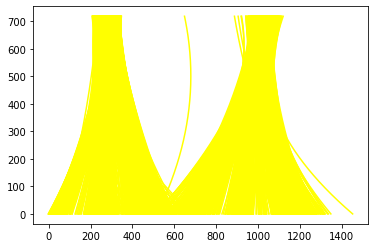

In [47]:
test_video_output = '../project_video_output.mp4'
clip = VideoFileClip("../project_video.mp4")
result = clip.fl_image(process_image) #NOTE: this function expects color images!!
%time result.write_videofile(test_video_output, audio=False)

### Discussions and Improvements of the project

1. The proposed approach works for project_video.mp4 but does not work for challenge video because of the shadows on-road and the steep lane curvature

2. Some of the potential problems in this project are- determining the destination points based on offset factor which can cause significant deviations on curved roads. 

3. The other problem is color channel thresholding based on different gradients and color space combinations. Its a trial and error methods as one lighting condition can be better than the other lighting condition.